# High Frequency Crpyto Trading Strategy
## FINM 33150 - Quant Trading Strategies (Winter 2024)

- Hanlu Ge 12455343 
- Junyuan liu 12449224 
- Xianjie Zhang 12452985
- Yong Li 12459425

# Table of Contents
- Introduction
- Data Overview and Preprocessing
- Data Analysis - Single Asset analysis - BTC
- Data Analysis - Multiple Cryptos
- Strategy Methodology-Sub Strategies
- Integrated Trading Strategy Backtesting
- Conclusion

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
import seaborn as sns
import os
import talib
import factors
import metrics
import picture
import importlib
importlib.reload(picture)
importlib.reload(metrics)
importlib.reload(factors)
from metrics import evaluate_strategy, calculate_cumulative_asset
from trading_signal import long_short_strategy, vol_long_short_strategy
import labeling
from tree import train_ensemble, evaluate_ensemble, get_predicted_label_sequence

# 1. Introduction

We selected the crypto market as our research focus due to its unique structural characteristics and trading dynamics, which differentiate it from traditional financial markets. Several key factors make crypto an ideal environment for high-frequency trading (HFT) research:

- High Volatility & Trading Opportunities
- 24/7 Trading & Market Microstructure
- Fragmented Market & Arbitrage Potential
- Advancements in Infrastructure & API Access
- Evolving Regulatory Landscape & Institutional Involvement

This project aims to construct a multi-strategy integrated quantitative trading model based on high-frequency sampled cryptocurrency data, thereby achieving controlled risk and stable returns under backtesting conditions. The research team has collected and analyzed five-minute interval data for 11 major cryptocurrencies, conducting in-depth exploratory analysis and statistical feature extraction to systematically compute technical indicators and liquidity factors. Subsequently, we developed three sub-strategies focusing on (1) decision-tree predictions using high-dimensional technical indicators, (2) refined technical indicators. These sub-strategies will then be combined through deterministic methods such as sliding windows and ensemble voting, thereby consolidating signals produced under various market conditions. The performance of this integrated model, in terms of both risk and returns, is assessed via multidimensional backtesting and sensitivity analysis, confirming its feasibility and scholarly significance for achieving robust trading in highly volatile and noisy cryptocurrency markets.

# 2. Data Overview and Preprocessing

## 2.1 Raw Data Retrieval from Binance API

In this project, we use minute-level of cryptocurrency data from Binance exchange. The data is collected from 2022-01-01 to 2024-12-31 and for simplicity, we only consider the crypto traded in USD.

In [40]:
import os
import requests
import pandas as pd
import datetime
from pathlib import Path
from typing import List, Optional
from concurrent.futures import ProcessPoolExecutor, as_completed
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)


class BinanceDataManager:
    _all_crypto: List[str]
    _fields = [
        "date", "open", "high", "low", "close", "preclose", "volume",
        "close_time", "quote_asset_volume", "number_of_trades",
        "taker_buy_base_asset_volume", "taker_buy_quote_asset_volume", "ignore"
    ]
    
    def __init__(
        self, 
        interval: tuple, 
        start_date: str, 
        end_date: str, 
        save_path: str, 
        max_workers: int = 10,
    ):
        self._save_path = save_path
        os.makedirs(self._save_path, exist_ok=True)
        self._interval = interval
        self._start_date = start_date
        self._end_date = end_date
        self.url = 'https://api.binance.us/api/v3/'
        self._max_workers = max_workers

    @property
    def _crypto_list_path(self) -> str:
        return f"{self._save_path}/crypto_list.txt"

    def _load_all_crypto(self) -> None:
        """Load all cryptocurrencies and save them to a text file."""
        url = self.url + "exchangeInfo"
        response = requests.get(url)
        symbols_info = response.json().get("symbols", [])

        # Extract the symbol names and save them to the list
        self._all_crypto = [symbol['symbol'] for symbol in symbols_info if symbol['status'] == 'TRADING']

        # Save the crypto list to a text file
        with open(self._crypto_list_path, "w") as f:
            for crypto in self._all_crypto:
                f.write(crypto + '\n')
                
    def _parallel_foreach(
        self,
        callable,
        input: List[dict],
        max_workers: Optional[int] = None
    ) -> list:
        if max_workers is None:
            max_workers = self._max_workers
        with tqdm(total=len(input)) as pbar:
            results = []
            with ProcessPoolExecutor(max_workers) as executor:
                futures = [executor.submit(callable, **elem) for elem in input]
                for f in as_completed(futures):
                    results.append(f.result())
                    pbar.update(n=1)
            return results

    def _get_unix_timestamp(self, date_str: str) -> int:
        """Convert date string to Unix timestamp in milliseconds."""
        dt = datetime.datetime.strptime(date_str, '%Y-%m-%d %H:%M:%S')
        return int(dt.timestamp() * 1000)

    
    def _download_klines_job(self, code: str) -> pd.DataFrame:
        """Fetch Kline data from Binance API with pagination to handle data limits."""
        
        kline_url = self.url + "klines"
        limit = 1000  # Maximum number of data points per request
        all_data = []  
        
        start_time = self._get_unix_timestamp(self._start_date)
        end_time = self._get_unix_timestamp(self._end_date)
        while start_time<end_time:
            params = {
                'symbol': code,
                'interval': self._interval[0],
                'startTime': start_time,
                'endTime': end_time,
                'limit': limit
            }
            
            response = requests.get(kline_url, params=params)
            data = response.json()
            
            if not data or len(data) == 0:
                break

            try:
                start_time = data[-1][0]+1
                all_data.extend(data)
            except:
                start_time = end_time 
        #import pdb;pdb.set_trace()
        if all_data:
            all_df = self._result_to_data_frame(all_data)
            all_df['date'] = pd.to_datetime(all_df['timestamp'])
            all_df['preclose'] = all_df['close'].shift(1)
            all_df['pctChg'] = ((all_df['close'] - all_df['preclose']) / all_df['preclose']) * 100
            all_df['amount'] = all_df['volume'] * all_df['close']
            
            all_df = all_df[self._fields]
            all_df.set_index('date', inplace=True)
            
            all_df.to_pickle(f"{self._save_path}/k_data/{code}.pkl")
        
        return all_data

    def _download_klines_data(self) -> None:
        print("Download crypto data")
        os.makedirs(f"{self._save_path}/k_data", exist_ok=True)
        #import pdb;pdb.set_trace()
        for code in tqdm(self._all_crypto):
            all_data = self._download_klines_job(code)
        # self._parallel_foreach(
        #     self._download_klines_job,
        #     [dict(code=code)
        #      for code in self._all_crypto]
        # )
        
    @classmethod
    def _result_to_data_frame(cls, data: list) -> pd.DataFrame:
        df = pd.DataFrame(data, columns=[
            "timestamp", "open", "high", "low", "close", "volume",
            "close_time", "quote_asset_volume", "number_of_trades",
            "taker_buy_base_asset_volume", "taker_buy_quote_asset_volume",
            "ignore"
        ])
        df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms')
        df[['open', 'high', 'low', 'close', 'volume']] = df[['open', 'high', 'low', 'close', 'volume']].astype(float)
        return df

    def fetch_and_save_data(self):
        """Fetch Kline data and save it to a CSV file."""
        self._load_all_crypto()
        self._download_klines_data()

    def _read_all_text(self, path: str) -> str:
        """Read all text from a file."""
        with open(path, "r") as f:
            return f.read()

def collect_data(interval, start_date,end_date,save_path):
    # Create an instance of the BinanceDataManager
    binance_dm = BinanceDataManager(
        interval=interval, 
        start_date=start_date, 
        end_date=end_date, 
        save_path=save_path
    )

    # Fetch and save Kline data
    binance_dm.fetch_and_save_data()
    

if __name__ == "__main__":
    collect_data(
        interval = ("5m","5min"),  # 5 minute interval
        start_date = "2022-01-01 00:00:00",
        end_date = "2024-12-31 00:00:00",
        save_path = "data/cpt_5min")

## 2.2 Filter the ticker data completeness

In [41]:
# data_dir = r"./CryptoData1"
data_dir = r"./data/cpt_5min/k_data"

# data quality threshold
threshold = 315269
# only load the files that end with USD.pkl
pkl_files = [f for f in os.listdir(data_dir)]
# Modified to reset index for each DataFrame before concatenation
data_dict = {}
for file in pkl_files:
    df = pd.read_pickle(os.path.join(data_dir, file))
    # filter out the data that is not complete
    if df.shape[0] == threshold:
        data_dict[file] = df.assign(
            ticker=file.replace('USDT.pkl', '')
        ).reset_index()

combined_df = pd.concat(data_dict.values(), ignore_index=True)
combined_df.head()

date   open   high    low  close  preclose  volume  \
0 2021-12-31 16:00:00  2.489  2.490  2.489  2.490       NaN    55.8   
1 2021-12-31 16:05:00  2.490  2.490  2.490  2.490     2.490     0.0   
2 2021-12-31 16:10:00  2.479  2.479  2.479  2.479     2.490     5.0   
3 2021-12-31 16:15:00  2.479  2.479  2.479  2.479     2.479     0.0   
4 2021-12-31 16:20:00  2.479  2.479  2.479  2.479     2.479     0.0   

      close_time quote_asset_volume  number_of_trades  \
0  1640966699999       138.92590000                 2   
1  1640966999999         0.00000000                 0   
2  1640967299999        12.39500000                 1   
3  1640967599999         0.00000000                 0   
4  1640967899999         0.00000000                 0   

  taker_buy_base_asset_volume taker_buy_quote_asset_volume ignore ticker  
0                 55.80000000                 138.92590000      0  1INCH  
1                  0.00000000                   0.00000000      0  1INCH  
2                  5.00000000                  12.39500000      0  1INCH  
3                  0.00000000                   0.00000000      0  1INCH  
4                  0.00000000                   0.00000000      0  1INCH

**Columns Description:**

- **date**: The datetime marking the start of a 5-minute interval.
- **open**: The opening price.
- **high**: The highest price.
- **low**: The lowest price.
- **close**: The closing price.
- **preclose**: The previous interval's closing price (calculated as `preclose = close.shift(1)`).
- **volume**: The total trading volume.
- **close_time**: The timestamp indicating the end of the 5-minute interval.
- **quote_asset_volume**: The traded volume measured in the quote asset during the 5-minute interval.
- **number_of_trades**: The total number of trades executed during the 5-minute interval.
- **taker_buy_base_asset_volume**: The volume of the base asset bought by takers.
- **taker_buy_quote_asset_volume**: The volume of the quote asset bought by takers.
- **ignore**: A placeholder column with no specific use.
- **ticker**: The cryptocurrency ticker.

## 2.3 Filter the ticker by number of trades

drop the ticker with low volume with the following steps:

1. Calculate the average volume for each ticker.
2. Filter the ticker with average number of trades less than 1, that is, at least 1 trade in the five minutes interval
3. Drop the ticker with low volume.

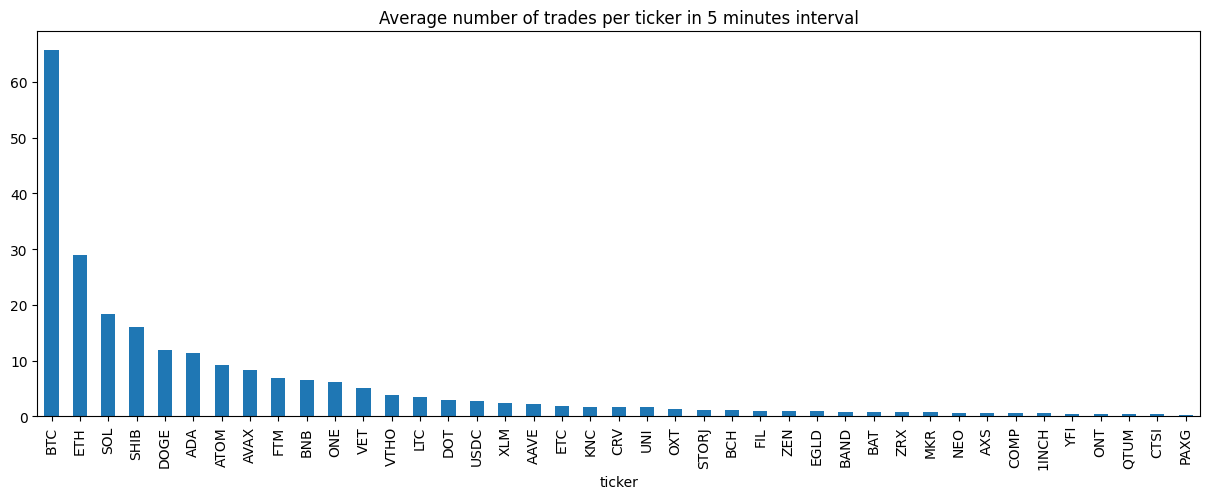

In [42]:
combined_df.groupby('ticker')['number_of_trades'].mean().sort_values(ascending=False).plot(kind='bar', figsize=(15, 5))
plt.title('Average number of trades per ticker in 5 minutes interval')
plt.show()

In [43]:
# filter out the data that has less than 0.05 quantile of the mean volume
filtered_df1 = combined_df[combined_df['ticker'].map(combined_df.groupby('ticker')['number_of_trades'].mean() > 1)].reset_index(drop=True)
print(f"Remain tickers after volume filter: {filtered_df1['ticker'].nunique()}")

Remain tickers after volume filter: 25


## 2.2 Filter the ticker of quantile of return

In [44]:
filtered_df1['ret'] = filtered_df1.groupby('ticker')['close'].pct_change()
res = filtered_df1.groupby('ticker')['ret'].describe().sort_values('75%', ascending=False)
res

count          mean       std       min       25%  50%       75%  \
ticker                                                                        
SOL     315268.0  6.199572e-06  0.003465 -0.109259 -0.001303  0.0  0.001312   
SHIB    315268.0  4.331039e-06  0.003450 -0.107133 -0.001046  0.0  0.001083   
ADA     315268.0  2.319111e-06  0.002769 -0.059805 -0.000917  0.0  0.000944   
DOGE    315268.0  7.128609e-06  0.003254 -0.084370 -0.000864  0.0  0.000907   
ETH     315268.0  1.871810e-06  0.002139 -0.052219 -0.000785  0.0  0.000800   
AVAX    315268.0  2.132986e-06  0.003366 -0.194893 -0.000715  0.0  0.000737   
BNB     315268.0  3.277732e-06  0.002183 -0.052357 -0.000664  0.0  0.000725   
BTC     315268.0  3.499931e-06  0.001694 -0.043487 -0.000659  0.0  0.000670   
ATOM    315268.0  3.556736e-07  0.003340 -0.174401 -0.000208  0.0  0.000262   
VET     315268.0  3.928470e-06  0.003500 -0.113510 -0.000130  0.0  0.000261   
LTC     315268.0  2.234264e-06  0.002678 -0.113997  0.000000  0.0  0.000144   
AAVE    315268.0  7.308793e-06  0.003651 -0.125436  0.000000  0.0  0.000000   
BCH     315268.0  6.559534e-06  0.003622 -0.227626  0.000000  0.0  0.000000   
CRV     315268.0  4.170831e-06  0.004464 -0.174057  0.000000  0.0  0.000000   
FTM     315268.0  5.292832e-06  0.004232 -0.178784  0.000000  0.0  0.000000   
ETC     315268.0  5.879477e-06  0.003729 -0.116125  0.000000  0.0  0.000000   
DOT     315268.0 -2.479831e-07  0.002931 -0.144913  0.000000  0.0  0.000000   
OXT     315268.0  1.293514e-05  0.006275 -0.673469  0.000000  0.0  0.000000   
ONE     315268.0  2.456993e-06  0.004353 -0.245394  0.000000  0.0  0.000000   
KNC     315268.0  1.528878e-05  0.007600 -0.773031  0.000000  0.0  0.000000   
STORJ   315268.0  1.123669e-05  0.006016 -0.527191  0.000000  0.0  0.000000   
UNI     315268.0  5.919039e-06  0.003744 -0.147636  0.000000  0.0  0.000000   
USDC    315268.0  1.245853e-06  0.001586 -0.285050  0.000000  0.0  0.000000   
VTHO    315268.0  9.382566e-06  0.004985 -0.184369  0.000000  0.0  0.000000   
XLM     315268.0  5.530041e-06  0.003171 -0.156398  0.000000  0.0  0.000000   

             max  
ticker            
SOL     0.177653  
SHIB    0.111365  
ADA     0.054610  
DOGE    0.120471  
ETH     0.081958  
AVAX    0.112780  
BNB     0.080841  
BTC     0.048632  
ATOM    0.175662  
VET     0.179286  
LTC     0.087424  
AAVE    0.132937  
BCH     0.163728  
CRV     0.257268  
FTM     0.285000  
ETC     0.131208  
DOT     0.105983  
OXT     2.020833  
ONE     0.386760  
KNC     3.352941  
STORJ   1.465779  
UNI     0.147346  
USDC    0.372203  
VTHO    0.202703  
XLM     0.178934

In [45]:
ticker_list = res[res['75%'] > 0].index
filtered_df2 = filtered_df1[filtered_df1['ticker'].isin(ticker_list)].reset_index(drop=True)
print(f"Remain tickers after return filter: {filtered_df2['ticker'].nunique()}")

Remain tickers after return filter: 11


The tickers left are:

| ADA  | ATOM | AVAX |  BNB | BTC  |
|------|------|------|------|------|
| **DOGE**  | **ETH**  | **LTC**  |  **SHIB** | **SOL** |
| **VETI**  |   |      |      |      |

## 3. Data Analysis - Single Asset analysis - BTC

Bitcoin is the most popular cryptocurrency and has the highest market capitalization. We take Bitcoin as an example to analyze the market dynamics and trading patterns in the crypto market.

### 3.1 Descriptive Statistics

In [47]:
BTCUSD = filtered_df2[filtered_df2['ticker'] == 'BTC'].reset_index(drop=True)
BTCUSD['date'] = pd.to_datetime(BTCUSD['date'])
BTCUSD = BTCUSD[(BTCUSD['date'] >= '2022-01-01') & (BTCUSD['date'] <= '2024-12-31')].reset_index(drop=True)
data = BTCUSD.drop(columns=['ignore'])
data.describe()

date           open           high  \
count                         315173  315173.000000  315173.000000   
mean   2023-07-02 09:10:56.744073216   40939.216608   40972.906137   
min              2022-01-01 00:00:00   15596.550000   15630.640000   
25%              2022-10-01 14:35:00   24747.640000   24780.150000   
50%              2023-07-02 11:50:00   34980.940000   35025.380000   
75%              2024-04-01 01:55:00   58993.790000   59036.560000   
max              2024-12-30 16:00:00  108244.530000  138070.000000   
std                              NaN   20640.382815   20656.693320   

                 low          close       preclose         volume  \
count  315173.000000  315173.000000  315173.000000  315173.000000   
mean    40903.643842   40939.270568   40939.125330       2.670713   
min     15486.740000   15593.390000   15593.390000       0.000000   
25%     24711.920000   24747.160000   24747.160000       0.034038   
50%     34949.920000   34979.880000   34979.880000       0.297510   
75%     58940.240000   58998.860000   58997.150000       2.059479   
max    107915.260000  108244.540000  108244.540000     555.412318   
std     20623.088387   20640.789086   20640.590922       7.398777   

         close_time  number_of_trades            ret  
count  3.151730e+05     315173.000000  315173.000000  
mean   1.688289e+12         65.763911       0.000004  
min    1.640995e+12          0.000000      -0.043487  
25%    1.664635e+12         10.000000      -0.000659  
50%    1.688299e+12         29.000000       0.000000  
75%    1.711937e+12         75.000000       0.000670  
max    1.735575e+12       4091.000000       0.048632  
std    2.730534e+10        112.397810       0.001694

1. **Price Range and Volatility**  
   - The **open** price spans from around **15,596.55** to **108,244.53**. This broad range indicates that our dataset covers multiple market phases, from relatively lower BTC prices to periods of significant price escalation.
   - The **average open** is approximately **40,940.95**, with a standard deviation of **20,637.48**, highlighting substantial volatility that could present opportunities for HFT strategies.

2. **Volume Dynamics**  
   - The **mean volume** is about **2.67**, but it spikes up to **555.41**, indicating that there are periods of high trading activity along with low-volume intervals. This fluctuation in volume can impact the effectiveness of HFT strategies, as liquidity conditions can vary significantly.

3. **Trading Frequency**  
   - On average, the **number of trades** per interval is around **65.76**. However, the maximum observed is **4,091**, illustrating large swings in how frequently trades occur. HFT systems often do well in such environments, as higher trade counts enable rapid entry and exit.

4. **Data Coverage**  
   - The **date** ranges from **2022-01-01** to **2024-12-30**, covering a substantial periodlikely spanning multiple years of BTC price action. This  allows for robust backtesting across different market conditions

### Implications for HFT Strategy Testing

- **Volatile Environment**: High volatility  can create frequent arbitrage opportunities.
- **Liquidity Events**: Number of trades indicates that generally the liquidity is high, which can be used by HFT strategies.

### 3.2 Missing Value Check

In [48]:
data.set_index('date', inplace=True)
print(data.isnull().sum())
data = data.fillna(0)

open                            0
high                            0
low                             0
close                           0
preclose                        0
volume                          0
close_time                      0
quote_asset_volume              0
number_of_trades                0
taker_buy_base_asset_volume     0
taker_buy_quote_asset_volume    0
ticker                          0
ret                             0
dtype: int64


The data equality is generally high, with **no missing values** in the dataset. This is crucial for HFT strategies, as missing data can lead to inaccurate signals and execution errors.

### 3.3 BTC 5-Minute Close Price 

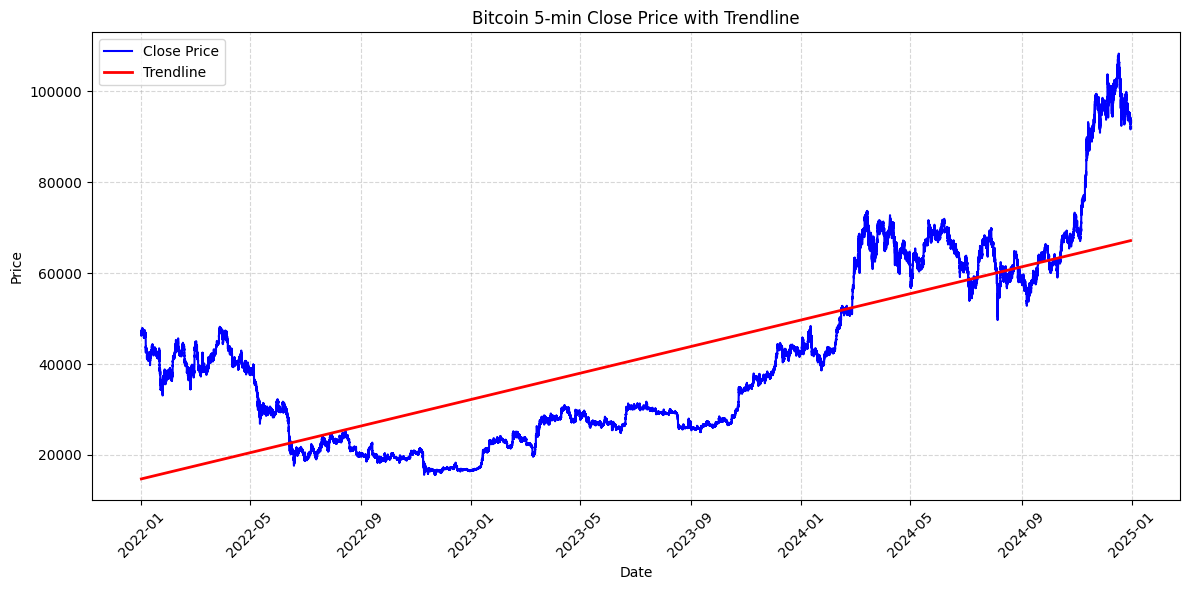

In [49]:
plt.figure(figsize=(12, 6))
plt.plot(data.index, data['close'], linestyle='-', color='blue', label='Close Price')

x = mdates.date2num(data.index.to_pydatetime())
y = data['close'].values

coeffs = np.polyfit(x, y, deg=1)
trend = np.poly1d(coeffs)
trend_y = trend(x)

plt.plot(data.index, trend_y, color='red', linewidth=2, label='Trendline')

plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Bitcoin 5-min Close Price with Trendline')
plt.xticks(rotation=45)
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()

The chart above shows the 5-minute close price of Bitcoin from early **2022** to early **2025**, overlaid with a **linear trendline** (in red). Key observations include:

1. **Early Price Drop**  
   - In early 2022, BTC falls from about 40kC45k down to around 15k. This drop is often called a crypto winter.  
   - Big events (like the Terra/Luna crash and some exchanges failing) plus world economic issues push prices lower.

2. **Recovery and Upward Trend**  
   - After hitting around 15k in mid-2022, the price starts to rise. By late 2024 and early 2025, it is well above its level at the start of 2022.  
   - The red trend line on the chart tilts upward, showing that overall, the price moved higher over time.

3. **Price Swings and Trading Chances**  
   - Even when the price is falling, there are still quick ups and downs, which can be risky but also offer short-term trading chances.  
   - As the price goes up again, these swings continue, giving room for short-term or high-frequency trading strategies to benefit from fast price moves.


### 3.4 Volume Trend Visualization

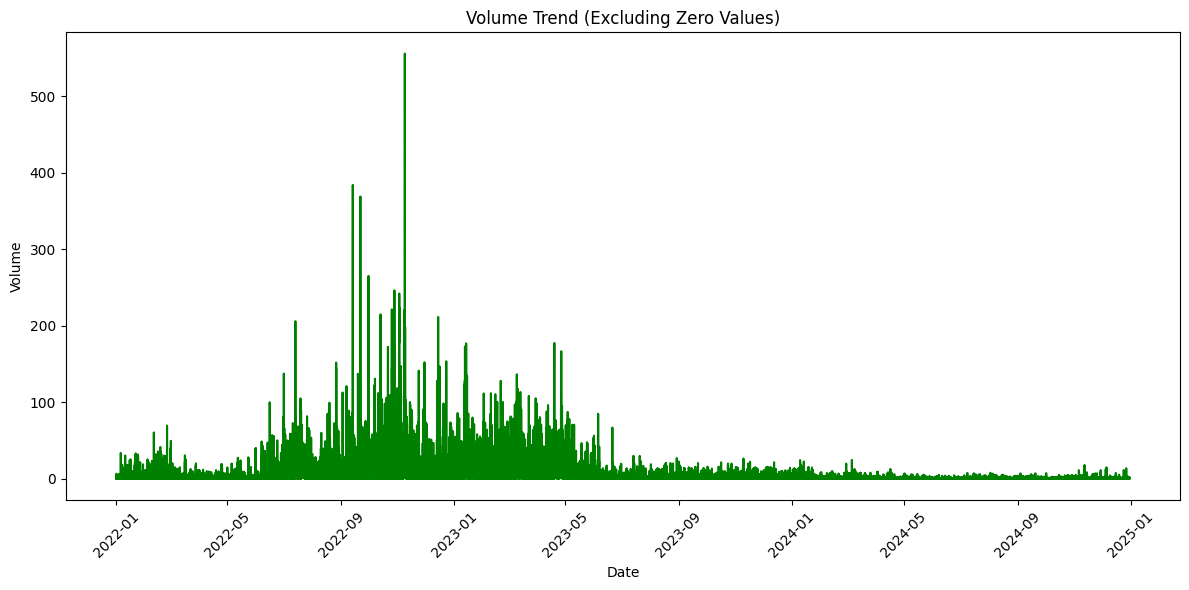

In [50]:
filtered_volume = data[data['volume'] != 0]
plt.figure(figsize=(12, 6))
plt.plot(filtered_volume.index, filtered_volume['volume'], color='green')
plt.xlabel('Date')
plt.ylabel('Volume')
plt.title('Volume Trend (Excluding Zero Values)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

The chart above illustrates Bitcoins trading volume on a 5-minute interval from **2022** through early **2025**, excluding periods where volume was zero. Key points include:

1. **Big Volume Spikes in Mid- to Late-2022**  
   - We see many tall peaks around this period, with some going above 500 units.  
   - These big jumps often happened during major events like the Terra/Luna crash and the FTX crisis.

2. **Lower Volume After Late-2022**  
   - Once these events passed, volume fell and stayed low through 2023 and 2024.  
   - Even though the price later climbed, trading activity stayed calmer than before.

3. **Impact on Trading**  
   - Sudden changes in volume can bring both chances for profit and extra risk.  
   - High-frequency traders need to be ready to handle quick surges or drops in activity.  


### 3.5 Visualization of Close Price Rate of Change

This chart shows how the BTC price changes from one 5-minute interval to the next. Most of the time, changes (returns) stay close to zero, suggesting that many small moves happen around the average. But we also see big spikesboth up and downwhich means the market can swing more than a normal bell curve would predict. These big jumps often come from fast shifts in trading activity or breaking news, highlighting the extra volatility in crypto markets.


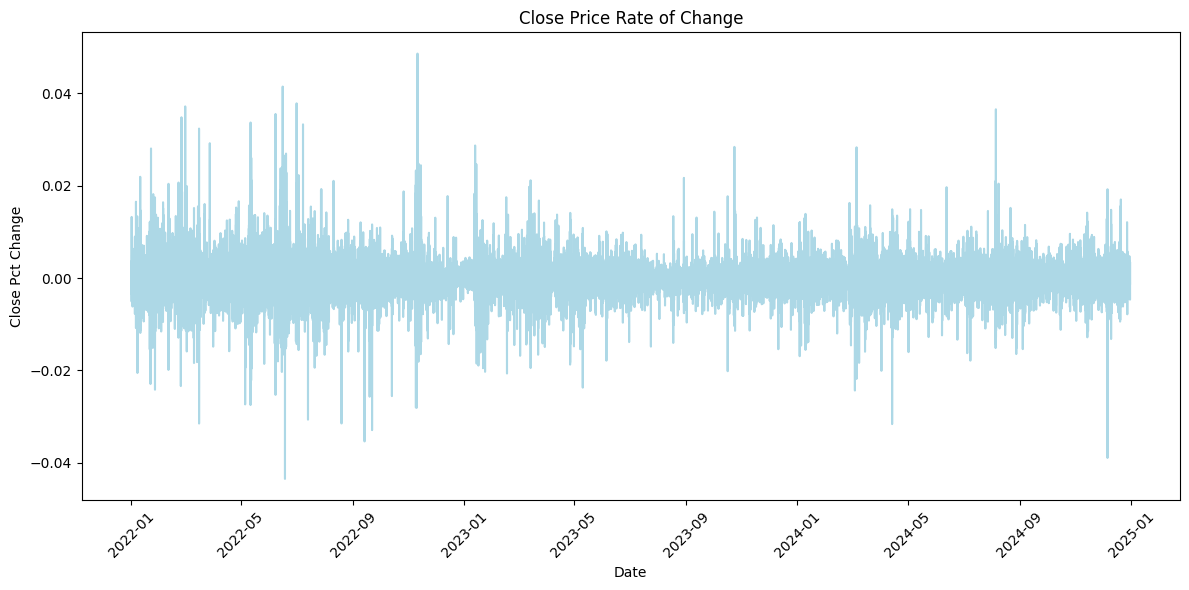

In [51]:
data['close_pct_change'] = data['close'].pct_change()
plt.figure(figsize=(12, 6))
plt.plot(data.index, data['close_pct_change'], color='lightblue')
plt.xlabel('Date')
plt.ylabel('Close Pct Change')
plt.title('Close Price Rate of Change')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### 3.6 Data Distribution

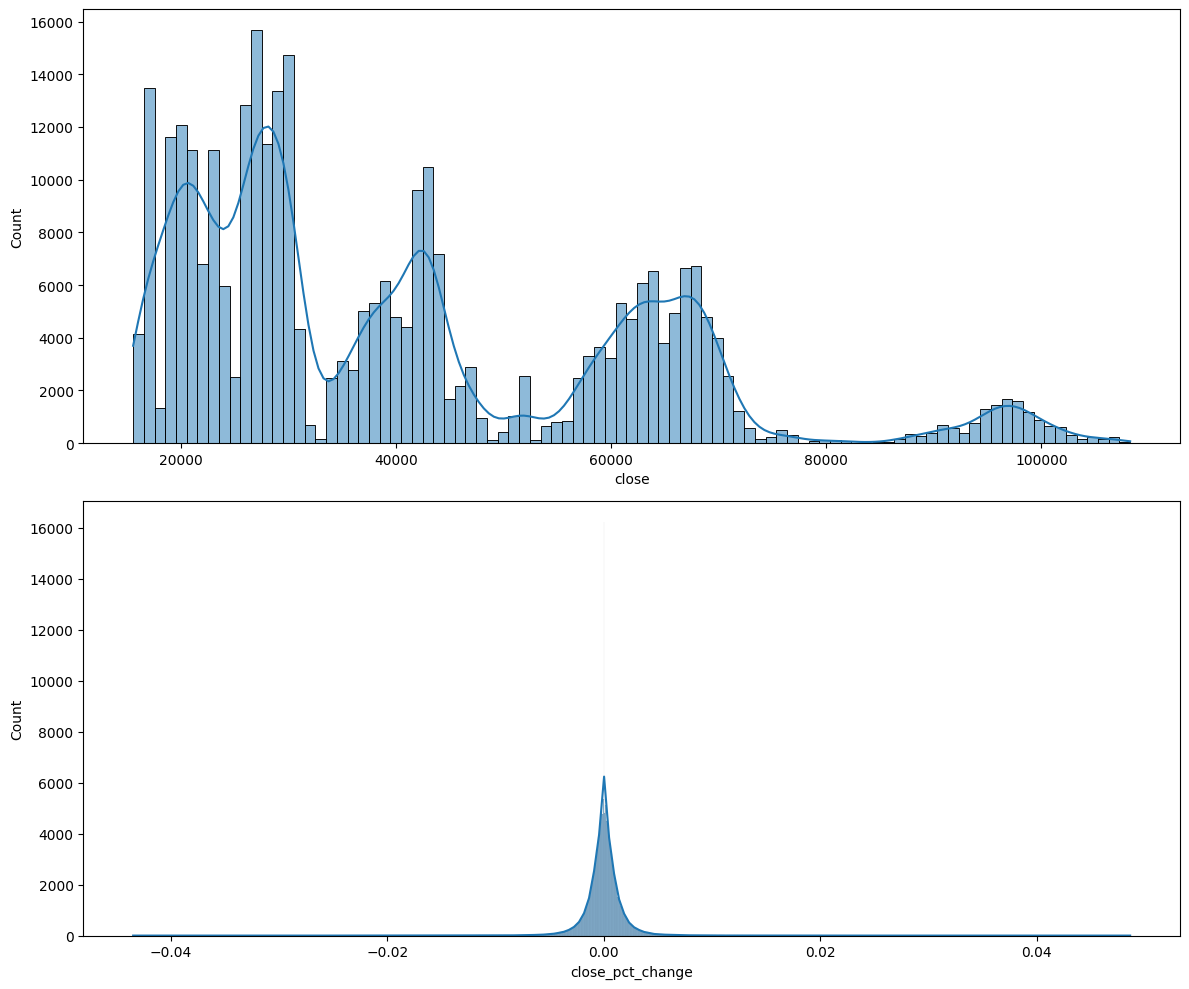

In [52]:
plt.figure(figsize=(12, 10))
for i, col in enumerate(['close', 'close_pct_change']):
    plt.subplot(2, 1, i+1)
    sns.histplot(data[col], kde=True)
plt.tight_layout()
plt.show()

The top histogram shows **BTCs closing prices** from 2022 to early 2025. There are several peaks:
- A main cluster around **15kC20k**  
- Another cluster near **35kC45k**

These clusters suggest that market sentiment shifted at different times over the sample period.

The bottom histogram displays the **five-minute returns**. Most returns center closely around **0%**, but the fat tails show that big moves do happen more often than a normal distribution would predictcommon in crypto markets.

Finally, there are **no major gaps or errors** in the data, implying it is reliable for deeper analysis and for building or testing trading strategies.

### 3.7 Autocorrelation Analysis

We checked how each 5-minute BTC return relates to its past values by looking at the **partial autocorrelation** up to 80 steps back (lags). Heres what we found:

- **One Big Spike at Lag 0**: This just shows the return is perfectly correlated with itself at the same point in time, which is expected.  
- **No Noticeable Autocorrelation After Lag 0**: All other lags stay near zero, meaning the returns have little to no memory of past changes.  

**if BTCs price went up or down in one 5-minute interval**, it does not give much clue about what will happen in the next few intervals. This lines up with the idea that crypto markets often behave in a way where recent price movements do **not** strongly predict future ones.


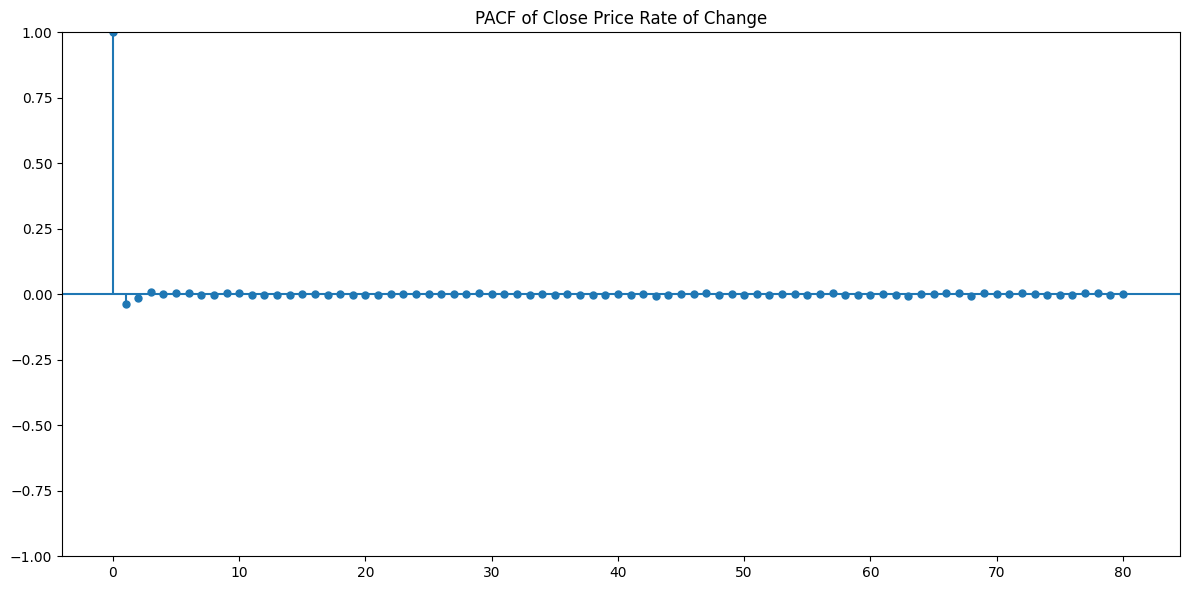

In [53]:
fig, ax = plt.subplots(figsize=(12, 6))
plot_pacf(data['close_pct_change'].dropna(), lags=80, ax=ax)
plt.title('PACF of Close Price Rate of Change')
plt.tight_layout()
plt.show()

# 4. Data Analysis - Multiple Cryptos

To examine the correlation among different cryptocurrencies close price movements during the sample period, we selected the five with the highest average trading volume, along with Bitcoin, for the following comparative analysis.

## 4.1 Return and Cumulative Return Visualization

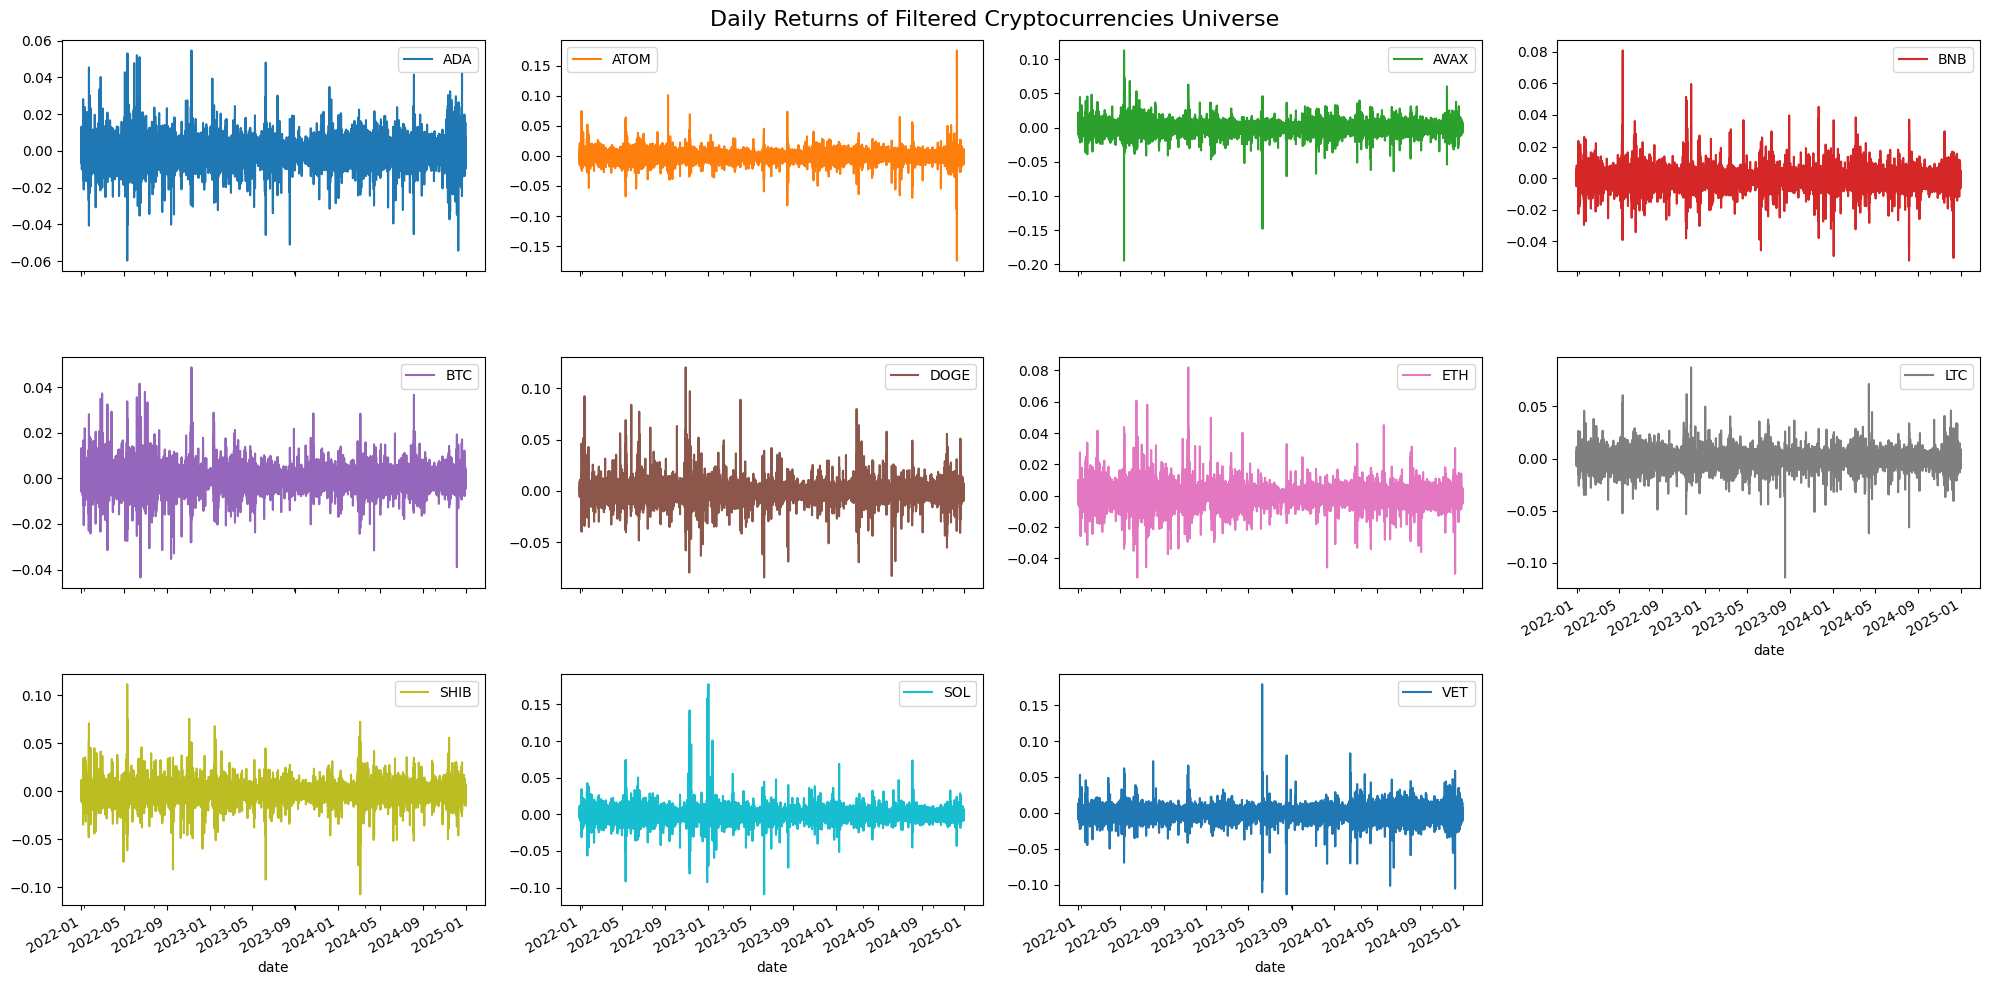

In [59]:
crypto_ret = filtered_df2.pivot(index='date', columns='ticker', values='ret') 
crypto_ret.plot(subplots=True, layout=(3, 4), figsize=(20, 10), sharex=True)
plt.suptitle('Daily Returns of Filtered Cryptocurrencies Universe',fontsize=16) 
plt.tight_layout()  
plt.subplots_adjust(top=0.95) 
plt.show() 

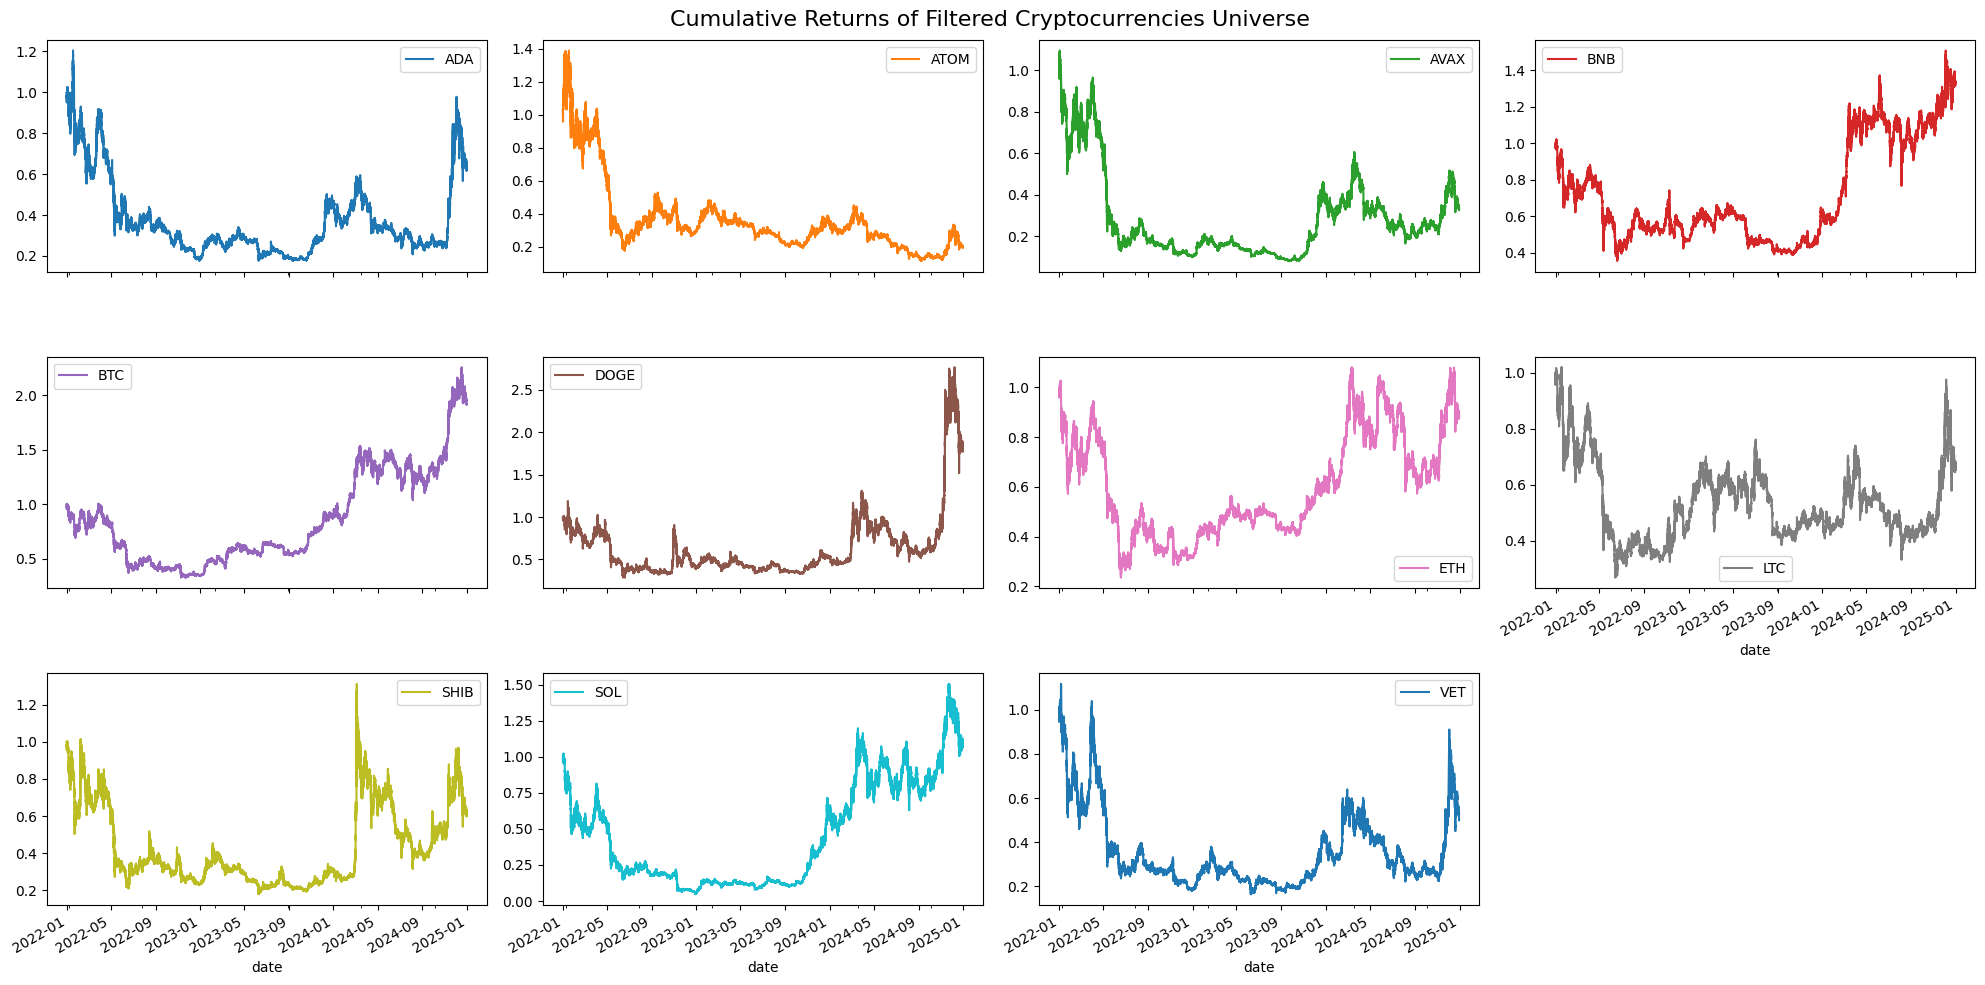

In [60]:
(crypto_ret+1).cumprod().plot(subplots=True, layout=(3, 4), figsize=(20, 10), sharex=True)
plt.suptitle('Cumulative Returns of Filtered Cryptocurrencies Universe',fontsize=16)
plt.tight_layout()
plt.subplots_adjust(top=0.95)
plt.show()

## 4.2 Correlation Analysis

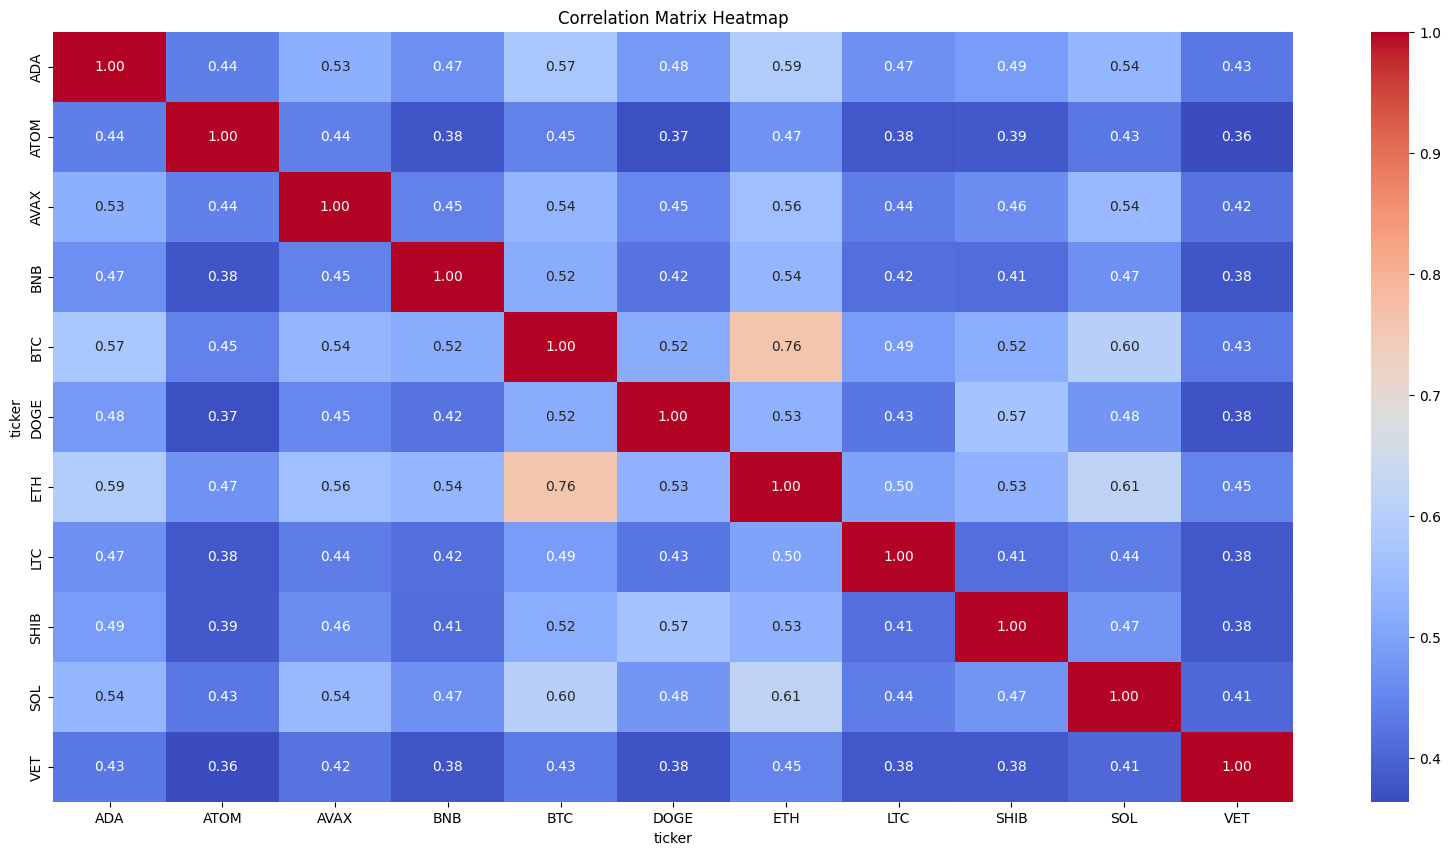

In [61]:
corr_matrix = crypto_ret.corr()
plt.figure(figsize=(20, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix Heatmap')
plt.show()

**Overall Pattern**  
Most of the cryptocurrencies in this heatmap show moderate to high positive correlations with one another. This is typical in crypto markets, where broad market sentiment often moves prices across different assets.

**High-Correlation Pairs**  
- **BTC and ETH** have one of the highest correlations (around **0.76**), suggesting that when Bitcoins price changes, Ethereum often follows suit.  
- **BTC and BNB** also display a relatively strong correlation (above **0.75**), indicating that BNBs price movements are closely tied to Bitcoins dynamics.

**Moderate-Correlation Range**  
For many other pairs, correlations cluster between **0.50** and **0.70**. These moderate correlations suggest some shared market drivers, though there is still room for each coin to move independently.

**Implications for Diversification**  
Although correlations are not uniformly high, they are still significant enough that holding multiple coins may not provide full diversification. During large market moves, most coins tend to be affected simultaneously.

**Conclusion**  
Overall, this correlation matrix shows that while specific pairs may have some distinctions, the crypto market generally moves in tandem. Investors seeking diversification should look for pairs with lower correlations, while keeping in mind that strong, market-wide movements can still impact most crypto assets at once.


# 5. Strategy Methodology-Sub Strategies
In this high-frequency trading strategy, we implement three key sub-strategies:

- Price Jump Detection and Liquidity Factor Utilization
- High-Dimensional Technical Indicators and Decision-Tree Classification
- De-Trending and Dynamic Threshold Adjustments

In developing these sub-strategies, we use the mainstream cryptocurrency Bitcoin as the primary trading asset to benchmark and assess performance. This approach enables us to construct the final ensemble strategy, which is then backtested across a full sample of 11 major cryptocurrencies to evaluate its robustness and adaptability in different market environments.

We combine the three sub-strategies through ensemble voting and sliding windows to generate trading signals. These signals are subsequently used to execute trades and manage positions in a controlled manner, aiming for both high-frequency gains and effective risk control.

### Initial Observations with RSI  
Our study begins with the **Relative Strength Index (RSI)**, a classic technical indicator. However, when applied to **high-frequency data**, we observed several critical issues:  

- **Extreme Volatility:** The high fluctuation of market data results in an **unstable RSI**, leading to excessive trading.  
- **Frequent Trades:** Rapid shifts in RSI values cause **overactive trading**, which can accumulate **significant transaction costs** and **losses**.  
- **False Signals in Extreme Events:** On **January 21, 2022**, a **sharp price drop** occurred, but the RSI falsely signaled a **buy opportunity**, leading to **substantial losses**.  

In [2]:
import pandas as pd
df = pd.read_pickle("data/cpt_5min/k_data/BTCUSD.pkl")

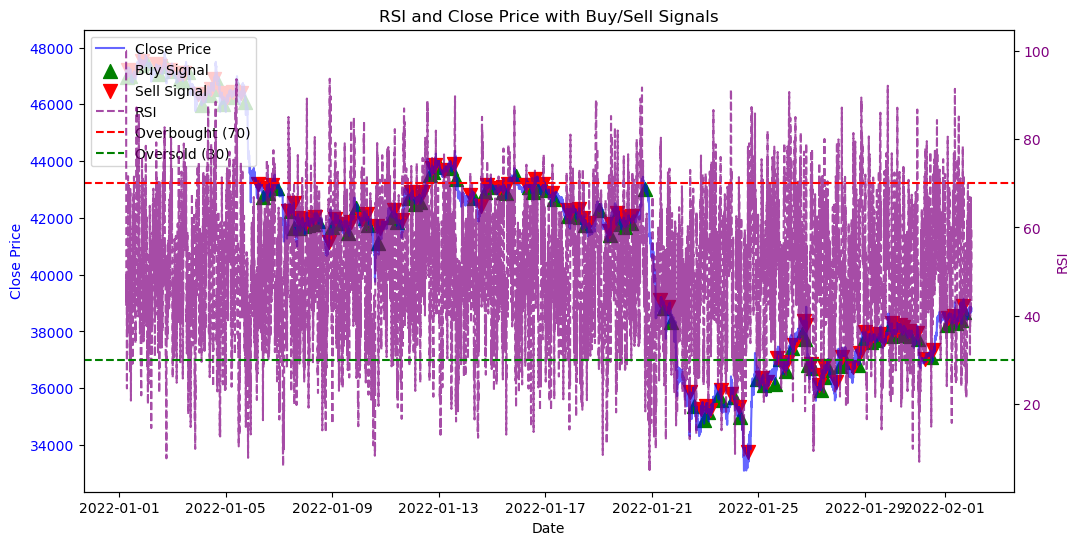

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def calculate_rsi(data, period=14):
    """Compute the Relative Strength Index (RSI) using EMA."""
    delta = data.diff()
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)

    avg_gain = gain.ewm(span=period, adjust=False).mean()
    avg_loss = loss.ewm(span=period, adjust=False).mean()

    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

def backtest_rsi(data, period=14, rsi_buy=30, rsi_sell=70, initial_cash=10000):
    """Backtest an RSI strategy and record buy/sell points."""
    data = data.copy()
    data["RSI"] = calculate_rsi(data["close"], period)
    
    cash = initial_cash
    position = 0
    portfolio = []
    buy_signals = []
    sell_signals = []

    for i in range(len(data)):
        price = data["close"].iloc[i]
        rsi = data["RSI"].iloc[i]

        if rsi < rsi_buy and cash > 0:  # Buy condition
            position = cash / price
            cash = 0
            buy_signals.append((data.index[i], price))
        elif rsi > rsi_sell and position > 0:  # Sell condition
            cash = position * price
            position = 0
            sell_signals.append((data.index[i], price))

        portfolio_value = cash + (position * price)  # Track portfolio value
        portfolio.append(portfolio_value)

    data["Portfolio"] = portfolio
    return data, buy_signals, sell_signals

# Load the data
data = df.copy()

data = data[:'2022-2-01']

# Run the RSI backtest
result, buy_signals, sell_signals = backtest_rsi(data)

# Create a figure and axis
fig, ax1 = plt.subplots(figsize=(12,6))

# Plot the closing price
ax1.plot(result.index, result["close"], label="Close Price", color="blue", alpha=0.6)
ax1.set_xlabel("Date")
ax1.set_ylabel("Close Price", color="blue")
ax1.tick_params(axis='y', labelcolor="blue")

# Plot buy/sell signals (only one legend entry for each)
if buy_signals:
    ax1.scatter(*zip(*buy_signals), marker="^", color="green", label="Buy Signal", s=100)
if sell_signals:
    ax1.scatter(*zip(*sell_signals), marker="v", color="red", label="Sell Signal", s=100)

# Add a secondary y-axis for RSI
ax2 = ax1.twinx()
ax2.plot(result.index, result["RSI"], label="RSI", linestyle="dashed", color="purple", alpha=0.7)
ax2.axhline(70, linestyle="--", color="red", label="Overbought (70)")
ax2.axhline(30, linestyle="--", color="green", label="Oversold (30)")
ax2.set_ylabel("RSI", color="purple")
ax2.tick_params(axis='y', labelcolor="purple")

# Merge legends from both axes
handles1, labels1 = ax1.get_legend_handles_labels()
handles2, labels2 = ax2.get_legend_handles_labels()

# Keep only one legend entry for Buy and Sell signals
legend_labels = {}
for handle, label in zip(handles1 + handles2, labels1 + labels2):
    if label not in legend_labels:
        legend_labels[label] = handle

ax1.legend(legend_labels.values(), legend_labels.keys(), loc="upper left")

plt.title("RSI and Close Price with Buy/Sell Signals")
plt.show()


To overcome these challenges, we propose an **improved research direction** focusing on optimizing high-frequency trading strategies.  

## Research Objectives  
To enhance the performance of high-frequency trading in crypto markets, our study will explore the following key areas:  

1. **Predicting Intraday Price Jumps**  
   - Develop methods to identify and predict **intraday price jumps** with high probability.  
   - Improve decision-making to reduce **strategy drawdowns** and optimize trade timing.  

2. **Adapting Classic Technical Indicators for High-Frequency Trading**  
   - Modify traditional indicators like RSI to **reduce noise** and enhance signal stability.  
   - Explore alternative smoothing techniques to prevent **excessive trading** due to high volatility.  

3. **Market Regime Adaptability**  
   - Design strategies that can **adjust dynamically** based on market conditions:  
     - **Trending markets (bull/bear trends)**  
     - **Range-bound (sideways) markets**  
   - Implement **adaptive risk management** to handle different volatility environments effectively.  


In [38]:
import importlib
import technical_indicators  

importlib.reload(technical_indicators)

from technical_indicators import TechnicalIndicators

In [39]:
tech_indicators = TechnicalIndicators(df)
df_with_indicators = tech_indicators.get_tech_indicators()

In [40]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Function to implement the trading strategy
def apply_trading_strategy(df):
    df = df.copy()

    # Initialize positions
    df['Signal_SMA'] = 0  
    df['Signal_EMA'] = 0  
    df['Signal_MACD'] = 0  
    df['Signal_Bollinger'] = 0 
    df['Signal_Stochastic'] = 0  
    df['Signal_RSI'] = 0  

    # Strategy 1: SMA Crossover
    df.loc[df['close'] > df['SMA_20'], 'Signal_SMA'] = 1  # Buy
    df.loc[df['close'] < df['SMA_20'], 'Signal_SMA'] = -1  # Sell

    # Strategy 2: EMA Trend
    df.loc[df['close'] > df['EMA_14'], 'Signal_EMA'] = 1  
    df.loc[df['close'] < df['EMA_14'], 'Signal_EMA'] = -1  

    # Strategy 3: MACD Crossover
    df.loc[df['MACD'] > df['Signal_Line'], 'Signal_MACD'] = 1  
    df.loc[df['MACD'] < df['Signal_Line'], 'Signal_MACD'] = -1  

    # Strategy 4: Bollinger Bands
    df.loc[df['close'] < df['Lower_BB'], 'Signal_Bollinger'] = 1  
    df.loc[df['close'] > df['Upper_BB'], 'Signal_Bollinger'] = -1  

    # Strategy 5: Stochastic Oscillator
    df.loc[(df['%K'] > df['%D']) & (df['%K'] < 20), 'Signal_Stochastic'] = 1  
    df.loc[(df['%K'] < df['%D']) & (df['%K'] > 80), 'Signal_Stochastic'] = -1  

    # Strategy 6: RSI Overbought/Oversold
    df.loc[df['RSI'] < 30, 'Signal_RSI'] = 1  
    df.loc[df['RSI'] > 70, 'Signal_RSI'] = -1  

    return df

# Apply the strategy
df_strategy = apply_trading_strategy(df_with_indicators)

In [41]:
import trading_signal  

importlib.reload(trading_signal)

from trading_signal import long_short_strategy
from trading_signal import long_only_strategy
from trading_signal import short_only_strategy

# Apply strategies
series_position_long_short = long_short_strategy(df_strategy['Signal_RSI'])
series_position_long_only = long_only_strategy(df_strategy['Signal_RSI'])
series_position_short_only = short_only_strategy(df_strategy['Signal_RSI'])

In [42]:
import importlib
import metrics  

importlib.reload(metrics)

from metrics import evaluate_strategy
from metrics import calculate_cumulative_asset

In [43]:
df_result = calculate_cumulative_asset(df_strategy["close"], series_position_long_short)

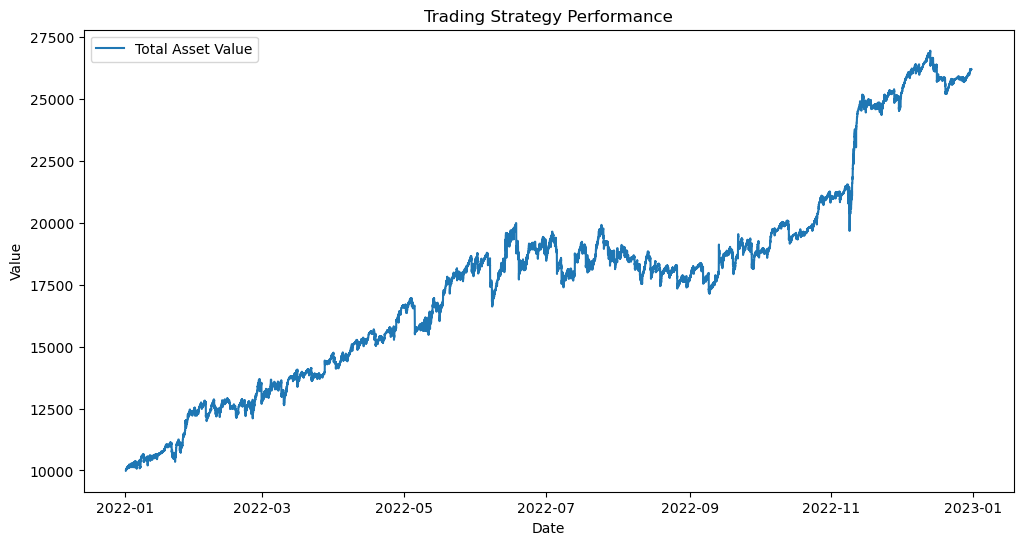

In [10]:
import matplotlib.pyplot as plt

# Plot Total Asset Value, Cash Balance, and Crypto Holdings Value
plt.figure(figsize=(12,6))

# Plot total asset value
plt.plot(df_result.index, df_result["Cumulative_Asset"], label="Total Asset Value")

# Labels and title
plt.xlabel("Date")
plt.ylabel("Value")
plt.title("Trading Strategy Performance")

# Show legend
plt.legend()

# Show the plot
plt.show()


In [11]:
evaluate_strategy(df_result, risk_free_rate=0.0)

{'Sharpe Ratio': 0.008261191976525868,
 'Max Drawdown (%)': -14.250509448344411,
 'Holding Win Rate (%)': 10.23782040886413,
 'Trading Win Rate (%)': 74.54873646209387,
 'Final Cumulative Return (%)': 161.92709237656717}

This chart illustrates the **performance of the RSI-based trading strategy**. The **cumulative asset value** shows a **clear upward trend**, indicating that the traditional RSI strategy has been able to generate **substantial returns**. However, the **high volatility** and **large drawdowns** observed throughout the period suggest that the strategy has a **high variance**, making its returns less stable.

### Key Observations:
1. **Consistent Growth with High Variance**:  
   - From early 2022 to November 2022, the cumulative asset value experienced **steady growth**, but with significant fluctuations and **multiple drawdowns**.
   - Between **July and September 2022**, the strategy entered a **consolidation phase** with increased volatility, possibly due to market conditions.
   - **After November 2022**, there was a **sharp increase** in asset value, which could be attributed to **market trends or improved strategy effectiveness in certain conditions**.

2. **High Drawdowns and Volatility**:  
   - The **strategys performance is inconsistent** across different periods, with **frequent fluctuations**.
   - The **high variance** suggests that the **risk-adjusted return (Sharpe ratio) is suboptimal** and needs improvement.

## 5.3 Sub-Strategy A: Price Jump Detection and Liquidity Factor Utilization

In [3]:
import os
import pandas as pd
import numpy as np

data_dir = r"./filtered_raw_tickers"

pkl_files = [f for f in os.listdir(data_dir)]

data_dict = {}
for f in pkl_files:
    df = pd.read_pickle(os.path.join(data_dir, f))
    data_dict[f] = df.assign(ticker=f.replace('USDT.pkl', '')).reset_index()

combined_df = pd.concat(data_dict.values(), ignore_index=True)
combined_df.head()

date     open     high      low    close  preclose   volume  \
0 2021-12-31 16:00:00  1.35444  1.35534  1.35159  1.35241       NaN  15251.7   
1 2021-12-31 16:05:00  1.35174  1.35242  1.35123  1.35159   1.35241  10997.7   
2 2021-12-31 16:10:00  1.35186  1.35269  1.35186  1.35260   1.35159    604.8   
3 2021-12-31 16:15:00  1.35159  1.35207  1.35145  1.35145   1.35260   1493.5   
4 2021-12-31 16:20:00  1.35105  1.35200  1.35097  1.35155   1.35145   1065.0   

      close_time quote_asset_volume  number_of_trades  \
0  1640966699999     20653.93850200                38   
1  1640966999999     14870.26694600                10   
2  1640967299999       818.02547800                 3   
3  1640967599999      2018.68448500                 3   
4  1640967899999      1439.58276500                 4   

  taker_buy_base_asset_volume taker_buy_quote_asset_volume ignore ticker  
0              12840.80000000               17393.85365300      0    ADA  
1               8287.50000000               11207.57373700      0    ADA  
2                507.50000000                 686.48950000      0    ADA  
3                  0.00000000                   0.00000000      0    ADA  
4                811.60000000                1097.22789500      0    ADA

In [2]:
# 1) Ensure 'date' is a datetime, then create a 'day' column
combined_df['date'] = pd.to_datetime(combined_df['date'])
combined_df['day'] = combined_df['date'].dt.strftime('%Y-%m-%d')

# 2) Intraday return
combined_df['return'] = combined_df.groupby('ticker')['close'].pct_change()
combined_df.dropna(subset=['return'], inplace=True)

def bipower_variation(day_returns: pd.Series) -> float:
    """
    Compute the bipower variation for the given series of intraday returns
    r_{t,1}, r_{t,2}, ..., r_{t,n} for a single day t.
    
    Formula (Lee & Mykland 2008, eq. (1)):
         _t^2 = (1 / (n-1)) * sum_{i=2..n} |r_{t,i-1} * r_{t,i}|
    """
    # Make sure we are dealing with sorted returns in time order
    day_returns = day_returns.dropna()  # drop any missing returns if present
    n = len(day_returns)
    if n < 2:
        # Not enough data to compute bipower variation
        return np.nan
    
    # Shift returns by 1
    shifted = day_returns.shift(1)
    # Products of absolute consecutive returns
    product_abs = day_returns.abs() * shifted.abs()
    # Skip the first NaN (from shift) => sum from i=2..n
    bp_sum = product_abs[1:].sum()  # i.e. exclude i=0 row
    
    bp_var = bp_sum / (n - 1)
    return bp_var


combined_df['daily_bp_var'] = (
    combined_df
    .groupby(['ticker', 'day'])['return']
    .transform(bipower_variation)
)

# 2) Convert to daily volatility (sigma_t, not sigma_t^2)
combined_df['vol_est'] = np.sqrt(combined_df['daily_bp_var'])
# 4) Standardize returns
combined_df['std_return'] = combined_df['return'] / combined_df['vol_est']

# 5) Compute LeeCMykland threshold
def lee_mykland_threshold(nT, alpha=0.05):
    """
    Returns the numeric threshold for jump detection 
    following a LeeCMykland-style extreme-value approximation.
    """
    c = np.sqrt(2/np.pi)
    log_nT = np.log(nT)
    C_nT = np.sqrt(2 * log_nT) / c - (np.log(np.log(nT)) + np.log(np.pi)) / (2 * c * np.sqrt(2 * log_nT))
    S_nT = 1 / (c * np.sqrt(2 * log_nT))
    gumbel_quant = -np.log(-np.log(1 - alpha))  # Gumbel quantile
    threshold = C_nT + (S_nT * gumbel_quant)
    return threshold

# Calculate threshold based on total # of valid rows
df_valid = combined_df.dropna(subset=['std_return'])
nT = df_valid.shape[0]

alpha = 0.1
TH = lee_mykland_threshold(nT, alpha=alpha)
print("LeeCMykland jump threshold =", TH)

# 6) Label intervals as jump_up, jump_down, or no_jump
def label_jumps(x, threshold):
    if pd.isna(x):
        return np.nan
    elif x > threshold or x < -threshold:
        return 1
    else:
        return 0

combined_df['jump_label'] = combined_df['std_return'].apply(label_jumps, threshold=TH)

LeeCMykland jump threshold = 6.930887641908538


In [1]:
def calculate_technical_indicators_optimized(df, lags=[5, 10, 20, 30]):
    df = df.sort_values(['ticker', 'date']).copy()
    
    for lag in lags:
        print(f"Calculating features for lag={lag}")
        # Group by ticker
        g = df.groupby('ticker', group_keys=False)
        
        # Price-based features (fixed index alignment)
        df[f'close_ma_{lag}'] = g['close'].rolling(window=lag).mean().reset_index(level=0, drop=True)
        df[f'close_ema_{lag}'] = g['close'].transform(lambda x: x.ewm(span=lag, adjust=False).mean())
        
        # Price oscillators
        df[f'price_osc_ma_{lag}'] = df['close'] - df[f'close_ma_{lag}']
        df[f'price_osc_ema_{lag}'] = df['close'] - df[f'close_ema_{lag}']
        
        # Stochastic oscillators (fixed)
        low_min = g['low'].rolling(window=lag).min().reset_index(level=0, drop=True)
        high_max = g['high'].rolling(window=lag).max().reset_index(level=0, drop=True)
        df[f'fast_stoch_{lag}'] = (df['close'] - low_min) / (high_max - low_min + 1e-12)
        
        # CCI 
        typical_price = (df['high'] + df['low'] + df['close']) / 3
        ma_typical = g['close'].transform(lambda x: x.rolling(window=lag).mean())
        mean_dev = typical_price.rolling(window=lag).apply(lambda x: np.mean(np.abs(x - x.mean())))
        df[f'cci_{lag}'] = (typical_price - ma_typical) / (0.015 * mean_dev + 1e-12)
        
        # Accumulation/Distribution Index 
        multiplier = ((df['close'] - df['low']) - (df['high'] - df['close'])) / (df['high'] - df['low'] + 1e-12)
        df[f'adi_{lag}'] = multiplier * df['volume']
        df[f'adi_{lag}'] = g[f'adi_{lag}'].cumsum()
        
        # True Range 
        prev_close = g['close'].shift(1)
        df[f'tr_{lag}'] = np.maximum.reduce([
            df['high'] - df['low'],
            (df['high'] - prev_close).abs(),
            (df['low'] - prev_close).abs()
        ])
        
        # Price Volume Trend 
        df['pvt'] = (df['return'] * df['volume']).cumsum()
        
        # On Balance Volume (corrected)
        df['_obv_temp'] = df['volume'] * np.sign(df['return'].replace(0, np.nan)).fillna(0)
        df[f'obv_{lag}'] = g['_obv_temp'].cumsum()
        
        # Negative/Positive Volume Index (corrected)
        df['volume_prev'] = g['volume'].shift(1)
        # NVI
        df['_nvi_temp'] = np.where(df['volume'] < df['volume_prev'], df['return'], np.nan)
        df[f'nvi_{lag}'] = g['_nvi_temp'].cumsum()
        # PVI
        df['_pvi_temp'] = np.where(df['volume'] > df['volume_prev'], df['return'], np.nan)
        df[f'pvi_{lag}'] = g['_pvi_temp'].cumsum()
        
        # Cleanup temporary columns
        df.drop(columns=['_obv_temp', '_nvi_temp', '_pvi_temp'], inplace=True, errors='ignore')
    
    return df

features_construct = calculate_technical_indicators_optimized(features_construct, lags=[5, 10, 20, 30])

Calculating features for lag=5
Calculating features for lag=10
Calculating features for lag=15
Calculating features for lag=20


In [3]:
import lightgbm as lgb
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, classification_report
from imblearn.over_sampling import SMOTE


features_construct.fillna(0, inplace=True)
X_train, X_test, y_train, y_test = train_test_split(
    features_construct.drop(['jump_label','ticker','date','day'],axis=1), features_construct['jump_label'], 
    test_size=0.2,
    random_state=42)
smote = SMOTE(sampling_strategy='minority', random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

models = {
    "LogisticRegression": LogisticRegression(
        max_iter=1000,
        solver='lbfgs',
        C=1.0
    ),
    "RandomForest": RandomForestClassifier(
        n_estimators=100,
        max_depth=None,
        min_samples_split=2,
        random_state=42
    ),
    "LightGBM": lgb.LGBMClassifier(
        n_estimators=100,
        learning_rate=0.1,
        num_leaves=31,
        random_state=42
    ),
    "XGBoost": XGBClassifier(
        use_label_encoder=False,
        eval_metric='logloss',
        n_estimators=100,
        learning_rate=0.1,
        max_depth=6,
        random_state=42
    ),
}

# Dictionary to store results
results_summary = {
    model_name: {
        "auc_score": None,
        "report": None
    } for model_name in models
}

# --------------------------------------------
# 7. TRAIN EACH MODEL AND EVALUATE ON TEST SET
# --------------------------------------------
for model_name, model in models.items():
    print(f"\nTraining {model_name} ...")
    model.fit(X_train_res, y_train_res)
    
    # Predictions
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]  
    y_pred_custom = (y_proba > 0.9).astype(int)
    # Evaluate
    auc_score = roc_auc_score(y_test, y_proba)
    c_report = classification_report(y_test, y_pred_custom, digits=4)
    
    # Store results
    results_summary[model_name]["auc_score"] = auc_score
    results_summary[model_name]["report"] = c_report
    
    # Print results
    print(f"AUC = {auc_score:.4f}")
    print("Classification Report:")
    print(c_report)

# --------------------------------------------
# 8. PRINT FINAL RESULTS
# --------------------------------------------
print("\n========== FINAL RESULTS ==========")
for model_name in models:
    print(f"\nModel: {model_name}")
    print(f" AUC Score: {results_summary[model_name]['auc_score']:.4f}")
    print(" Classification Report:")
    print(results_summary[model_name]["report"])

    
Training LogisticRegression ...
AUC = 0.6404
Classification Report:
              precision    recall  f1-score   support

           0     0.9951    0.9988    0.9969     62742
           1     0.0385    0.0096    0.0154       312

    accuracy                         0.9939     63054
   macro avg     0.5168    0.5042    0.5062     63054
weighted avg     0.9904    0.9939    0.9921     63054


Training RandomForest ...
AUC = 0.9580
Classification Report:
              precision    recall  f1-score   support

           0     0.9953    0.9998    0.9976     62742
           1     0.5806    0.0577    0.1050       312

    accuracy                         0.9951     63054
   macro avg     0.7880    0.5287    0.5513     63054
weighted avg     0.9933    0.9951    0.9931     63054


Training LightGBM ...
[LightGBM] [Info] Number of positive: 250833, number of negative: 250833
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.029881 seconds.
You can se

## 5.2 Sub-Strategy B: High-Dimensional Technical Indicators and Decision-Tree Classification
Substrategy B aims to predict the direction of the next 5-minute return using the decision-tree classifier based on high-dimensional technical indicators. The strategy involves the following steps:

1. **Feature Extraction**: Compute a set of technical indicators, such as moving averages, RSI, and MACD, from the 5-minute 
2. **Feature Selection**: Use a feature selection algorithm to identify the most relevant indicators for predicting returns.
3. **Model Training**: Train a decision-tree classifier on the selected features to predict the direction of the next 5-minute return.
4. **Signal Generation**: Generate buy/sell signals based on the predicted return direction on high-confidence predictions.

## Factors Construction

Importing the talib library, we developed a script called factors.py to compute 124 technical indicators, and we performed the calculations using high-frequency Bitcoin closing price data.

We use 124 technical indicators as the feature universe for our decision-tree classifier, which will predict the direction of the next 5-minute return based on these indicators. The `ta` library provides a comprehensive set of indicators that capture various aspects of price dynamics, momentum, volatility, and pattern recognition, enabling us to build a robust feature set for our predictive model. The following is the selected indicators organized into five main categories: Overlap Studies, Momentum Indicators, Volatility Indicators, Pattern Recognition, and Cycle Indicators.

### A.1 Overlap Studies

- **BBAND WIDTH, BBAND UPPER SIGNAL, BBAND LOWER SIGNAL**: Bollinger Bands
- **DEMA**: Double Exponential Moving Average
- **EMA**: Exponential Moving Average
- **H TRENDLINE**: Hilbert Transform - Instantaneous Trendline
- **KMAM**: Kaufman Adaptive Moving Average
- **MIDPOINT**: MidPoint over period
- **MIDPRICE**: Midpoint Price over period
- **SAR**: Parabolic SAR
- **SAREXT**: Parabolic SAR (Extended)
- **SMA3, SMA5, SMA10, SMA20**: Simple Moving Average
- **T (T3)**: Triple Exponential Moving Average (T3)
- **TEMA**: Triple Exponential Moving Average
- **TRIMA**: Triangular Moving Average
- **WMA**: Weighted Moving Average

### A.2 Momentum Indicators

- **ADX14, ADX20**: Average Directional Movement Index
- **ADXR**: Average Directional Movement Index Rating
- **APO**: Absolute Price Oscillator
- **AROONOSC**: Aroon Oscillator
- **BOP**: Balance of Power
- **CCI3, CCI5, CCI10, CCI14**: Commodity Channel Index
- **CMO**: Chande Momentum Oscillator
- **DX**: Directional Movement Index
- **MACD, MACDSIGNAL, MACDHIST**: Moving Average Convergence/Divergence
- **MINUS_DI**: Minus Directional Indicator
- **MINUS_DM**: Minus Directional Movement
- **MOM1, MOM3, MOM5, MOM10**: Momentum
- **PLUS_DI**: Plus Directional Indicator
- **PLUS_DM**: Plus Directional Movement
- **PPO**: Percentage Price Oscillator
- **ROC**: Rate of change: $\bigl(\frac{\text{price}}{\text{prevPrice}} - 1\bigr) \times 100$
- **ROCP**: Rate of change Percentage: $\frac{\text{price} - \text{prevPrice}}{\text{prevPrice}}$
- **ROCR**: Rate of change ratio: $\frac{\text{price}}{\text{prevPrice}}$
- **ROCR100**: Rate of change ratio scaled by 100: $\frac{\text{price}}{\text{prevPrice}} \times 100$
- **RSI5, RSI10, RSI14**: Relative Strength Index
- **SLOWK, SLOWD**: Stochastic (Slow)
- **FASTK, FASTD**: Stochastic (Fast)
- **TRIX**: 1-day Rate-of-Change (ROC) of a Triple Smoothed EMA
- **ULTOSC**: Ultimate Oscillator
- **WILLR**: Williams' %R

### A.3 Volatility Indicators

- **ATR**: Average True Range
- **NATR**: Normalized Average True Range
- **TRANGE**: True Range

### A.4 Pattern Recognition

- **CDL2CROWS**: Two Crows
- **CDL3BLACKCROWS**: Three Black Crows
- **CDL3INSIDE**: Three Inside Up/Down
- **CDL3LINESTRIKE**: Three-Line Strike
- **CDL3OUTSIDE**: Three Outside Up/Down
- **CDL3STARSINSOUTH**: Three Stars in The South
- **CDL3WHITESOLDIERS**: Three Advancing White Soldiers
- **DLABANDONEDBABY**: Abandoned Baby
- **CDLADVANCEBLOCK**: Advance Block
- **CDLBELTHOLD**: Belt-hold
- **CDLBREAKAWAY**: Breakaway
- **CDLCLOSINGMARUBOZU**: Closing Marubozu
- **DLCONCEALBABYSWALL**: Concealing Baby Swallow
- **CDLCOUNTERATTACK**: Counterattack
- **CDLDARKCLOUDCOVER**: Dark Cloud Cover
- **DLDOJI**: Doji
- **CDLDOJISTAR**: Doji Star
- **DLDRAGONFLYDOJI**: Dragonfly Doji
- **DLENGULFING**: Engulfing Pattern
- **CDLEVENINGDOJISTAR**: Evening Doji Star
- **CDLEVENINGSTAR**: Evening Star
- **CDLGAPSIDESIDEWHITE**: Up/Down-gap side-by-side white lines
- **CDLGRAVESTONEDOJI**: Gravestone Doji
- **CDLHAMMER**: Hammer
- **CDLHANGINGMAN**: Hanging Man
- **CDLHARAMI**: Harami Pattern
- **DLHARAMICROSS**: Harami Cross Pattern
- **CDLHIGHWAVE**: High-Wave Candle
- **CDLHIKKAKE**: Hikkake Pattern
- **CDLHIKKAKEMOD**: Modified Hikkake Pattern
- **CDLHOMINGPIGEON**: Homing Pigeon
- **CDLIDENTICAL3CROWS**: Identical Three Crows
- **CDLINNECK**: In-Neck Pattern
- **DLINVERTEDHAMMER**: Inverted Hammer
- **DLKICKING**: Kicking
- **CDLKICKINGBYLENGTH**: Kicking (bull/bear determined by the longer marubozu)
- **CDLLADDERBOTTOM**: Ladder Bottom
- **CDLLONGLEGGEDDOJI**: Long Legged Doji
- **CDLLONGLINE**: Long Line Candle
- **CDLMARUBOZU**: Marubozu
- **CDLMATCHINGLOW**: Matching Low
- **CDLMATHOLD**: Mat Hold
- **CDLMORNINGDOJISTAR**: Morning Doji Star
- **CDLMORNINGSTAR**: Morning Star
- **CDLONNECK**: On-Neck Pattern
- **CDLPIERCING**: Piercing Pattern
- **DLRICKSHAWMAN**: Rickshaw Man
- **CDLRISEFALL3METHODS**: Rising/Falling Three Methods
- **CDLSEPARATINGLINES**: Separating Lines
- **CDLSHOOTINGSTAR**: Shooting Star
- **CDLSHORTLINE**: Short Line Candle
- **CDLSPINNINGTOP**: Spinning Top
- **CDLSTALLEDPATTERN**: Stalled Pattern
- **CDLSTICKSANDWICH**: Stick Sandwich
- **CDLTAKURI**: Takuri (Dragonfly Doji with very long lower shadow)
- **CDLTASUKIGAP**: Tasuki Gap
- **CDLTHRUSTING**: Thrusting Pattern
- **DLTRISTAR**: Tristar Pattern
- **CDLUNIQUE3RIVER**: Unique 3 River
- **CDLUPSIDEGAP2CROWS**: Upside Gap Two Crows
- **CDLXSIDEGAP3METHODS**: Upside/Downside Gap Three Methods

### A.5 Cycle Indicators

- **HT_DCPERIOD**: Hilbert Transform - Dominant Cycle Period
- **HT_DCPHASE**: Hilbert Transform - Dominant Cycle Phase
- **HT_TRENDMODE**: Hilbert Transform - Trend vs Cycle Mode



In [2]:
data_dir = r"D:\360MoveData\Users\liujunyuan\Desktop\QTS\Crypto_trading_technical_indicators\data\cpt_5min\k_data"

pkl_files = [f for f in os.listdir(data_dir) if f.endswith('.pkl')]

data_dict = {}
for file in pkl_files:
    file_path = os.path.join(data_dir, file)
    data_dict[file] = pd.read_pickle(file_path)

In [3]:
file_list = ['ADAUSDT.pkl', 'ATOMUSDT.pkl', 'AVAXUSDT.pkl', 'BNBUSDT.pkl', 'BTCUSDT.pkl',
             'DOGEUSDT.pkl', 'ETHUSDT.pkl', 'LTCUSDT.pkl', 'SHIBUSDT.pkl', 'SOLUSDT.pkl', 'VETUSDT.pkl']

names = ['ADA', 'ATOM', 'AVAX', 'BNB', 'BTC', 'DOGE', 'ETH', 'LTC', 'SHIB', 'SOL', 'VETI']

for name, file in zip(names, file_list):
    globals()[name] = data_dict.get(file)
BTC.tail()

open      high       low     close  preclose  \
date                                                                    
2024-12-31 05:40:00  92712.77  92765.67  92706.02  92765.67  92706.00   
2024-12-31 05:45:00  92706.01  92706.01  92628.33  92628.33  92765.67   
2024-12-31 05:50:00  92631.22  92631.22  92631.22  92631.22  92628.33   
2024-12-31 05:55:00  92704.74  92704.74  92704.74  92704.74  92631.22   
2024-12-31 06:00:00  92634.43  92634.58  92634.43  92634.58  92704.74   

                      volume     close_time quote_asset_volume  \
date                                                             
2024-12-31 05:40:00  0.21924  1735623899999     20336.78566040   
2024-12-31 05:45:00  0.03127  1735624199999      2898.90276270   
2024-12-31 05:50:00  0.00054  1735624499999        50.02085880   
2024-12-31 05:55:00  0.00017  1735624799999        15.75980580   
2024-12-31 06:00:00  0.01198  1735625099999      1109.76051790   

                     number_of_trades taker_buy_base_asset_volume  \
date                                                                
2024-12-31 05:40:00                 9                  0.20012000   
2024-12-31 05:45:00                 5                  0.00000000   
2024-12-31 05:50:00                 1                  0.00000000   
2024-12-31 05:55:00                 1                  0.00017000   
2024-12-31 06:00:00                 2                  0.00000000   

                    taker_buy_quote_asset_volume ignore  
date                                                     
2024-12-31 05:40:00               18564.24652560      0  
2024-12-31 05:45:00                   0.00000000      0  
2024-12-31 05:50:00                   0.00000000      0  
2024-12-31 05:55:00                  15.75980580      0  
2024-12-31 06:00:00                   0.00000000      0

In [4]:
start = "2022-01-01 06:00:00"
end = "2024-12-31 06:00:00"

df_with_indicators = factors.compute_technical_indicators(BTC, start, end)
df_result = df_with_indicators.iloc[120:].copy()

labels = labeling.generate_labels(BTC, price_col='close')
labels = labels.iloc[120:]


df_final = df_result.copy()
df_final['label'] = labels
df_final = df_final.infer_objects(copy=False)
pd.set_option('future.no_silent_downcasting', True)
df_final.fillna(0, inplace=True)
print(df_final.tail())

                         open      high       low     close  preclose  \
date                                                                    
2024-12-31 05:40:00  92712.77  92765.67  92706.02  92765.67  92706.00   
2024-12-31 05:45:00  92706.01  92706.01  92628.33  92628.33  92765.67   
2024-12-31 05:50:00  92631.22  92631.22  92631.22  92631.22  92628.33   
2024-12-31 05:55:00  92704.74  92704.74  92704.74  92704.74  92631.22   
2024-12-31 06:00:00  92634.43  92634.58  92634.43  92634.58  92704.74   

                      volume     close_time quote_asset_volume  \
date                                                             
2024-12-31 05:40:00  0.21924  1735623899999     20336.78566040   
2024-12-31 05:45:00  0.03127  1735624199999      2898.90276270   
2024-12-31 05:50:00  0.00054  1735624499999        50.02085880   
2024-12-31 05:55:00  0.00017  1735624799999        15.75980580   
2024-12-31 06:00:00  0.01198  1735625099999      1109.76051790   

                     numb

## Model Training

Based on the approach outlined in the paper, we partitioned the data into training and test sets in a 3:1 ratio, used the decision tree model to predict the intervals of currency returns, and employed an "average model" comprising 100 independently trained decision trees to generate the final predictions.

In [5]:
train_size = int(len(df_final) * 0.75)
train_df = df_final.iloc[:train_size].copy()
test_df = df_final.iloc[train_size:].copy()

print("Training Dataset Size:", train_df.shape[0])
print("Test Dataset Size:", test_df.shape[0])

Training Dataset Size: 236361
Test Dataset Size: 78788


In [6]:
trees = train_ensemble(train_df)

train_acc = evaluate_ensemble(trees, train_df)
print("Train Accuracy:", train_acc)

test_acc = evaluate_ensemble(trees, test_df)
print("Test Accuracy:", test_acc)

predicted_labels_series = get_predicted_label_sequence(trees, test_df)
test_df = test_df.copy()
test_df['predicted_label'] = predicted_labels_series
test_df[['label', 'predicted_label']].tail()

Training trees: 100%|██████████| 100/100 [13:06<00:00,  7.87s/it]


Train Accuracy: 1.0
Test Accuracy: 0.2589099862923288


label  predicted_label
date                                      
2024-12-31 05:40:00    -2               -1
2024-12-31 05:45:00     0                2
2024-12-31 05:50:00     1               -1
2024-12-31 05:55:00    -1               -1
2024-12-31 06:00:00     0                2

## Strategy Performance Analysis

In order to visually assess the volatility of Bitcoin asset prices over the sample period, we have produced the following descriptive statistics table. The reported variables include the average daily return, daily volatility, annualized volatility, the annualized geometric average of daily returns (rG), the annualized arithmetic average of daily returns (rA), and the information ratios based on these two annualized average returns. The statistical results indicate that Bitcoin exhibited low returns and high risk during the overall sample period, with an average daily return of approximately -0.067%, an annualized volatility close to 59%, and negative annualized returns, suggesting that the market was generally in a depressed state. The high volatility implies significant market risk and reflects the inherent risk-return characteristics, offering important insights for investors in risk management and strategy adjustment.

In [ ]:
def compute_return_stats(df, label='returns'):
    df = df.copy()
    if not isinstance(df.index, pd.DatetimeIndex):
        df.index = pd.to_datetime(df.index)
        
    daily_close = df['close'].resample('D').last().dropna()
    daily_returns = daily_close.pct_change().dropna()
    
    r_mean = daily_returns.mean()
    r_std = daily_returns.std()
    annualized_vol = r_std * np.sqrt(365)
    
    rG = (daily_returns.add(1).prod())**(365/len(daily_returns)) - 1
    rA = (1 + r_mean)**365 - 1

    ir_geom = rG / annualized_vol if annualized_vol != 0 else np.nan
    ir_arith = rA / annualized_vol if annualized_vol != 0 else np.nan

    stats = {
        'Average Daily Return': r_mean,
        'Daily Volatility': r_std,
        'Annualized Volatility': annualized_vol,
        'Annualized Geometric Average Return (rG)': rG,
        'Annualized Arithmetic Average Return (rA)': rA,
        'Information Ratio (rG)': ir_geom,
        'Information Ratio (rA)': ir_arith
    }
    return pd.Series(stats)


full_stats = compute_return_stats(df_final)
train_stats = compute_return_stats(train_df)
test_stats = compute_return_stats(test_df)

summary_table = pd.concat([full_stats, train_stats, test_stats], axis=1)
summary_table.columns = ['Full Sample', 'Training Sample', 'Test Sample']
print("Return Summary Statistics:")
display(summary_table)

By reasonably partitioning Bitcoin return intervals into five segments: [-inf, -0.1), [-0.1, -0.02), [-0.02, 0.02), [0.02, 0.1), and [0.1, +inf), we are able to maintain roughly equal sample sizes in both the training and testing sets, thereby minimizing the risk of overfitting due to sample imbalance.

In [14]:
def count_labels(df):
    counts = df['label'].value_counts().sort_index()
    return counts

full_label_counts = count_labels(df_final)
train_label_counts = count_labels(train_df)
test_label_counts = count_labels(test_df)

trend_table = pd.DataFrame({
    'Full Sample': full_label_counts,
    'Training Sample': train_label_counts,
    'Test Sample': test_label_counts
})
trend_table.index.name = 'Label'
print("Trend Statistics:")
display(trend_table)

Trend Statistics:


Full Sample  Training Sample  Test Sample
Label                                           
-2           55095            39780        15315
-1           70208            54699        15509
 0           62850            46259        16591
 1           71301            55434        15867
 2           55695            40189        15506

In the table below, we compiled both in-sample and out-of-sample backtest results and plotted the corresponding cumulative PnL charts. The results show that, in terms of win ratio, the relatively simple structure of tree models leads to severe overfitting when applied to large volumes of high-frequency data, as evidenced by an in-sample win rate of 1.0 versus an out-of-sample win rate just above 0.5. The models win_ratio/loss_ratio is around 1.2, which is not very significant and indicates insufficient strategy effectiveness. Moreover, the cumulative PnL curve reveals that although the strategy can achieve higher final returns than a hold-and-wait approach when ignoring transaction costs, it experiences significant return fluctuations and extremely high maximum drawdowns. To further improve the strategy, we will conduct additional analysis and screening of the profitability of the 124 indicators and optimize the trading strategy by incorporating prediction models better suited for high-frequency strategies.

In [15]:
# 1. In-sample (Training set) performance statistics
# ----------------------------
train_perf = train_df.copy()
train_perf['next_return'] = train_perf['close'].shift(-1) / train_perf['close'] - 1
train_perf = train_perf.dropna()  # Remove the last row (no next period)

# Get ensemble predicted labels for training set (labels: -2, -1, 0, 1, 2)
predicted_train = get_predicted_label_sequence(trees, train_perf)

# Define trading signals:
# Long signals: 1 and 2; Short signals: -2 and -1.
long_signals = [1, 2]
short_signals = [-2, -1]

performance_train = {}

# For long signals: win_ratio = proportion with next_return > 0, loss_ratio = proportion with next_return < 0.
for signal in long_signals:
    mask = (predicted_train == signal)
    n_trades = mask.sum()
    if n_trades > 0:
        win_ratio = (train_perf.loc[mask, 'next_return'] > 0).mean()
        loss_ratio = (train_perf.loc[mask, 'next_return'] < 0).mean()
    else:
        win_ratio = np.nan
        loss_ratio = np.nan
    performance_train[signal] = {'n_trades': n_trades, 
                                 'win_ratio': win_ratio, 
                                 'loss_ratio': loss_ratio}

# For short signals: win_ratio = proportion with next_return < 0, loss_ratio = proportion with next_return > 0.
for signal in short_signals:
    mask = (predicted_train == signal)
    n_trades = mask.sum()
    if n_trades > 0:
        win_ratio = (train_perf.loc[mask, 'next_return'] < 0).mean()
        loss_ratio = (train_perf.loc[mask, 'next_return'] > 0).mean()
    else:
        win_ratio = np.nan
        loss_ratio = np.nan
    performance_train[signal] = {'n_trades': n_trades, 
                                 'win_ratio': win_ratio, 
                                 'loss_ratio': loss_ratio}

perf_train_df = pd.DataFrame(performance_train).T.sort_index()
print("In-sample (Training set) trading performance (n_trades, win_ratio, loss_ratio):")
display(perf_train_df)

In-sample (Training set) trading performance (n_trades, win_ratio, loss_ratio):


n_trades  win_ratio  loss_ratio
-2   39780.0        1.0         0.0
-1   54699.0        1.0         0.0
 1   55433.0        1.0         0.0
 2   40189.0        1.0         0.0

In [16]:
# 2. Out-of-sample (Test set) performance and simulated trading
# ----------------------------
test_perf = test_df.copy()
test_perf['next_return'] = test_perf['close'].shift(-1) / test_perf['close'] - 1
test_perf = test_perf.dropna()

# Get ensemble predicted labels for test set
predicted_test = get_predicted_label_sequence(trees, test_perf)

performance_test = {}

for signal in long_signals:
    mask = (predicted_test == signal)
    n_trades = mask.sum()
    if n_trades > 0:
        win_ratio = (test_perf.loc[mask, 'next_return'] > 0).mean()
        loss_ratio = (test_perf.loc[mask, 'next_return'] < 0).mean()
    else:
        win_ratio = np.nan
        loss_ratio = np.nan
    performance_test[signal] = {'n_trades': n_trades, 
                                'win_ratio': win_ratio, 
                                'loss_ratio': loss_ratio}

for signal in short_signals:
    mask = (predicted_test == signal)
    n_trades = mask.sum()
    if n_trades > 0:
        win_ratio = (test_perf.loc[mask, 'next_return'] < 0).mean()
        loss_ratio = (test_perf.loc[mask, 'next_return'] > 0).mean()
    else:
        win_ratio = np.nan
        loss_ratio = np.nan
    performance_test[signal] = {'n_trades': n_trades, 
                                'win_ratio': win_ratio, 
                                'loss_ratio': loss_ratio}

perf_test_df = pd.DataFrame(performance_test).T.sort_index()
print("Out-of-sample (Test set) trading performance (n_trades, win_ratio, loss_ratio):")
display(perf_test_df)

Out-of-sample (Test set) trading performance (n_trades, win_ratio, loss_ratio):


n_trades  win_ratio  loss_ratio
-2   19155.0   0.505038    0.470164
-1   21286.0   0.511087    0.429155
 1   13628.0   0.511007    0.434400
 2   17828.0   0.523110    0.455744

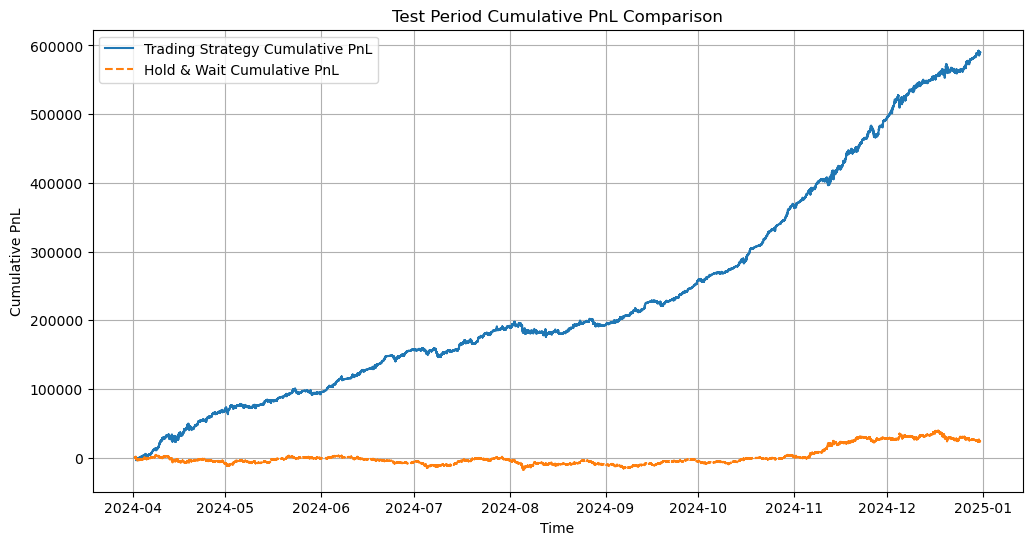

In [17]:
test_trading = test_df.copy()
test_trading['position'] = predicted_test.astype(float)
test_trading['pnl'] = test_trading['position'] * (test_trading['close'].shift(-1) - test_trading['close'])
test_trading = test_trading.dropna(subset=['pnl'])
test_trading['cumulative_pnl'] = test_trading['pnl'].cumsum()

# ----------------------------
# 2. Hold & Wait Strategy Simulation
# ----------------------------
test_hold = test_df.copy()
initial_price = test_hold['close'].iloc[0]
test_hold['pnl'] = test_hold['close'] - initial_price

plt.figure(figsize=(12, 6))
plt.plot(test_trading.index, test_trading['cumulative_pnl'], label='Trading Strategy Cumulative PnL')
plt.plot(test_hold.index, test_hold['pnl'], label='Hold & Wait Cumulative PnL', linestyle='--')
plt.xlabel('Time')
plt.ylabel('Cumulative PnL')
plt.title('Test Period Cumulative PnL Comparison')
plt.legend()
plt.grid(True)
plt.show()

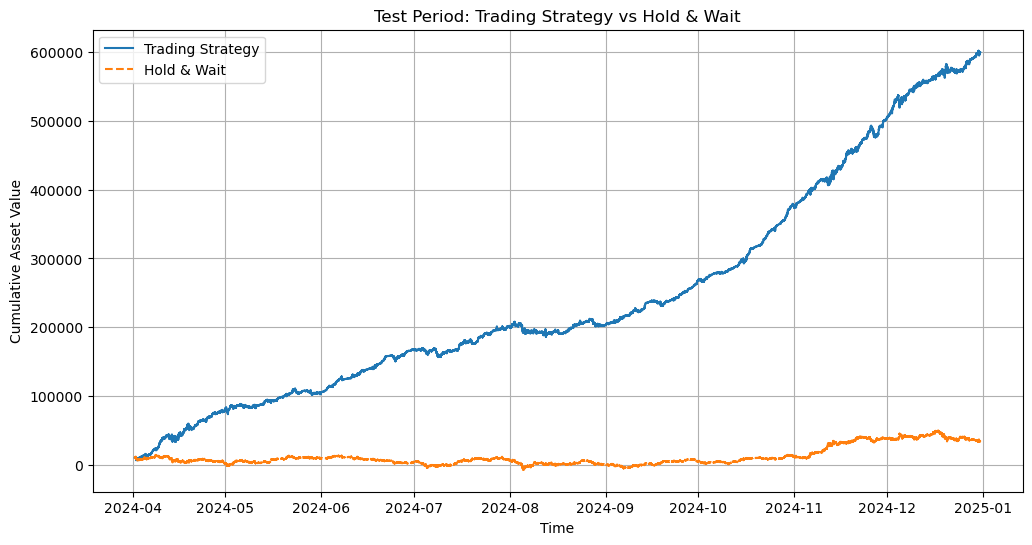

In [18]:
def simulate_trading(series_close, series_signal, initial_cash=10000, fee_rate=0.0002):
    """
    Simulate trading based on predicted signals.
    
    Parameters:
      series_close: pd.Series, asset close prices (indexed by time)
      series_signal: pd.Series, trading signals (predicted label, with values in {-2, -1, 0, 1, 2})
      initial_cash: initial cash amount (default 10000)
      fee_rate: transaction fee rate applied on both entry and exit
      
    Trading rule (per period):
      - If signal > 0: buy 'signal' units at current close, and sell at next period's close.
      - If signal < 0: short |signal| units at current close, and cover at next period's close.
      - If signal == 0: do nothing.
      
    Fee is applied on both the entry and exit transactions.
    
    Returns:
      time_index: index corresponding to each trade (using current period index)
      asset_values: list of cumulative asset values after each trade.
    """
    cash = initial_cash
    asset_values = []
    
    # Combine close prices and signals into a DataFrame
    df = pd.concat([series_close, series_signal], axis=1)
    df.columns = ["close", "Signal"]
    
    # We simulate trades from period 0 to period N-2 (since last period has no next close)
    for i in range(len(df) - 1):
        price = df["close"].iloc[i]
        signal = df["Signal"].iloc[i]
        # If signal is 0, no trade; asset value remains unchanged.
        if signal != 0:
            next_price = df["close"].iloc[i+1]
            # Compute trade value = abs(signal) * price
            trade_value_entry = abs(signal) * price
            fee_entry = trade_value_entry * fee_rate
            trade_value_exit = abs(signal) * next_price
            fee_exit = trade_value_exit * fee_rate
            # For a long trade (signal > 0): pnl = signal*(next_price - price) - fees
            # For a short trade (signal < 0): pnl = abs(signal)*(price - next_price) - fees
            if signal > 0:
                pnl = signal * (next_price - price) - fee_entry - fee_exit
            else:
                pnl = abs(signal) * (price - next_price) - fee_entry - fee_exit
            cash += pnl
        asset_values.append(cash)
    
    # For plotting purposes, use the index from period 0 to len(df)-1
    time_index = df.index[:-1]
    return time_index, asset_values

def simulate_hold(series_close, initial_cash=10000, fee_rate=0.0002):
    """
    Simulate a hold & wait strategy: buy 1 unit at the beginning and hold until the end.
    
    Parameters:
      series_close: pd.Series, asset close prices (indexed by time)
      initial_cash: initial cash (default 10000)
      fee_rate: transaction fee rate (applied on entry and exit)
      
    Returns:
      time_index: same as series_close index
      asset_values: cumulative asset values (cash + position * close price).
    """
    # Buy 1 unit at the first period
    initial_price = series_close.iloc[0]
    trade_value_entry = initial_price
    fee_entry = trade_value_entry * fee_rate
    # Cash after purchase:
    cash = initial_cash - (trade_value_entry + fee_entry)
    # Position is 1 unit
    position = 1
    asset_values = []
    for price in series_close:
        asset_value = cash + position * price
        asset_values.append(asset_value)
    return series_close.index, asset_values

# ----------------------------
# Using our test set and predicted label (predicted_test)
# ----------------------------
# For our simulation, ensure test_df has no NaN in 'close'
test_series_close = test_df['close']

# Simulate our trading strategy based on predicted signals
time_idx, strategy_asset = simulate_trading(test_series_close, predicted_test, initial_cash=10000, fee_rate=0.0)

# Simulate hold & wait strategy
hold_time_idx, hold_asset = simulate_hold(test_series_close, initial_cash=10000, fee_rate=0.0)

# Plot cumulative asset curves
plt.figure(figsize=(12, 6))
plt.plot(time_idx, strategy_asset, label='Trading Strategy')
plt.plot(hold_time_idx, hold_asset, label='Hold & Wait', linestyle='--')
plt.xlabel('Time')
plt.ylabel('Cumulative Asset Value')
plt.title('Test Period: Trading Strategy vs Hold & Wait')
plt.legend()
plt.grid(True)
plt.show()

## 5.4 Sub-Strategy C: De-Trending and Dynamic Threshold Adjustments

## Data Preparation

In [531]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
import seaborn as sns

import factors
import metrics
from metrics import evaluate_strategy, calculate_cumulative_asset
from trading_signal import long_short_strategy, vol_long_short_strategy


In [267]:
import importlib
import metrics

importlib.reload(metrics)
from metrics import evaluate_strategy, calculate_cumulative_asset

## Data Preparation

In [201]:
BTC = pd.read_pickle("data/cpt_5min/k_data/BTCUSD.pkl")

# Function to convert string columns to float
def convert_string_to_float(df):
    # Identify columns with string (object) data type
    string_columns = [col for col in df.columns if df[col].dtype == 'object']
    
    # Convert string columns to float where possible
    for col in string_columns:
        try:
            df[col] = pd.to_numeric(df[col], errors='coerce')  # Convert to float, set errors to NaN if conversion fails
        except Exception as e:
            print(f"Error converting column {col} to float: {e}")
    
    return df

# Convert string columns to float
BTC = convert_string_to_float(BTC)

In [ ]:
import importlib
import picture

importlib.reload(picture)

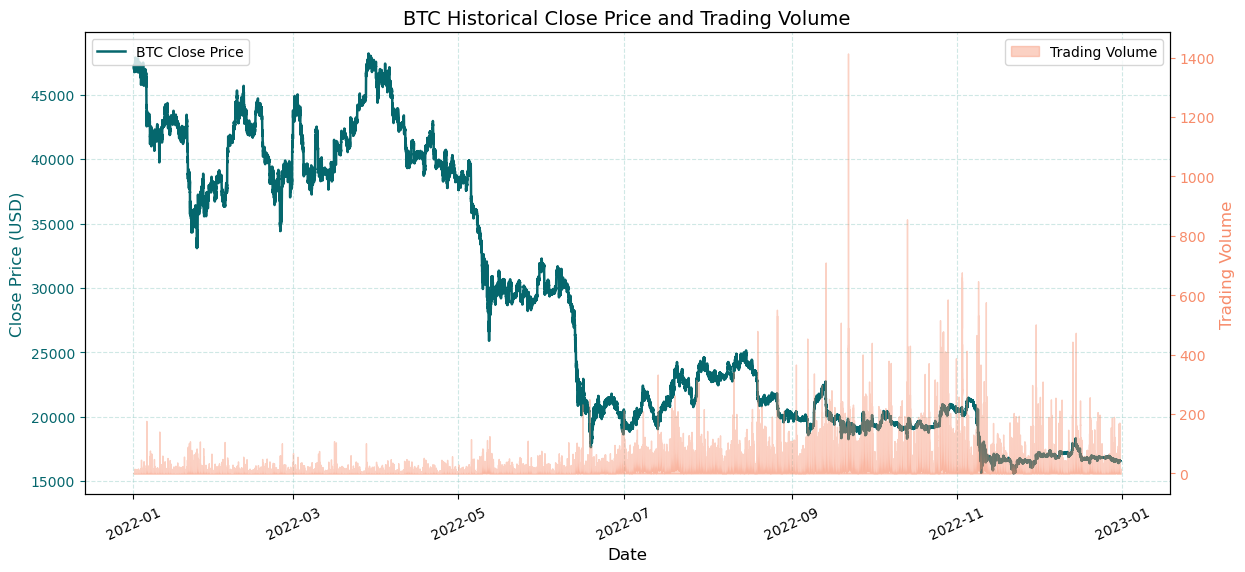

In [205]:
picture.plot_btc_price_and_volume(BTC)

This chart shows the historical **BTC closing price** (dark teal line) and **trading volume** (light orange bars) over the course of 2022. 

### Key Observations:
1. **Downward Trend in BTC Price**  
   - Bitcoin started the year around **$45,000** but saw a consistent **decline**, dropping below **$20,000** by mid-year and stabilizing around **$16,000 - $17,000** by year-end.
   - This downtrend aligns with **tightening monetary policy** by the U.S. Federal Reserve, including aggressive **interest rate hikes** to combat inflation, reducing liquidity in risk assets like BTC.

2. **Trading Volume Fluctuations**  
   - Early 2022 shows **low and stable** trading volumes.
   - A **significant increase** in trading activity is noticeable after May 2022, corresponding with **BTC's price collapse**.
   - This surge in volume may be linked to major **market events** such as:
     - **Terra (LUNA) collapse (May 2022)** A major DeFi crash that led to cascading liquidations.
     - **Celsius & 3AC Crisis (June-July 2022)** The insolvency of major crypto lenders, causing forced BTC liquidations.
     - **FTX Collapse (November 2022)** One of the biggest centralized crypto exchanges filed for bankruptcy, leading to panic selling.

3. **Market Stabilization Towards Year-End**  
   - BTC price remains relatively **stable from November onwards**, hovering around **$16,000 - $17,000**.
   - Trading volume, however, remains elevated compared to early 2022, possibly indicating **accumulation by institutional investors** or continued **market uncertainty**.

### Economic Context:  
- The **macro environment** in 2022 was extremely challenging for crypto assets due to:
  - **High inflation (CPI above 8%)**, forcing central banks to tighten monetary policy.
  - **Rising interest rates**, which made speculative assets like BTC less attractive.
  - **Strong U.S. dollar (DXY spike)**, which pressured BTC and other risk assets lower.
  - **Crypto-specific contagion**, reducing investor confidence in DeFi and centralized exchanges.

Overall, this chart captures **one of the most challenging years in BTC history**, characterized by **macro-driven selling, liquidity crises, and capitulation events** before a period of stabilization.

## Technique Indicator Analysis

In [215]:
start = "2022-01-01 06:00:00"
end = "2022-12-31 06:00:00"

df_indicators_notrend = factors.compute_technical_indicators(BTC, start, end)
df_indicators_notrend = factors.restructure_dataframe(df_indicators_notrend)

df_cleaned = df_indicators_notrend.dropna(axis=1, how="all") 
df_cleaned = df_cleaned.loc[:, df_cleaned.nunique() > 1]  

In [240]:
threshold = 10  # If a column has fewer than this number of unique values, treat it as categorical
categorical_columns = [col for col in df_cleaned.columns if df_cleaned[col].nunique() < threshold]
numerical_columns = [col for col in df_cleaned.columns if col not in categorical_columns]

These factors can include some numerical one and some categorical one. Let's check the numerical factors first.

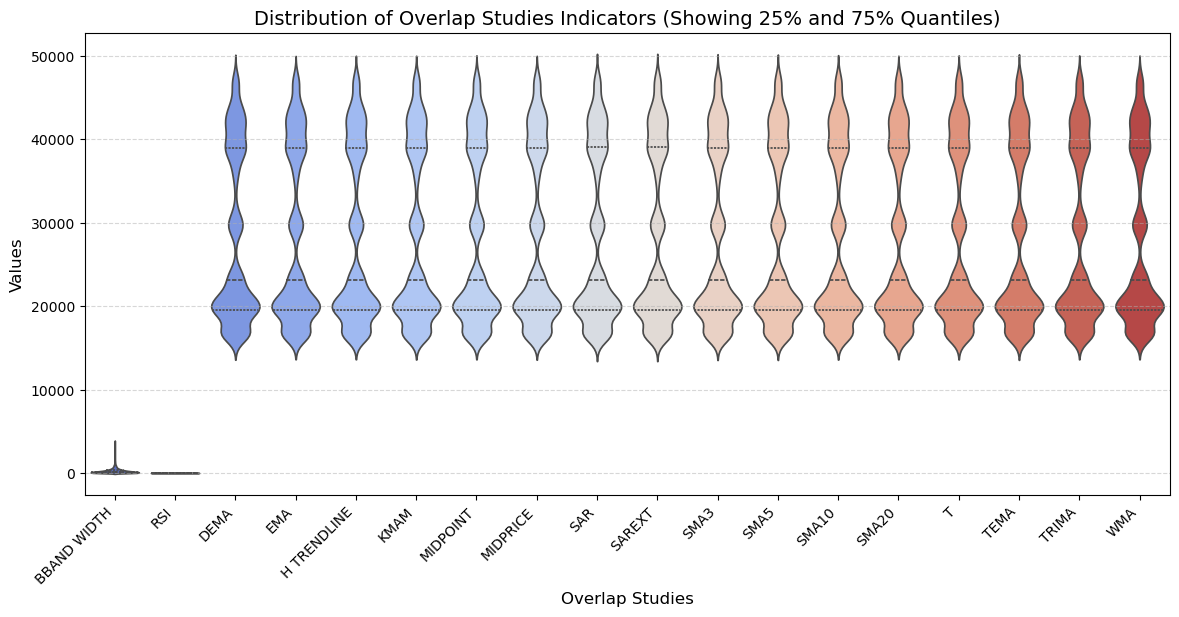

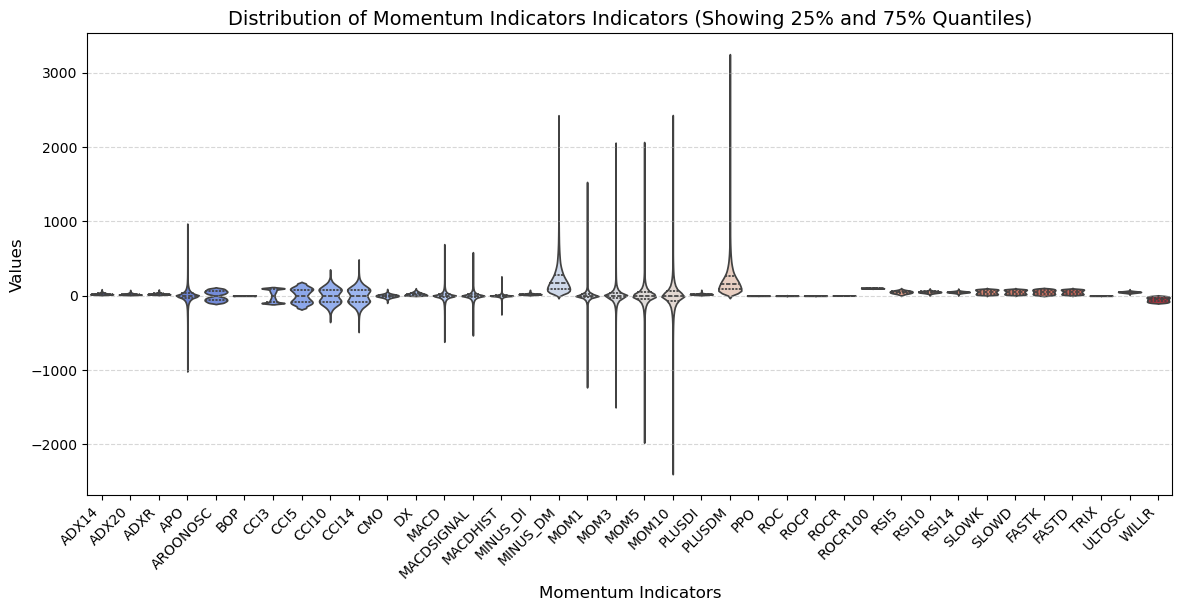

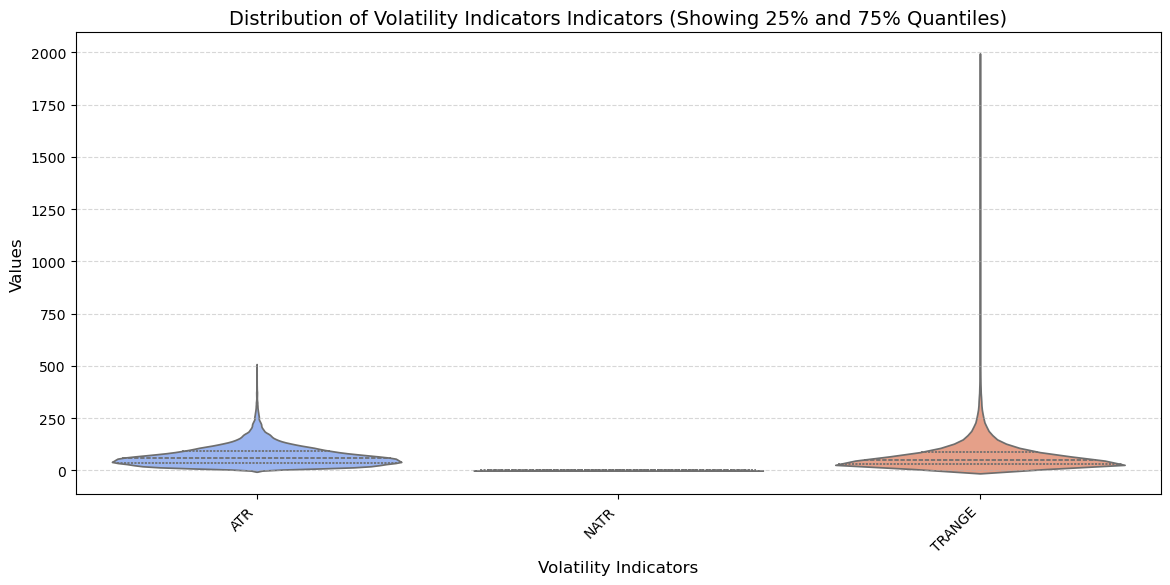

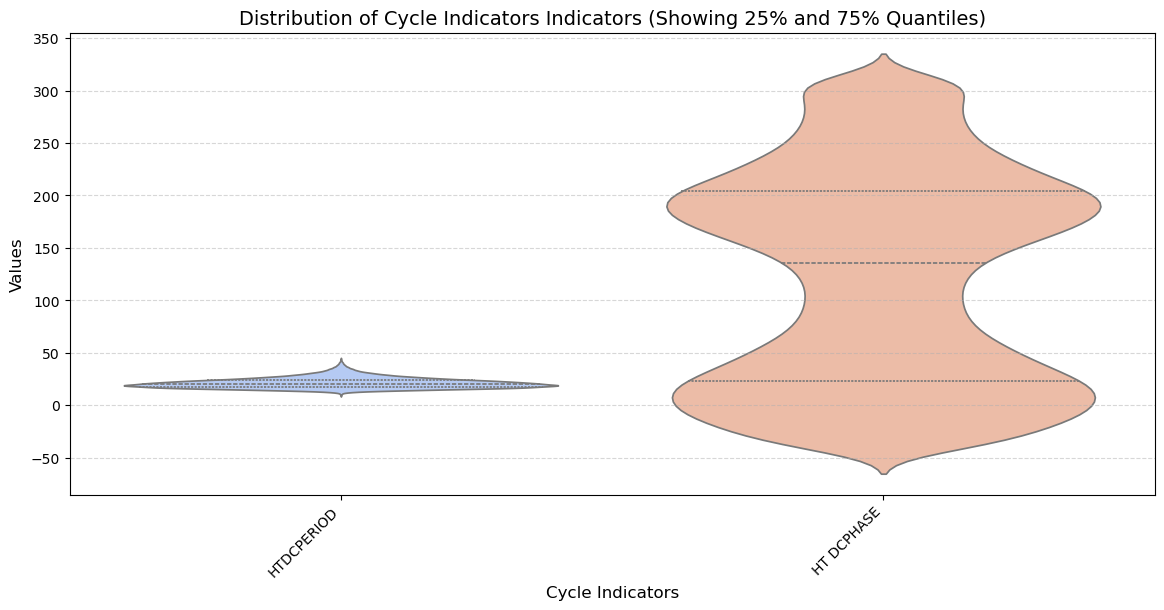

In [239]:
picture.plot_violin_by_category(df_cleaned)

These figures present the distribution of various financial indicators using violin plots. They showcase the spread, density, and quartiles of each indicator without any normalization applied. Heres a breakdown of each figure:

1. **Overlap Studies Indicators:**
   - These indicators include moving averages (SMA, EMA, TEMA, etc.) and Bollinger Band Width.
   - Most indicators exhibit a multi-modal distribution, indicating varied behavior over time.
   - The BBAND WIDTH indicator has a significantly lower range compared to others, possibly due to its nature in measuring volatility.

2. **Momentum Indicators:**
   - Includes indicators like RSI, MACD, ADX, and CCI.
   - Some indicators, such as MOM (Momentum), show high variance with long tails.
   - Many distributions are centered around zero, reflecting oscillatory characteristics of momentum indicators.

3. **Volatility Indicators:**
   - Includes ATR (Average True Range), NATR, and TRANGE.
   - ATR and TRANGE have wider distributions, indicating their responsiveness to price swings.
   - NATR shows a narrower spread, suggesting it maintains a relatively stable range.

4. **Cycle Indicators:**
   - HT_DCPERIOD and HT_DCPHASE are shown.
   - HT_DCPHASE has a much wider spread, reflecting phase shifts in cyclical analysis.
   - The different distributions suggest varying responses to market trends.

### Why No Normalization?
Normalization is intentionally avoided here to preserve raw data characteristics, ensuring accurate interpretation of indicator behaviors relative to their absolute values. Applying normalization could distort relationships and make direct comparisons with real-world market data more challenging.

Would you like a more detailed analysis of a specific indicator set?

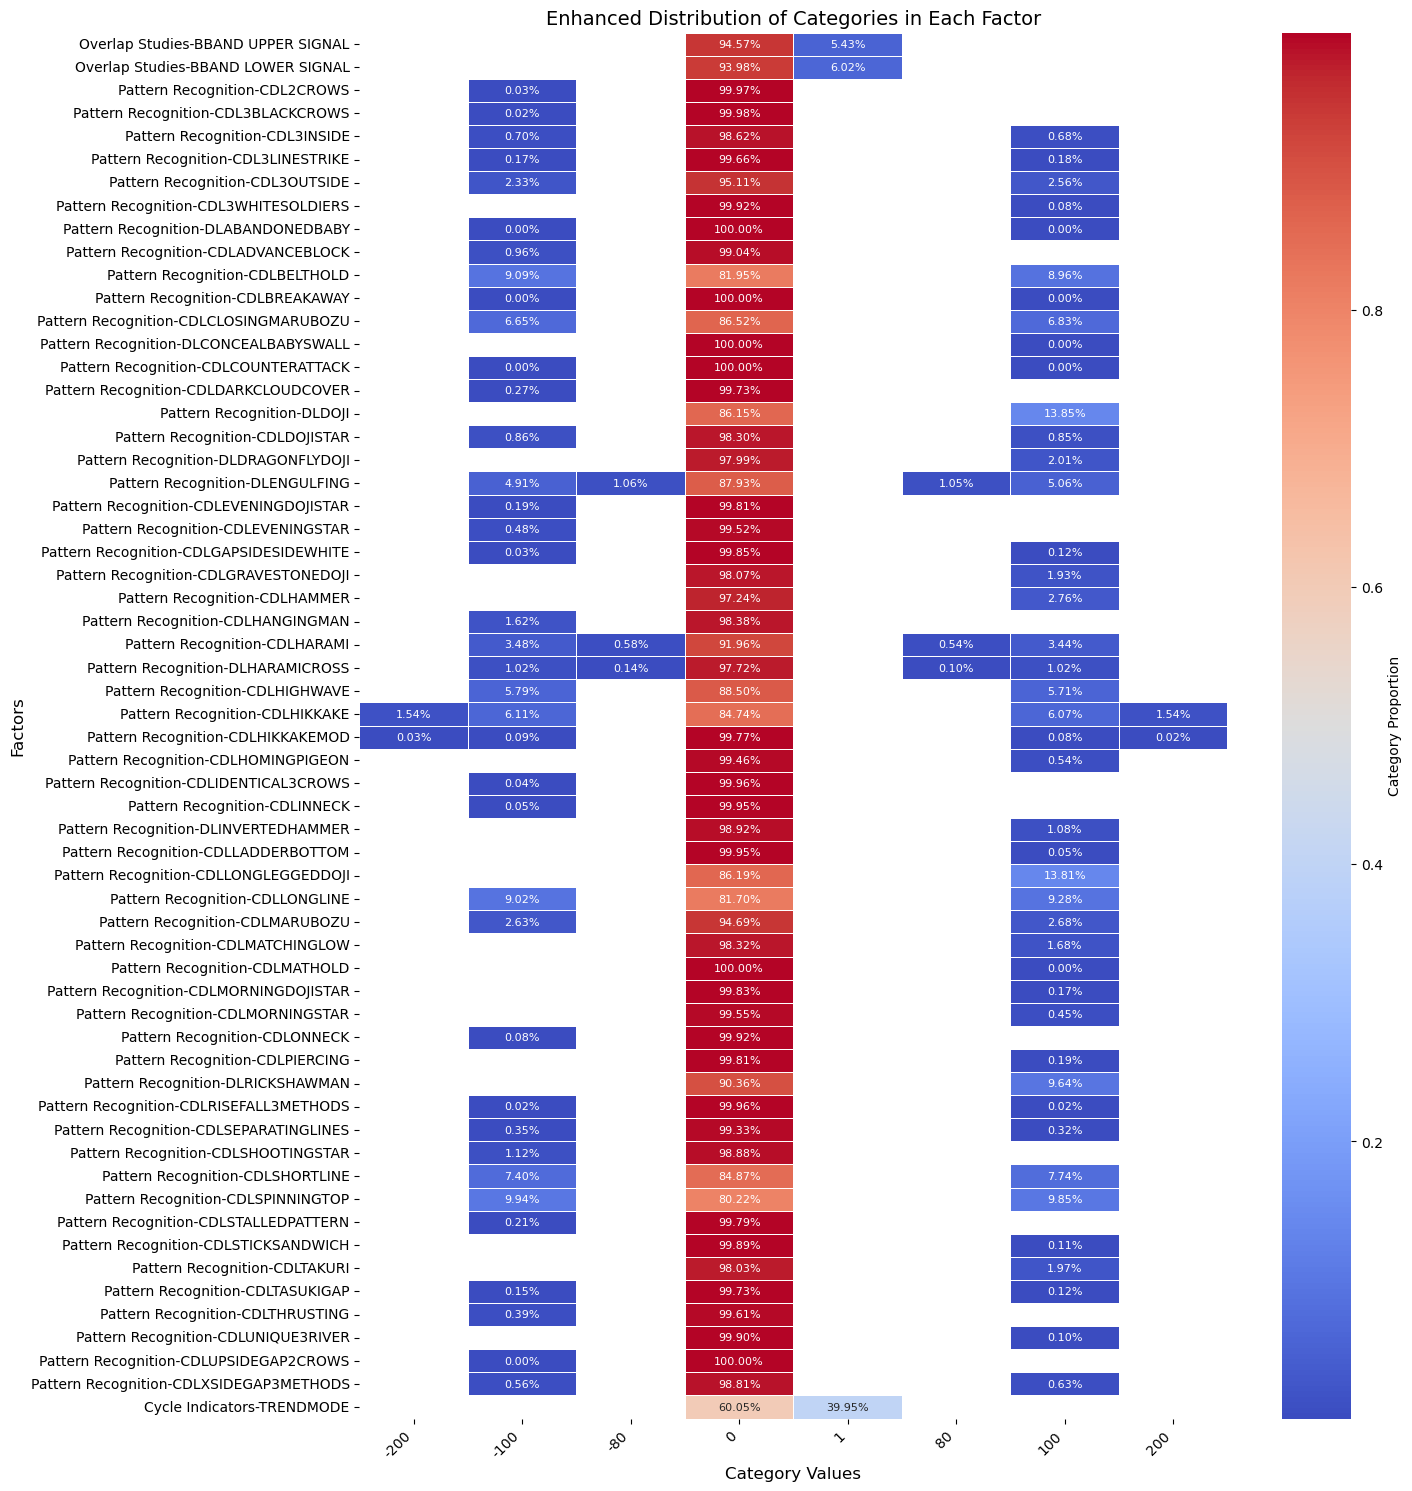

In [257]:
categorical_df = df_cleaned[categorical_columns]
picture.plot_category_distribution(categorical_df)


### Analysis

From this chart, we can see that the proportion of buy and sell signals for signal-type indicators is significantly lower than 25%, approximately around 1%. This will be taken into account when setting up buy and sell signals in the future.

## Correlation Analysis

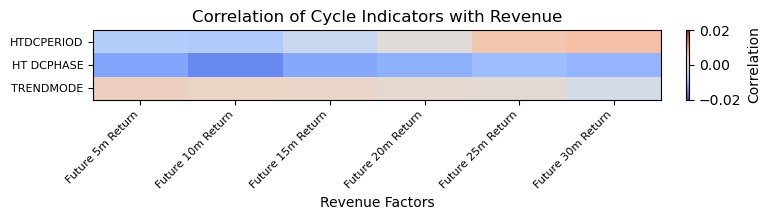

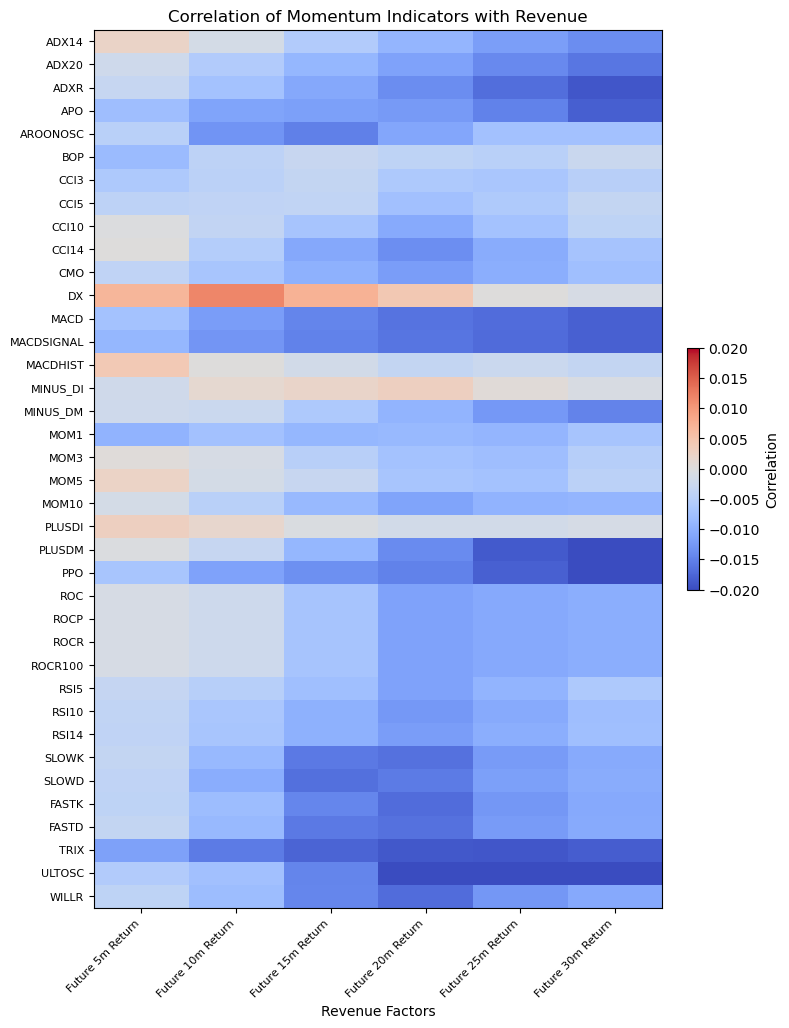

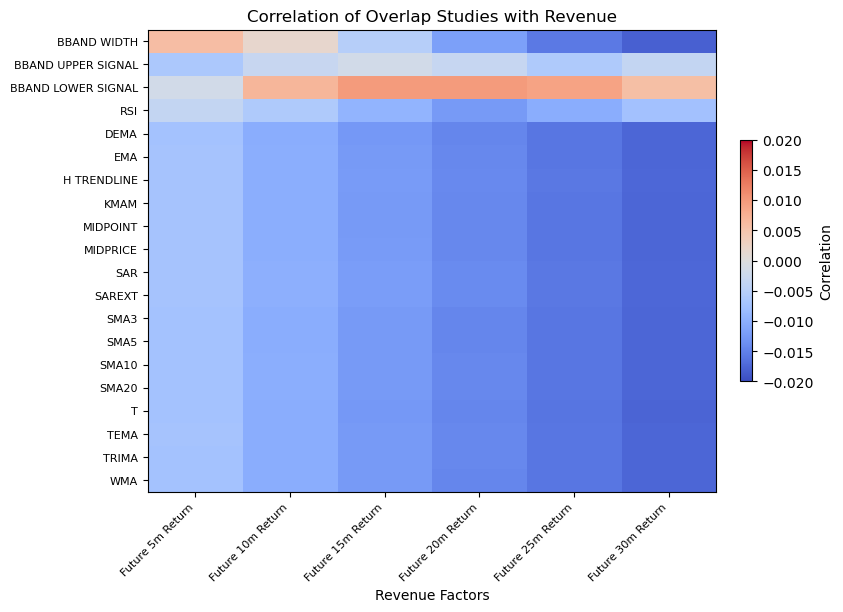

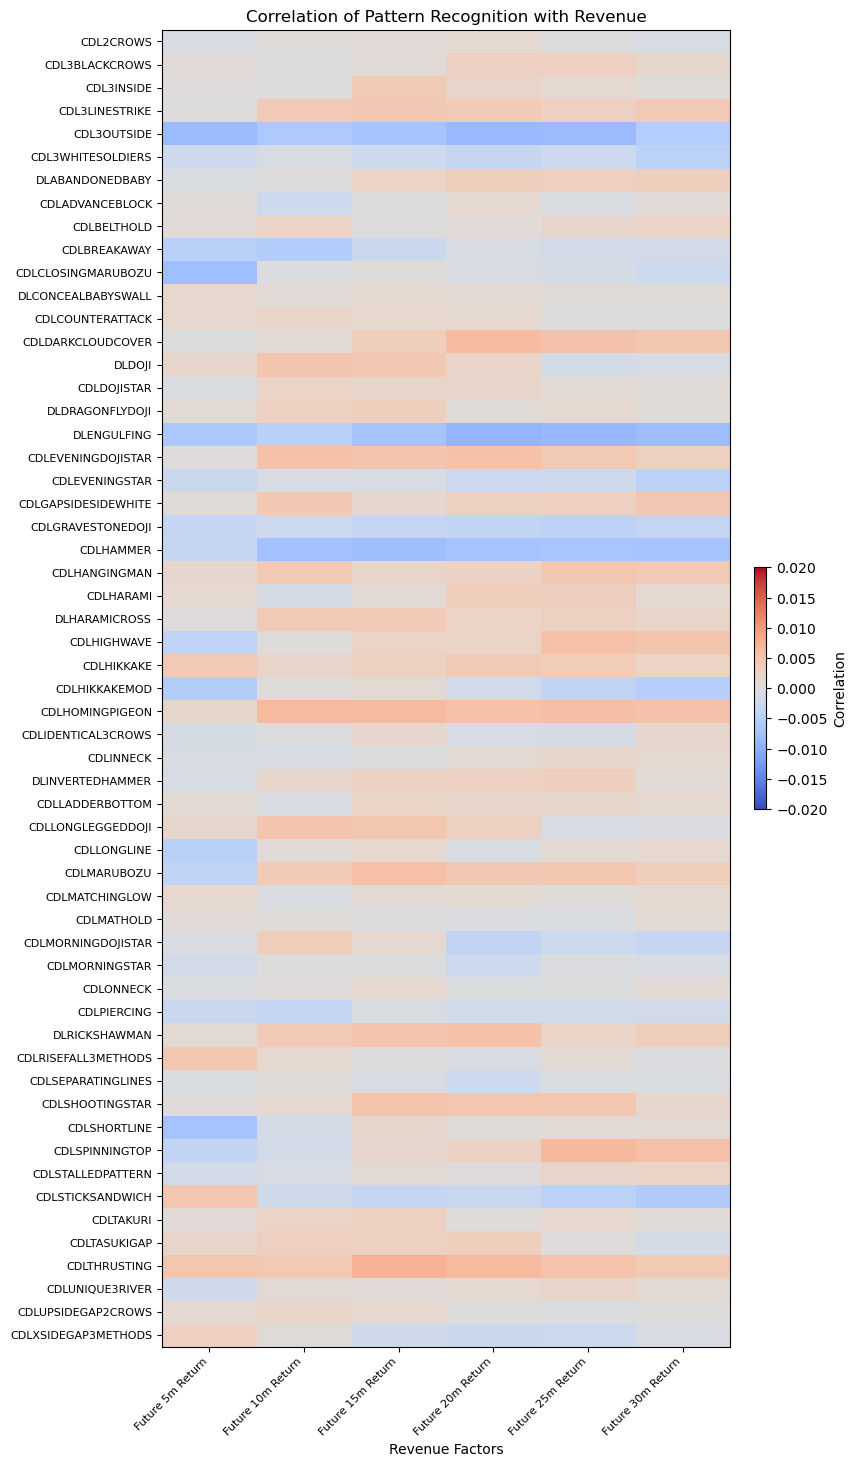

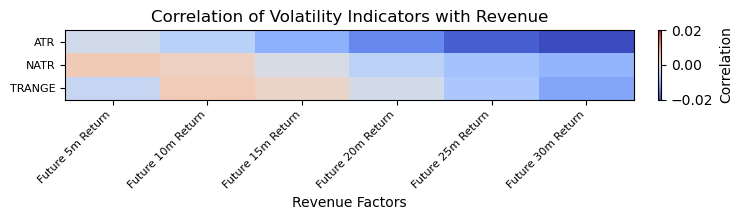

In [261]:
# Define the future return intervals
future_intervals = [5, 10, 15, 20, 25, 30]

# Compute future returns and store in a dictionary
future_returns = {
    f"Future {interval}m Return": BTC["close"].pct_change(periods=interval).shift(-interval) for interval in future_intervals
}

# Convert the dictionary to a DataFrame with MultiIndex columns
future_returns_df = pd.DataFrame(future_returns, index=BTC.index)
future_returns_df.columns = pd.MultiIndex.from_tuples([("Revenue", col) for col in future_returns_df.columns],
                                                      names=["Category", "Factor"])

# Concatenate the original DataFrame with the new future return columns
df_extended = pd.concat([df_cleaned, future_returns_df], axis=1)

# Compute correlation of all factors with each future return under the "Revenue" category
revenue_columns = [col for col in df_extended.columns if col[0] == "Revenue"]

# Compute correlation between factors and future returns
factor_correlations = df_extended.corr().loc[:, revenue_columns].drop(index=revenue_columns)

picture.plot_factor_correlation_heatmaps(factor_correlations)

From the correlation heatmaps, we can observe that most indicators within a given category tend to exhibit a similar correlation direction with future returns. Heres why this might be happening:

1. **Overlap Studies (Moving Averages, Bollinger Bands, etc.):**  
   - Most moving averages (SMA, EMA, WMA, etc.) have similar correlation patterns because they are all smoothing indicators that capture trends. When price trends persist, these indicators generally align in their directional movement.
   - Bollinger Bands show a different correlation direction because they measure volatility rather than trend persistence. The BBAND WIDTH and BBAND SIGNAL indicators capture price dispersion, which may have a different impact on returns compared to trend-following indicators.

2. **Momentum Indicators (MACD, RSI, CCI, etc.):**  
   - Many momentum indicators show the same correlation direction because they are designed to capture the strength and speed of price movements. If momentum is a leading indicator of trend continuation, it will show a consistent correlation with future returns.
   - Some indicators, such as MACD and RSI, may show different correlation directions due to their distinct methodologies. RSI measures overbought&oversold conditions, while MACD focuses on moving average convergence&divergence, which can signal different phases of price movements.

3. **Volatility Indicators (ATR, NATR, TRANGE):**  
   - Volatility-based indicators generally exhibit similar correlation directions, as they track market uncertainty and fluctuations. Increased volatility often correlates with stronger price movements, influencing all indicators in the same way.
   - However, some indicators like TRANGE (True Range) may have different correlations because they focus on extreme price movements, which might not always translate directly into future returns.

4. **Cycle Indicators (HT_DCPERIOD, HT_DCPHASE, TRENDMODE):**  
   - These indicators focus on cyclical behavior in prices, leading to similar correlation patterns. If price cycles align with return timing, these indicators will show consistent directional correlations.
   - Differences among them arise because some cycle indicators measure phase shifts (HT_DCPHASE), while others track dominant cycle periods (HT_DCPERIOD), leading to variations in correlation.

5. **Pattern Recognition Indicators:**  
   - Most of these indicators capture common candlestick patterns, so they tend to correlate in the same direction when certain patterns indicate trend continuation or reversal.
   - However, variations occur because different patterns have different implicationssome signal bullish reversals, while others indicate bearish trends, leading to mixed correlation directions.

From the correlation heatmaps, we can observe that most indicators within a given category tend to exhibit a similar correlation direction with future returns. Heres why this might be happening:

1. **Overlap Studies (Moving Averages, Bollinger Bands, etc.):**  
   - Most moving averages (SMA, EMA, WMA, etc.) have similar correlation patterns because they are all smoothing indicators that capture trends. When price trends persist, these indicators generally align in their directional movement.
   - Bollinger Bands show a different correlation direction because they measure volatility rather than trend persistence. The BBAND WIDTH and BBAND SIGNAL indicators capture price dispersion, which may have a different impact on returns compared to trend-following indicators.

2. **Momentum Indicators (MACD, RSI, CCI, etc.):**  
   - Many momentum indicators show the same correlation direction because they are designed to capture the strength and speed of price movements. If momentum is a leading indicator of trend continuation, it will show a consistent correlation with future returns.
   - Some indicators, such as MACD and RSI, may show different correlation directions due to their distinct methodologies. RSI measures overbought&oversold conditions, while MACD focuses on moving average convergence&divergence, which can signal different phases of price movements.

3. **Volatility Indicators (ATR, NATR, TRANGE):**  
   - Volatility-based indicators generally exhibit similar correlation directions, as they track market uncertainty and fluctuations. Increased volatility often correlates with stronger price movements, influencing all indicators in the same way.
   - However, some indicators like TRANGE (True Range) may have different correlations because they focus on extreme price movements, which might not always translate directly into future returns.

4. **Cycle Indicators (HT_DCPERIOD, HT_DCPHASE, TRENDMODE):**  
   - These indicators focus on cyclical behavior in prices, leading to similar correlation patterns. If price cycles align with return timing, these indicators will show consistent directional correlations.
   - Differences among them arise because some cycle indicators measure phase shifts (HT_DCPHASE), while others track dominant cycle periods (HT_DCPERIOD), leading to variations in correlation.

5. **Pattern Recognition Indicators:**  
   - Most of these indicators capture common candlestick patterns, so they tend to correlate in the same direction when certain patterns indicate trend continuation or reversal.
   - However, variations occur because different patterns have different implications some signal bullish reversals, while others indicate bearish trends, leading to mixed correlation directions.

## Indicator Test

Based on the analysis in **Strategy 1**, we concluded that directly using raw factor values for model learning leads to excessively frequent position openings, which are not sufficient to cover transaction costs. Therefore, in this approach, all numerical indicators are converted into trading signals.  

### **Trading Signal Generation Strategy:**  
- **Quantile-based Thresholds:**  
  - A factor is considered **high** if it is above the **75th percentile (upper quantile)** **Buy signal (1)**  
  - A factor is considered **low** if it is below the **25th percentile (lower quantile)** **Sell signal (-1)**  
  - Values between these thresholds result in a **neutral signal (0)**  

- **Correlation Adjustment:**  
  - If a factor has a **negative correlation** with returns, the signal direction is inverted to maintain the correct predictive relationship.

This transformation ensures a more structured and interpretable signal-based approach, reducing unnecessary trades and improving robustness against transaction costs.

In [288]:
# Create dictionaries to store trading signals
trading_signals_numerical = {}
trading_signals_categorical = {}

# Define quantile thresholds for numerical data
upper_quantile = 0.75  # High value threshold
lower_quantile = 0.25  # Low value threshold

# Define target revenue factor for signal generation
target_revenue_factor = ("Revenue", "Future 5m Return")

# Extract relevant correlations
if target_revenue_factor in factor_correlations.columns:
    target_correlations = factor_correlations[target_revenue_factor]
else:
    raise ValueError("Future 5m Return column not found in factor_correlations.")

# Process numerical columns
for (category, factor_name), corr_value in target_correlations.items():
    if (category, factor_name) in df_extended[numerical_columns].columns:
        factor_values = df_extended[(category, factor_name)]

        # Compute quantiles
        upper_threshold = factor_values.quantile(upper_quantile)
        lower_threshold = factor_values.quantile(lower_quantile)

        # Assign signals: 1 for buy, -1 for sell, 0 for neutral
        signal = np.where(
            factor_values > upper_threshold, 1,  # Buy signal
            np.where(factor_values < lower_threshold, -1, 0)  # Sell and Neutral signals
        )

        # Adjust signal direction based on correlation sign
        if corr_value < 0:
            signal = -signal  # Invert signal if correlation is negative

        trading_signals_numerical[(category, factor_name)] = signal

# Process categorical columns
for (category, factor_name), corr_value in target_correlations.items():
    if (category, factor_name) in df_extended[categorical_columns].columns:
        factor_values = df_extended[(category, factor_name)]

        # Get unique values and count
        unique_vals_sorted = sorted(factor_values.dropna().unique())
        unique_count = len(unique_vals_sorted)

        # Assign signals based on unique count
        if unique_count == 2:
            signal_map = {unique_vals_sorted[0]: 0, unique_vals_sorted[1]: 1}
        elif unique_count == 3:
            signal_map = {unique_vals_sorted[0]: 0, unique_vals_sorted[1]: 1, unique_vals_sorted[2]: -1}
        elif unique_count == 5:
            signal_map = {unique_vals_sorted[0]: 0, unique_vals_sorted[1]: 1, unique_vals_sorted[2]: -1,
                          unique_vals_sorted[3]: 1, unique_vals_sorted[4]: -1}
        else:
            signal_map = {val: 0 for val in unique_vals_sorted}  # Default neutral mapping for unsupported cases

        signal = factor_values.map(signal_map).fillna(0)
        
        if corr_value < 0:
            signal = -signal  # Invert signal if correlation is negative

        trading_signals_categorical[(category, factor_name)] = signal

# Convert dictionaries to DataFrames with MultiIndex columns
trading_signals_numerical_df = pd.DataFrame(trading_signals_numerical, index=df_extended.index)
trading_signals_numerical_df.columns = pd.MultiIndex.from_tuples(trading_signals_numerical_df.columns, names=["Category", "Factor"])

trading_signals_categorical_df = pd.DataFrame(trading_signals_categorical, index=df_extended.index)
trading_signals_categorical_df.columns = pd.MultiIndex.from_tuples(trading_signals_categorical_df.columns, names=["Category", "Factor"])


In [290]:
# Create dictionaries to store evaluation metrics for numerical and categorical factors
strategy_evaluation_results_numerical = {}
strategy_evaluation_results_categorical = {}

# Evaluate numerical factor strategies
for (category, factor_name) in trading_signals_numerical_df.columns:
    # Get the trading signal series for the factor
    series_position_long_short = long_short_strategy(trading_signals_numerical_df[category][factor_name])

    # Calculate the cumulative asset value
    df_result = calculate_cumulative_asset(BTC["close"], series_position_long_short)

    # Evaluate the strategy and store results
    evaluation_metrics = evaluate_strategy(df_result, risk_free_rate=0.0)
    strategy_evaluation_results_numerical[(category, factor_name)] = evaluation_metrics

# Evaluate categorical factor strategies
for (category, factor_name) in trading_signals_categorical_df.columns:
    # Get the trading signal series for the factor
    series_position_long_short = long_short_strategy(trading_signals_categorical_df[category][factor_name])

    # Calculate the cumulative asset value
    df_result = calculate_cumulative_asset(BTC["close"], series_position_long_short)

    # Evaluate the strategy and store results
    evaluation_metrics = evaluate_strategy(df_result, risk_free_rate=0.0)
    strategy_evaluation_results_categorical[(category, factor_name)] = evaluation_metrics

# Convert the results dictionaries into structured DataFrames
evaluation_results_numerical_df = pd.DataFrame(strategy_evaluation_results_numerical).T
evaluation_results_numerical_df.columns = ["Sharpe Ratio", "Max Drawdown (%)", "Holding Win Rate (%)", 
                                           "Trading Win Rate (%)", "Final Cumulative Return (%)", "Turnover (%)"]

evaluation_results_categorical_df = pd.DataFrame(strategy_evaluation_results_categorical).T
evaluation_results_categorical_df.columns = ["Sharpe Ratio", "Max Drawdown (%)", "Holding Win Rate (%)", 
                                             "Trading Win Rate (%)", "Final Cumulative Return (%)", "Turnover (%)"]


In [342]:
# Select the top 10 factors based on Sharpe Ratio
top_20_factors_numerical = evaluation_results_numerical_df.sort_values(by="Sharpe Ratio", ascending=False).head(20)
top_20_factors_numerical

Sharpe Ratio  Max Drawdown (%)  \
Overlap Studies       H TRENDLINE      2.495689        -24.055384   
                      T                2.470512        -23.683610   
                      MIDPOINT         2.332384        -23.455288   
                      TRIMA            2.294144        -23.455288   
                      SMA20            2.278976        -23.390786   
                      TEMA             2.255501        -22.803466   
                      MIDPRICE         2.251318        -23.390786   
                      EMA              2.243361        -23.455288   
                      SMA3             2.229107        -23.447543   
                      SMA5             2.190656        -23.447543   
                      WMA              2.181935        -23.481495   
                      SMA10            2.181728        -23.525470   
                      KMAM             2.175004        -23.443410   
                      DEMA             2.169536        -22.794168   
                      SAREXT           1.919176        -23.130396   
                      SAR              1.908872        -23.033969   
Cycle Indicators      HT DCPHASE       0.791504        -24.559987   
Volatility Indicators ATR              0.750703        -28.449130   
Momentum Indicators   TRIX             0.568906        -31.213689   
                      MACD             0.034507        -44.857709   

                                   Holding Win Rate (%)  Trading Win Rate (%)  \
Overlap Studies       H TRENDLINE             25.071785             98.333333   
                      T                       25.065107             90.625000   
                      MIDPOINT                25.109943             98.734177   
                      TRIMA                   25.084186             95.774648   
                      SMA20                   25.090864             97.014925   
                      TEMA                    25.139516             98.373984   
                      MIDPRICE                25.105173             92.771084   
                      EMA                     25.093726            100.000000   
                      SMA3                    25.197707             97.076023   
                      SMA5                    25.154779             93.893130   
                      WMA                     25.093726            100.000000   
                      SMA10                   25.116621             98.901099   
                      KMAM                    25.108035            100.000000   
                      DEMA                    25.122344             97.849462   
                      SAREXT                  25.132838             63.285024   
                      SAR                     25.133792             63.285024   
Cycle Indicators      HT DCPHASE              28.319994             41.152093   
Volatility Indicators ATR                     25.790111             45.677123   
Momentum Indicators   TRIX                    25.752907             66.912540   
                      MACD                    27.298311             73.371105   

                                   Final Cumulative Return (%)  Turnover (%)  
Overlap Studies       H TRENDLINE                   165.492128    523.820000  
                      T                             162.162571    523.560000  
                      MIDPOINT                      147.063026    524.040000  
                      TRIMA                         144.084052    524.040000  
                      SMA20                         141.920428    524.040000  
                      TEMA                          138.804410    523.860000  
                      MIDPRICE                      138.557510    524.010000  
                      EMA                           138.890931    524.040000  
                      SMA3                          136.171666    524.120000  
                      SMA5                          132.699156    524.120000  
              

In [343]:
# Select the top 10 factors based on Sharpe Ratio
top_20_factors_categorical = evaluation_results_categorical_df.sort_values(by="Sharpe Ratio", ascending=False).head(20)
top_20_factors_categorical

Sharpe Ratio  Max Drawdown (%)  \
Overlap Studies     BBAND UPPER SIGNAL      3.354839         -6.739396   
Pattern Recognition CDLCLOSINGMARUBOZU      1.935578        -37.208375   
                    CDLBREAKAWAY            1.914921        -24.714792   
                    DLABANDONEDBABY         1.798368        -24.714792   
                    CDLLONGLINE             1.533658        -38.448186   
                    CDL2CROWS               1.493387        -31.990233   
                    CDL3LINESTRIKE          1.488946        -31.505439   
                    CDL3OUTSIDE             1.486242        -36.645452   
                    CDLINNECK               1.472634        -35.831057   
                    CDLEVENINGSTAR          1.390386        -36.433990   
                    CDLSTALLEDPATTERN       1.383455        -36.478136   
                    CDLONNECK               1.370551        -36.787952   
                    CDLDOJISTAR             1.341785        -38.704242   
                    CDLIDENTICAL3CROWS      1.339107        -38.385729   
                    CDLDARKCLOUDCOVER       1.301665        -38.780478   
                    DLHARAMICROSS           1.195143        -36.182583   
                    CDLSEPARATINGLINES      1.158303        -37.501385   
                    CDLHIKKAKE              1.057616        -38.216888   
                    CDLHIGHWAVE             1.021758        -38.841757   
                    CDLHARAMI               0.983032        -36.958865   

                                        Holding Win Rate (%)  \
Overlap Studies     BBAND UPPER SIGNAL              5.825789   
Pattern Recognition CDLCLOSINGMARUBOZU             52.620985   
                    CDLBREAKAWAY                   49.975674   
                    DLABANDONEDBABY                49.973766   
                    CDLLONGLINE                    52.970132   
                    CDL2CROWS                      49.987122   
                    CDL3LINESTRIKE                 50.065346   
                    CDL3OUTSIDE                    50.912456   
                    CDLINNECK                      50.002385   
                    CDLEVENINGSTAR                 50.238011   
                    CDLSTALLEDPATTERN              50.068208   
                    CDLONNECK                      49.978536   
                    CDLDOJISTAR                    50.384920   
                    CDLIDENTICAL3CROWS             49.995707   
                    CDLDARKCLOUDCOVER              50.098734   
                    DLHARAMICROSS                  49.919391   
                    CDLSEPARATINGLINES             50.139754   
                    CDLHIKKAKE                     50.716895   
                    CDLHIGHWAVE                    49.995707   
                    CDLHARAMI                      50.938212   

                                        Trading Win Rate (%)  \
Overlap Studies     BBAND UPPER SIGNAL             62.475182   
Pattern Recognition CDLCLOSINGMARUBOZU             53.502894   
                    CDLBREAKAWAY                  100.000000   
                    DLABANDONEDBABY               100.000000   
                    CDLLONGLINE                    52.561475   
                    CDL2CROWS                      64.516129   
                    CDL3LINESTRIKE                 51.724138   
                    CDL3OUTSIDE                    54.229669   
                    CDLINNECK                      50.943396   
                    CDLEVENINGSTAR                 51.084813   
                    CDLSTALLEDPATTERN              51.555556   
                    CDLONNECK                      54.022989   
                    CDLDOJISTAR                    46.376812   
                    CDLIDENTICAL3CROWS             52.777778   
                    CDLDARKCLOUDCOVER              49.116608   
                    DLHARAMICROSS                  47.235239   
                    CDLSEPARATINGLINES             5

In [354]:
top_20_factors_index_categorical = top_20_factors_categorical.index
top_20_factors_index_numerical = top_20_factors_numerical.index

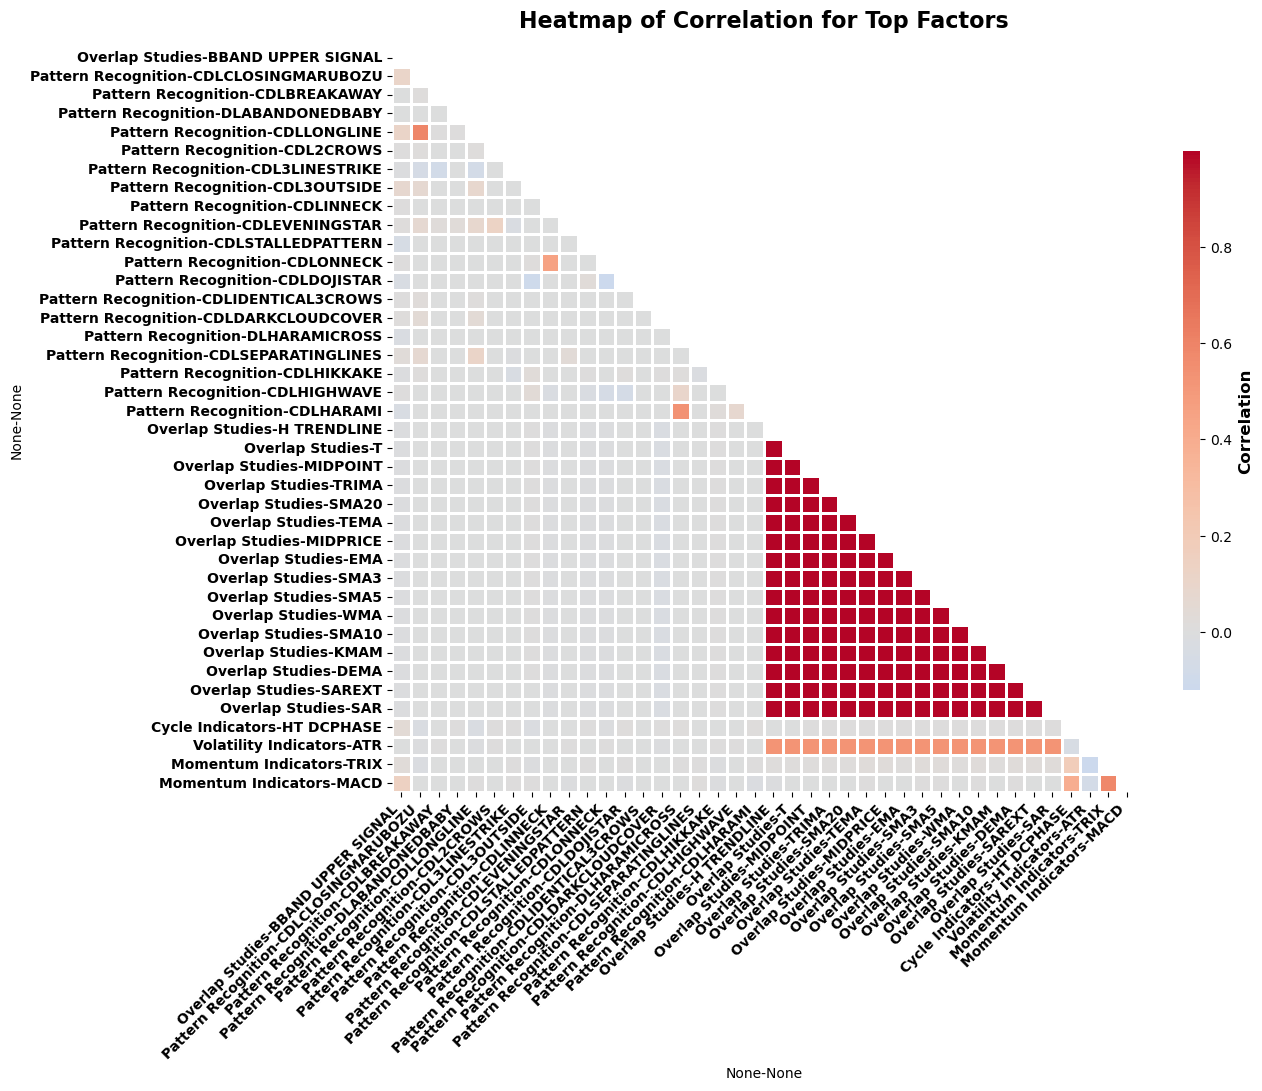

In [346]:
top_factors_corr = picture.plot_top_factors_correlation(df_extended, top_20_factors_index_categorical, top_20_factors_index_numerical)

From this heatmap, we can see that some **indicators have very high correlations** (close to 1), especially among **Overlap Studies** and certain **Pattern Recognition** factors. This suggests a **multicollinearity issue** where redundant factors provide overlapping information.  

### **Key Issues:**
- High correlation means these indicators likely convey **similar signals**, leading to **redundant features** that do not improve predictive power.
- For example, multiple **SMA, EMA, and WMA indicators** are highly correlated, potentially making some of them unnecessary.
- Certain **Pattern Recognition indicators** (e.g., **CDLLONGLINE, CDLENGULFING**) are strongly correlated, which could result in excessive trading signals.

### **Possible Solutions:**
1. **Set a correlation threshold** (e.g., `|corr| > 0.7`) to identify redundant factors.  
2. **Remove highly correlated factors**, keeping only the most informative ones (e.g., selecting the most volatile or representative indicator).  
3. **Apply PCA or hierarchical clustering** to reduce dimensionality while retaining meaningful information.  

Filtering out highly correlated indicators can **increase signal diversity**, **reduce overfitting**, and improve strategy robustness. 

In [347]:
top_factors_df = pd.concat([top_20_factors_categorical, top_20_factors_numerical], axis=0)
top_factors_df = top_factors_df.sort_values(by="Sharpe Ratio", ascending=False)

In [348]:
top_factors_index = top_factors_df.index
# Set to store factors that should be removed
factors_to_remove = set()

# Iterate over the correlation matrix to find highly correlated factors
for i in range(len(top_factors_index)):
    for j in range(i + 1, len(top_factors_index)):
        factor1 = top_factors_index[i]
        factor2 = top_factors_index[j]

        # If correlation is greater than 0.7, remove the lower-ranked factor
        if top_factors_corr.loc[factor1, factor2] > 0.7:
            factors_to_remove.add(factor2)

# Filter the top factors index to exclude highly correlated ones
filtered_top_factors_index = [factor for factor in top_factors_index if factor not in factors_to_remove]

In [359]:
# Find common columns between filtered_top_factors_index and top_30_factors_numerical
common_columns = list(set(filtered_top_factors_index) & set(top_20_factors_index_numerical))

# Select only the common columns
top_factors_numerical_filtered = top_20_factors_numerical.loc[common_columns]

top_factors_numerical_filtered

Sharpe Ratio  Max Drawdown (%)  \
Overlap Studies       H TRENDLINE      2.495689        -24.055384   
Momentum Indicators   MACD             0.034507        -44.857709   
                      TRIX             0.568906        -31.213689   
Volatility Indicators ATR              0.750703        -28.449130   
Cycle Indicators      HT DCPHASE       0.791504        -24.559987   

                                   Holding Win Rate (%)  Trading Win Rate (%)  \
Overlap Studies       H TRENDLINE             25.071785             98.333333   
Momentum Indicators   MACD                    27.298311             73.371105   
                      TRIX                    25.752907             66.912540   
Volatility Indicators ATR                     25.790111             45.677123   
Cycle Indicators      HT DCPHASE              28.319994             41.152093   

                                   Final Cumulative Return (%)  Turnover (%)  
Overlap Studies       H TRENDLINE                   165.492128        523.82  
Momentum Indicators   MACD                          -13.831933        523.98  
                      TRIX                           17.518400        523.70  
Volatility Indicators ATR                            28.420640        524.06  
Cycle Indicators      HT DCPHASE                     29.881191        523.82

In [360]:
# Find common columns between filtered_top_factors_index and top_30_factors_numerical
common_columns = list(set(filtered_top_factors_index) & set(top_20_factors_index_categorical))

# Select only the common columns
top_factors_categorical_filtered = top_20_factors_categorical.loc[common_columns]

top_factors_categorical_filtered

Sharpe Ratio  Max Drawdown (%)  \
Pattern Recognition CDLDARKCLOUDCOVER       1.301665        -38.780478   
Overlap Studies     BBAND UPPER SIGNAL      3.354839         -6.739396   
Pattern Recognition CDLINNECK               1.472634        -35.831057   
                    DLABANDONEDBABY         1.798368        -24.714792   
                    CDLHIGHWAVE             1.021758        -38.841757   
                    CDLIDENTICAL3CROWS      1.339107        -38.385729   
                    CDLDOJISTAR             1.341785        -38.704242   
                    CDLSEPARATINGLINES      1.158303        -37.501385   
                    CDLEVENINGSTAR          1.390386        -36.433990   
                    CDLSTALLEDPATTERN       1.383455        -36.478136   
                    CDL3OUTSIDE             1.486242        -36.645452   
                    CDLHARAMI               0.983032        -36.958865   
                    CDLCLOSINGMARUBOZU      1.935578        -37.208375   
                    CDLHIKKAKE              1.057616        -38.216888   
                    CDLLONGLINE             1.533658        -38.448186   
                    CDL3LINESTRIKE          1.488946        -31.505439   
                    DLHARAMICROSS           1.195143        -36.182583   
                    CDL2CROWS               1.493387        -31.990233   
                    CDLBREAKAWAY            1.914921        -24.714792   
                    CDLONNECK               1.370551        -36.787952   

                                        Holding Win Rate (%)  \
Pattern Recognition CDLDARKCLOUDCOVER              50.098734   
Overlap Studies     BBAND UPPER SIGNAL              5.825789   
Pattern Recognition CDLINNECK                      50.002385   
                    DLABANDONEDBABY                49.973766   
                    CDLHIGHWAVE                    49.995707   
                    CDLIDENTICAL3CROWS             49.995707   
                    CDLDOJISTAR                    50.384920   
                    CDLSEPARATINGLINES             50.139754   
                    CDLEVENINGSTAR                 50.238011   
                    CDLSTALLEDPATTERN              50.068208   
                    CDL3OUTSIDE                    50.912456   
                    CDLHARAMI                      50.938212   
                    CDLCLOSINGMARUBOZU             52.620985   
                    CDLHIKKAKE                     50.716895   
                    CDLLONGLINE                    52.970132   
                    CDL3LINESTRIKE                 50.065346   
                    DLHARAMICROSS                  49.919391   
                    CDL2CROWS                      49.987122   
                    CDLBREAKAWAY                   49.975674   
                    CDLONNECK                      49.978536   

                                        Trading Win Rate (%)  \
Pattern Recognition CDLDARKCLOUDCOVER              49.116608   
Overlap Studies     BBAND UPPER SIGNAL             62.475182   
Pattern Recognition CDLINNECK                      50.943396   
                    DLABANDONEDBABY               100.000000   
                    CDLHIGHWAVE                    45.933182   
                    CDLIDENTICAL3CROWS             52.777778   
                    CDLDOJISTAR                    46.376812   
                    CDLSEPARATINGLINES             53.314917   
                    CDLEVENINGSTAR                 51.084813   
                    CDLSTALLEDPATTERN              51.555556   
                    CDL3OUTSIDE                    54.229669   
                    CDLHARAMI                      44.886208   
                    CDLCLOSINGMARUBOZU             53.502894   
                    CDLHIKKAKE                     52.354399   
                    CDLLONGLINE                    52.561475   
                    CDL3LINESTRIKE                 51.724138   
                    DLHARAMICROSS                  4

### **Summary of Comparison**  
- **Categorical signals outperform numerical signals** in terms of **Sharpe Ratio, Win Rate, and Drawdown.**  
- **Numerical signals suffer from high drawdowns (-40% or worse)** and **low Sharpe Ratios (~0.5),** while categorical signals **maintain better stability and profitability.**  
- **Key Issue:** Fixed **0.75&0.25 quantiles for numerical signals** may not capture meaningful trading signals, leading to **frequent but ineffective trades.**  
- **Possible Fix:** Use **adaptive quantiles, trend filters, or Z-score normalization** to improve numerical signals.

In [385]:
def evaluate_quantile_performance(df_extended, factor_correlations, numerical_columns, BTC, upper_quantile, lower_quantile):
    """
    Evaluates trading signals and strategy performance for a given quantile setting.
    
    Parameters:
    - df_extended: DataFrame containing factor data.
    - factor_correlations: DataFrame of factor correlations with the target revenue factor.
    - numerical_columns: List of numerical factor columns.
    - BTC: DataFrame containing BTC close prices.
    - upper_quantile: Upper quantile threshold for buy signals.
    - lower_quantile: Lower quantile threshold for sell signals.
    
    Returns:
    - results_df: DataFrame with strategy evaluation results.
    - avg_sharpe: The average Sharpe ratio of the top 3 performing factors.
    """

    # Define target revenue factor
    target_revenue_factor = ("Revenue", "Future 5m Return")

    if target_revenue_factor not in factor_correlations.columns:
        raise ValueError("Future 5m Return column not found in factor_correlations.")

    target_correlations = factor_correlations[target_revenue_factor]

    trading_signals_numerical = {}
    strategy_evaluation_results_numerical = {}

    # Generate trading signals
    for (category, factor_name), corr_value in target_correlations.items():
        if (category, factor_name) in df_extended[numerical_columns].columns:
            factor_values = df_extended[(category, factor_name)]

            # Compute quantile thresholds
            upper_threshold = factor_values.quantile(upper_quantile)
            lower_threshold = factor_values.quantile(lower_quantile)

            # Assign trading signals
            signal = np.where(
                factor_values > upper_threshold, 1,
                np.where(factor_values < lower_threshold, -1, 0)
            )

            # Adjust signal based on correlation sign
            if corr_value < 0:
                signal = -signal

            trading_signals_numerical[(category, factor_name)] = signal

    # Convert signals to DataFrame
    trading_signals_numerical_df = pd.DataFrame(trading_signals_numerical, index=df_extended.index)
    trading_signals_numerical_df.columns = pd.MultiIndex.from_tuples(trading_signals_numerical_df.columns, names=["Category", "Factor"])

    # Evaluate strategy for each factor
    for (category, factor_name) in trading_signals_numerical_df.columns:
        series_position_long_short = long_short_strategy(trading_signals_numerical_df[category][factor_name])
        df_result = calculate_cumulative_asset(BTC["close"], series_position_long_short)
        evaluation_metrics = evaluate_strategy(df_result, risk_free_rate=0.0)
        strategy_evaluation_results_numerical[(category, factor_name)] = evaluation_metrics

    # Convert results dictionary to DataFrame
    results_df = pd.DataFrame(strategy_evaluation_results_numerical).T
    results_df.columns = ["Sharpe Ratio", "Max Drawdown (%)", "Holding Win Rate (%)",
                          "Trading Win Rate (%)", "Final Cumulative Return (%)", "Turnover (%)"]
    
    lines_to_remove = [
        ("Overlap Studies", "MIDPOINT"),
        ("Overlap Studies", "TRIMA"),
        ("Overlap Studies", "SMA20"),
        ("Overlap Studies", "TEMA"),
        ("Overlap Studies", "MIDPRICE"),
        ("Overlap Studies", "EMA"),
        ("Overlap Studies", "SMA3"),
        ("Overlap Studies", "SMA5"),
        ("Overlap Studies", "WMA"),
        ("Overlap Studies", "SMA10"),
        ("Overlap Studies", "KMAM"),
        ("Overlap Studies", "DEMA"),
        ("Overlap Studies", "SAREXT"),
        ("Overlap Studies", "SAR")
    ]

    # Remove the specified rows from the DataFrame
    filtered_results_df = results_df[~results_df.index.isin(lines_to_remove)]

    # Compute the average Sharpe ratio of the top 3 factors
    avg_sharpe = filtered_results_df["Sharpe Ratio"].nlargest(3).mean()

    return filtered_results_df, avg_sharpe

In [386]:
# Define quantile search space
quantile_range = [0.75, 0.85, 0.9, 0.93, 0.95, 0.97, 0.99, 0.995]

# Dictionary to store results for each quantile setting
quantile_results = {}
quantile_plot_results = {}

best_avg_sharpe = -np.inf
best_quantiles = None
best_results_df = None

# Iterate over quantile pairs externally
for upper_quantile in quantile_range:
    lower_quantile = 1 - upper_quantile  # Ensure symmetry
    if lower_quantile >= upper_quantile:
        continue  # Ensure lower quantile is less than upper quantile

    # Evaluate the strategy for the current quantile pair
    results_df, avg_sharpe = evaluate_quantile_performance(
        df_extended, factor_correlations, numerical_columns, BTC, upper_quantile, lower_quantile
    )

    # Store results
    quantile_results[(upper_quantile, lower_quantile)] = results_df
    quantile_plot_results[upper_quantile] = avg_sharpe

    # Update best quantiles if this setting improves the Sharpe ratio
    if avg_sharpe > best_avg_sharpe:
        best_avg_sharpe = avg_sharpe
        best_quantiles = (upper_quantile, lower_quantile)
        best_results_df = results_df

# Convert dictionary into a structured DataFrame
quantile_results_df = pd.concat(quantile_results, names=["Upper Quantile", "Lower Quantile"])
quantile_results_df.reset_index(inplace=True)

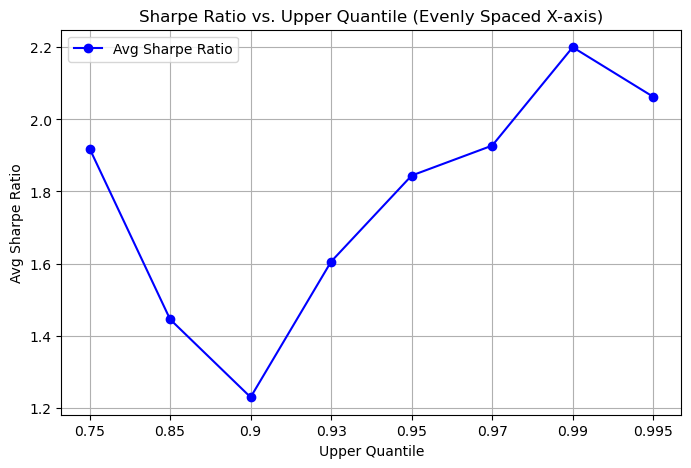

In [390]:
picture.plot_quantile_vs_sharpe(quantile_plot_results)

The plot shows the relationship between **Upper Quantile** and **Avg Sharpe Ratio**.  

- **Sharpe Ratio drops initially** from **0.75 to 0.9**, suggesting that these quantiles may not capture effective trading signals.  
- **After 0.9, Sharpe Ratio increases steadily**, peaking at **0.99**, indicating better performance at higher quantiles.  
- The slight decline at **0.995** suggests that overly high quantiles may reduce effectiveness.  

 **Conclusion:** Higher quantiles (above **0.95**) generally yield better Sharpe Ratios, but extreme values may have diminishing returns. 

In [393]:
# Rank by Sharpe Ratio in descending order
ranked_results = quantile_results_df.sort_values(by="Sharpe Ratio", ascending=False)

# Keep only the top 20 highest Sharpe Ratio entries
top_20_results = ranked_results.head(20)

# Remove duplicates based on "Level 3" (keeping the highest Sharpe Ratio)
top_20_results = top_20_results.sort_values(by="Sharpe Ratio", ascending=False).drop_duplicates(subset=["level_3"], keep="first")

In [394]:
top_20_results

Upper Quantile  Lower Quantile              level_2      level_3  \
238           0.970           0.030      Overlap Studies            T   
237           0.970           0.030      Overlap Studies  H TRENDLINE   
303           0.990           0.010  Momentum Indicators         MOM1   
368           0.995           0.005  Momentum Indicators         TRIX   
367           0.995           0.005  Momentum Indicators        FASTD   
364           0.995           0.005  Momentum Indicators        SLOWK   
345           0.995           0.005  Momentum Indicators         MACD   
366           0.995           0.005  Momentum Indicators        FASTK   

     Sharpe Ratio  Max Drawdown (%)  Holding Win Rate (%)  \
238      2.638943         -6.342107              3.043109   
237      2.550053         -6.405803              3.057418   
303      2.265365        -17.040747              1.886918   
368      2.017971         -7.225578              0.526582   
367      1.939639         -5.445357              0.940597   
364      1.939639         -5.445357              0.940597   
345      1.927892         -7.046535              0.570464   
366      1.912140         -0.182161              0.040066   

     Trading Win Rate (%)  Final Cumulative Return (%)  Turnover (%)  
238             89.743590                    44.799639         62.84  
237             97.368421                    42.753933         62.86  
303             54.147196                    65.722139         20.98  
368             59.459459                    33.694735         10.48  
367             62.652233                    22.459397         10.50  
364             62.652233                    22.459397         10.50  
345             71.428571                    37.827452         10.48  
366             55.555556                     3.249596          0.27

- **Lower turnover leads to strong performance**: Many factors achieve high **Sharpe Ratios (~2.0+)** while keeping **turnover below 10.5%**.
- **Momentum Indicators dominate**: Factors like **MOM1, TRIX, FASTD, SLOWK, MACD, and FASTK** perform well with **low drawdowns and stable win rates**.
- **Overlap Studies still effective**: **T and H TRENDLINE** achieve the **highest Sharpe Ratios (~2.6)**, but at a **higher turnover (~62%)**.
- **Reduced drawdowns**: Lower turnover strategies tend to have **smaller max drawdowns**, improving risk-adjusted returns.

 **Conclusion:** Optimizing turnover improves factor stability, and **momentum indicators remain strong performers at lower turnover levels.** 

## Strategy Performance (Single indicator)

In [398]:
# Apply strategies
series_position_long_short = long_short_strategy(trading_signals_categorical_df['Overlap Studies']['BBAND UPPER SIGNAL'])

df_result = calculate_cumulative_asset(BTC["close"], series_position_long_short,fee_rate=0.0002)

evaluate_strategy(df_result, risk_free_rate=0.0)

{'Sharpe Ratio': 3.3548387638207213,
 'Max Drawdown (%)': -6.739395937270001,
 'Holding Win Rate (%)': 5.825789157373578,
 'Trading Win Rate (%)': 62.475181998676376,
 'Final Cumulative Return (%)': 99.14852695563756,
 'Turnover (%)': 56.89999999999999}

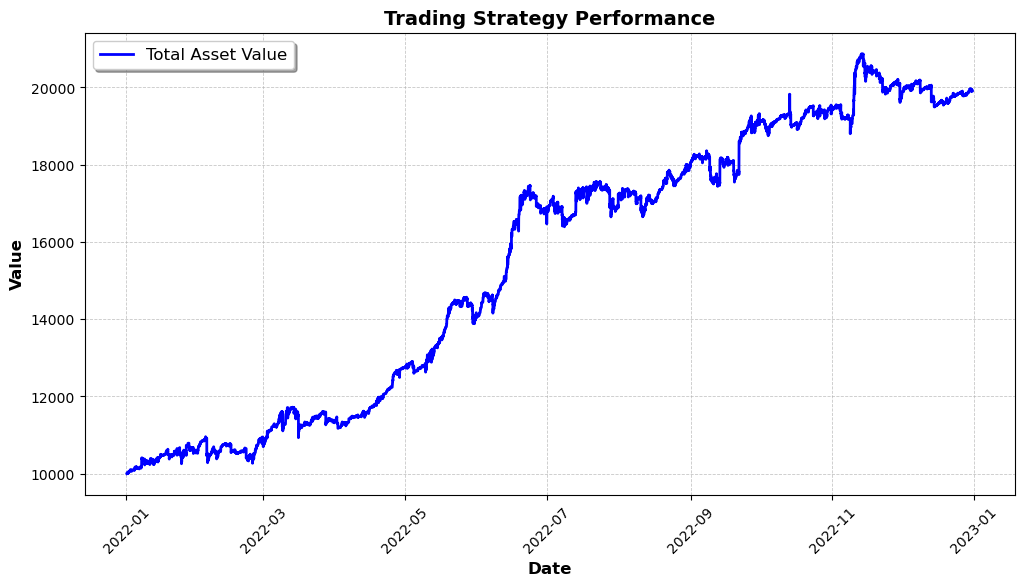

In [403]:
picture.plot_trading_performance(df_result)

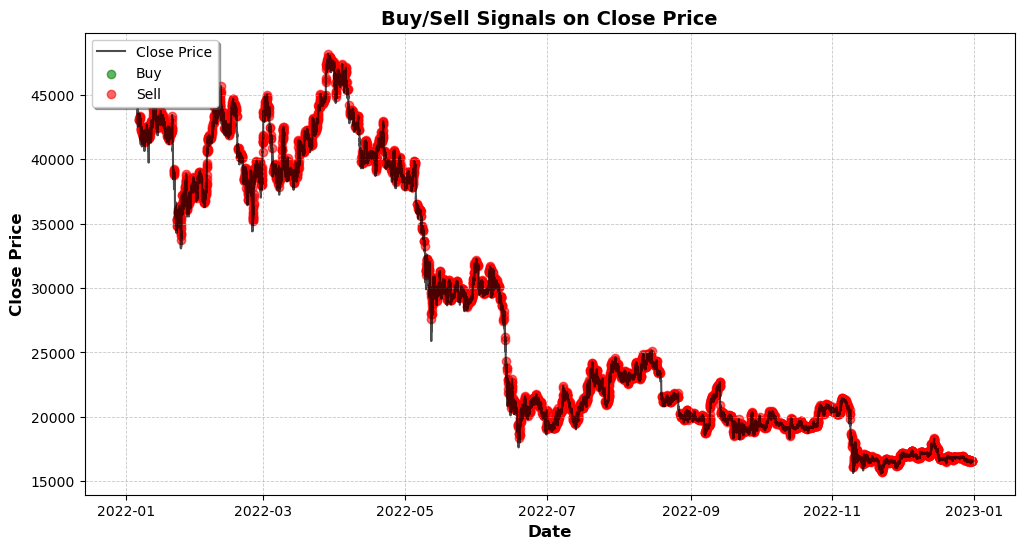

In [412]:
picture.plot_buy_sell_signals(BTC, series_position_long_short)

- The **best-performing indicator in 2022 was likely short-biased**, benefiting from the **downward market trend**.
- The **BTC price chart shows a consistent decline**, aligning with the effectiveness of short signals.
- In the **latter half of the year**, when the market **stabilized and no longer trended down**, the **indicator's performance dropped**.
- The **trading strategy's cumulative return plateaued** as the market **lost its clear downward momentum**.

**Conclusion:** The indicator's **success depended on market conditions**. It performed well in a **bear market** but struggled **when the trend weakened**. 

In [498]:
def generate_trading_signal(category, factor_name, factor_values, corr_value, is_numerical, upper_quantile=None, lower_quantile=None):
    """
    Generates trading signals based on whether the factor is numerical or categorical.

    Parameters:
    - category: Category of the factor.
    - factor_name: Name of the factor.
    - factor_values: Series containing factor values.
    - corr_value: Correlation of the factor with the target revenue factor.
    - is_numerical: Boolean indicating if the factor is numerical.
    - upper_quantile: Upper quantile threshold for numerical factors (required if is_numerical=True).
    - lower_quantile: Lower quantile threshold for numerical factors (required if is_numerical=True).

    Returns:
    - A DataFrame containing trading signals with properly named columns.
    """
    if is_numerical:
        if upper_quantile is None or lower_quantile is None:
            raise ValueError("Upper and lower quantiles must be provided for numerical factors.")
        
        # Compute quantile thresholds
        upper_threshold = factor_values.quantile(upper_quantile)
        lower_threshold = factor_values.quantile(lower_quantile)

        # Assign signals: 1 for buy, -1 for sell, 0 for neutral
        signal = np.where(
            factor_values > upper_threshold, 1,  # Buy signal
            np.where(factor_values < lower_threshold, -1, 0)  # Sell and Neutral signals
        )
    else:
        # Process categorical data
        unique_vals_sorted = sorted(factor_values.dropna().unique())
        unique_count = len(unique_vals_sorted)

        # Assign signals based on unique count
        if unique_count == 2:
            signal_map = {unique_vals_sorted[0]: 0, unique_vals_sorted[1]: 1}
        elif unique_count == 3:
            signal_map = {unique_vals_sorted[0]: 0, unique_vals_sorted[1]: 1, unique_vals_sorted[2]: -1}
        elif unique_count == 5:
            signal_map = {unique_vals_sorted[0]: 0, unique_vals_sorted[1]: 1, unique_vals_sorted[2]: -1,
                          unique_vals_sorted[3]: 1, unique_vals_sorted[4]: -1}
        else:
            signal_map = {val: 0 for val in unique_vals_sorted}  # Default neutral mapping for unsupported cases

        signal = factor_values.map(signal_map).fillna(0)

    # Adjust signal direction based on correlation sign
    if corr_value < 0:
        signal = -signal

    # Create a DataFrame with proper column names
    trading_signals_df = pd.DataFrame(signal, index=factor_values.index, columns=[(category, factor_name)])
    trading_signals_df.columns = pd.MultiIndex.from_tuples(trading_signals_df.columns, names=["Category", "Factor"])

    return trading_signals_df

# Example usage:
category, factor_name = "Momentum Indicators", "MACD"
trading_signals_df = generate_trading_signal(category, factor_name, df_extended[(category, factor_name)], factor_correlations.loc[(category, factor_name),("Revenue", "Future 5m Return")], is_numerical=True, upper_quantile=0.75, lower_quantile=0.25)


In [475]:
def generate_signals_for_top_factors(top_20_results, factor_correlations, df_extended, corr_threshold=0.7):
    """
    Generates trading signals for each factor listed in the top_20_results DataFrame
    and removes highly correlated signals.

    Parameters:
    - top_20_results: DataFrame containing the best-performing factors with their quantiles.
    - df_extended: DataFrame containing the original factor data.
    - corr_threshold: Threshold for filtering out highly correlated factors.

    Returns:
    - A DataFrame containing trading signals for the selected factors.
    """
    trading_signals_dict = {}

    for _, row in top_20_results.iterrows():
        category = row["level_2"]
        factor_name = row["level_3"]
        upper_quantile = row["Upper Quantile"]
        lower_quantile = row["Lower Quantile"]
        sharpe_ratio = row["Sharpe Ratio"]  # Used for ranking if needed

        # Check if factor exists in df_extended
        if (category, factor_name) in df_extended.columns:
            factor_values = df_extended[(category, factor_name)]
            is_numerical = factor_values.dtype.kind in 'fi'  # Check if the column is numerical
            corr_value = factor_correlations.loc[(category, factor_name),("Revenue", "Future 5m Return")]

            # Generate trading signals
            trading_signals_df = generate_trading_signal(
                category, factor_name, factor_values, corr_value=corr_value,  # Placeholder correlation
                is_numerical=is_numerical, upper_quantile=upper_quantile, lower_quantile=lower_quantile
            )

            # Store result
            trading_signals_dict[(category, factor_name)] = trading_signals_df

    # Concatenate trading signals into a DataFrame
    if trading_signals_dict:
        trading_signals_df = pd.concat(trading_signals_dict.values(), axis=1)
        trading_signals_df.columns = pd.MultiIndex.from_tuples(trading_signals_dict.keys(), names=["Category", "Factor"])
    else:
        return pd.DataFrame()  # Return an empty DataFrame if no signals are generated

    # Compute correlation matrix of trading signals
    corr_df = trading_signals_df.corr()

    # Remove highly correlated factors
    final_selected_factors = set(trading_signals_df.columns)
    for factor_a in trading_signals_df.columns:
        for factor_b in trading_signals_df.columns:
            if factor_a != factor_b and factor_a in final_selected_factors and factor_b in final_selected_factors:
                if abs(corr_df.loc[factor_a, factor_b]) > corr_threshold:
                    # Remove the lower Sharpe Ratio factor
                    sharpe_a = top_20_results[(top_20_results["level_2"] == factor_a[0]) & (top_20_results["level_3"] == factor_a[1])]["Sharpe Ratio"].values[0]
                    sharpe_b = top_20_results[(top_20_results["level_2"] == factor_b[0]) & (top_20_results["level_3"] == factor_b[1])]["Sharpe Ratio"].values[0]
                    if sharpe_a > sharpe_b:
                        final_selected_factors.discard(factor_b)
                    else:
                        final_selected_factors.discard(factor_a)

    # Filter final trading signals
    trading_signals_df = trading_signals_df[list(final_selected_factors)]

    return trading_signals_df

# **Run the function**
trading_signals_df = generate_signals_for_top_factors(top_20_results,factor_correlations, df_extended)


In [452]:
# Select the top 6 categorical factors based on Sharpe Ratio
top_6_categorical_factors = top_factors_categorical_filtered.sort_values(by='Sharpe Ratio', ascending=False).index[:6]

# Extract the selected categorical trading signals
top_categorical_signals = trading_signals_categorical_df[top_6_categorical_factors]

# Concatenate numerical and categorical signals
combined_signals_df = pd.concat([trading_signals_df, top_categorical_signals], axis=1)

# Compute the sum of all signals across factors for each timestamp
combined_signals_df['Sum_Signals'] = combined_signals_df.sum(axis=1)

In [454]:
# Apply strategies
series_position_long_short = long_short_strategy(combined_signals_df['Sum_Signals'])

df_result = calculate_cumulative_asset(BTC["close"], series_position_long_short, fee_rate=0.0002)

evaluate_strategy(df_result, risk_free_rate=0.0)

{'Sharpe Ratio': 3.47330051371227,
 'Max Drawdown (%)': -6.782331051351321,
 'Holding Win Rate (%)': 5.9717439209364,
 'Trading Win Rate (%)': 47.591933570581254,
 'Final Cumulative Return (%)': 53.51797908579117,
 'Turnover (%)': 43.19}

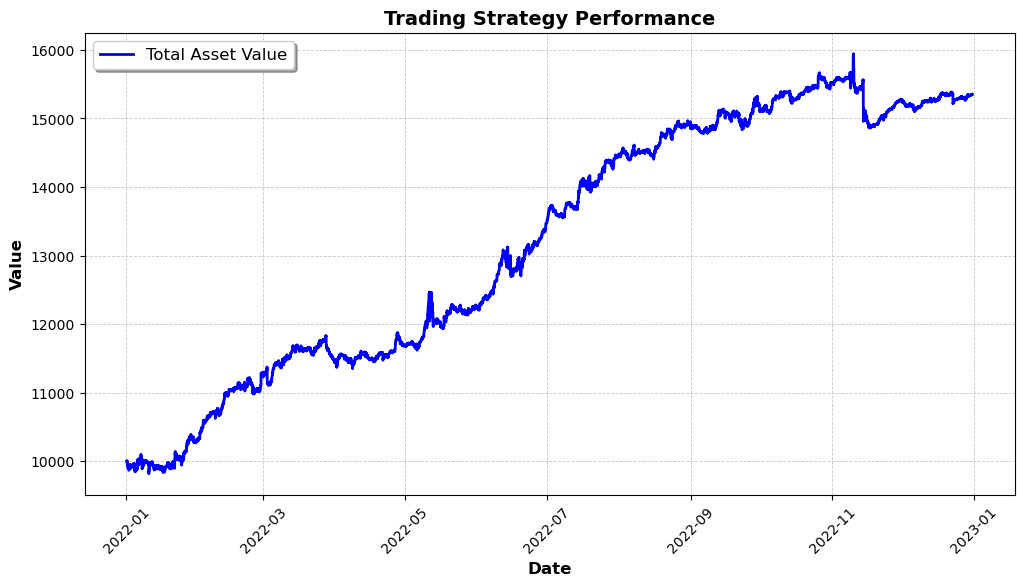

In [455]:
picture.plot_trading_performance(df_result)

This chart demonstrates the performance of a trading strategy that combines multiple high-performing factors. Compared to single-factor strategies, the combined approach results in a more stable return curve with reduced drawdowns. However, there are several key considerations to keep in mind:

1. **Overfitting Risk** The strong historical performance may be a result of fitting the model to past data rather than capturing a truly robust pattern. Future market conditions could render some of these factors ineffective.

2. **Market Regime Changes** Factors perform differently in various market environments. For example, momentum indicators work well in trending markets, while mean-reversion factors may be more effective in range-bound conditions. The strategy should account for shifting market dynamics.

3. **Dynamic Factor Selection** Incorporating a rolling window or machine learning approach could help adaptively select the best factors over time, ensuring the strategy remains effective as market conditions evolve.

4. **Risk Control** C While combining factors reduces the volatility of a single-factor approach, highly correlated factors could lead to simultaneous failure under certain market conditions. A proper risk management framework is necessary.

## Strategy Improvement (Detrend)

In [457]:
window_size = 15000  
moving_avg = BTC.rolling(window=window_size).mean()
detrended_series = BTC - moving_avg
detrended_series = detrended_series.dropna()

df_indicators_detrend = factors.compute_technical_indicators(detrended_series, start, end)
df_indicators_detrend = factors.restructure_dataframe(df_indicators_detrend)

In [461]:
def compute_future_returns(df, BTC, future_intervals=[5, 10, 15, 20, 25, 30]):

    # Compute future returns and store in a dictionary
    future_returns = {
        f"Future {interval}m Return": BTC["close"].pct_change(periods=interval).shift(-interval) for interval in future_intervals
    }

    # Convert the dictionary to a DataFrame with MultiIndex columns
    future_returns_df = pd.DataFrame(future_returns, index=df.index)
    future_returns_df.columns = pd.MultiIndex.from_tuples(
        [("Revenue", col) for col in future_returns_df.columns], names=["Category", "Factor"]
    )

    # Concatenate the original DataFrame with the new future return columns
    df_extended = pd.concat([df, future_returns_df], axis=1)

    return df_extended

df_extended = compute_future_returns(df_indicators_detrend, BTC)
revenue_columns = [col for col in df_extended.columns if col[0] == "Revenue"]
factor_correlations = df_extended.corr().loc[:, revenue_columns].drop(index=revenue_columns)


In [463]:
# Define quantile search space
quantile_range = [0.75, 0.85, 0.9, 0.93, 0.95, 0.97, 0.99, 0.995]

# Dictionary to store results for each quantile setting
quantile_results = {}
quantile_plot_results = {}

best_avg_sharpe = -np.inf
best_quantiles = None
best_results_df = None

# Iterate over quantile pairs externally
for upper_quantile in quantile_range:
    lower_quantile = 1 - upper_quantile  # Ensure symmetry
    if lower_quantile >= upper_quantile:
        continue  # Ensure lower quantile is less than upper quantile

    # Evaluate the strategy for the current quantile pair
    results_df, avg_sharpe = evaluate_quantile_performance(
        df_extended, factor_correlations, numerical_columns, BTC, upper_quantile, lower_quantile
    )

    # Store results
    quantile_results[(upper_quantile, lower_quantile)] = results_df
    quantile_plot_results[upper_quantile] = avg_sharpe

    # Update best quantiles if this setting improves the Sharpe ratio
    if avg_sharpe > best_avg_sharpe:
        best_avg_sharpe = avg_sharpe
        best_quantiles = (upper_quantile, lower_quantile)
        best_results_df = results_df

# Convert dictionary into a structured DataFrame
quantile_results_df = pd.concat(quantile_results, names=["Upper Quantile", "Lower Quantile"])
quantile_results_df.reset_index(inplace=True)

In [464]:
quantile_results_df.to_csv('detrend_numerical_performance.csv')

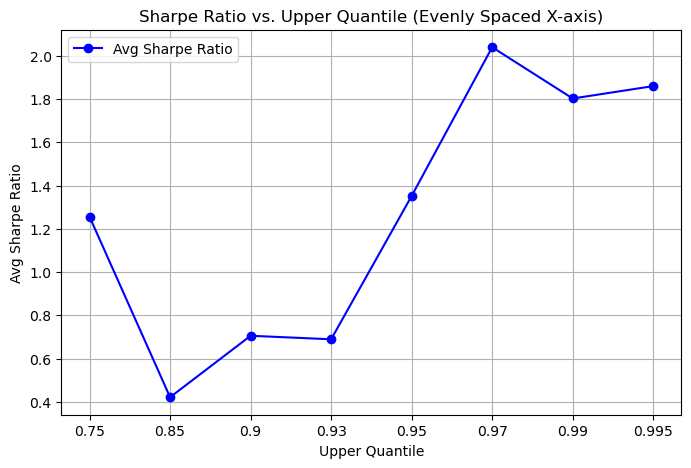

In [465]:
picture.plot_quantile_vs_sharpe(quantile_plot_results)

In [466]:
# Rank by Sharpe Ratio in descending order
ranked_results = quantile_results_df.sort_values(by="Sharpe Ratio", ascending=False)

# Keep only the top 20 highest Sharpe Ratio entries
top_20_results = ranked_results.head(20)

# Remove duplicates based on "Level 3" (keeping the highest Sharpe Ratio)
top_20_results = top_20_results.sort_values(by="Sharpe Ratio", ascending=False).drop_duplicates(subset=["level_3"], keep="first")

In [467]:
top_20_results

Upper Quantile  Lower Quantile                level_2      level_3  \
303           0.990           0.010    Momentum Indicators         MOM1   
237           0.970           0.030        Overlap Studies  H TRENDLINE   
238           0.970           0.030        Overlap Studies            T   
321           0.990           0.010    Momentum Indicators         TRIX   
193           0.950           0.050    Momentum Indicators        ADX20   
361           0.995           0.005    Momentum Indicators         RSI5   
241           0.970           0.030    Momentum Indicators         ADXR   
46            0.750           0.250       Cycle Indicators   HT DCPHASE   
43            0.750           0.250  Volatility Indicators         NATR   
345           0.995           0.005    Momentum Indicators         MACD   
192           0.950           0.050    Momentum Indicators        ADX14   

     Sharpe Ratio  Max Drawdown (%)  Holding Win Rate (%)  \
303      2.537280         -7.859295              1.906999   
237      2.397684        -15.567579              3.056987   
238      2.089092        -15.919064              3.048081   
321      1.746633         -6.908711              1.064268   
193      1.639122         -8.463343              5.461610   
361      1.573366        -10.169519              0.816013   
241      1.564260         -9.304956              3.315262   
46       1.483317        -22.936918             28.285482   
43       1.296577        -31.420605             25.360972   
345      1.169040         -9.592309              0.554399   
192      1.162336         -9.461721              5.604106   

     Trading Win Rate (%)  Final Cumulative Return (%)  Turnover (%)  
303             55.586018                    64.280559         17.98  
237             93.333333                    70.995030         53.86  
238             83.870968                    59.752901         53.84  
321             62.500000                    20.732151         17.96  
193             54.500000                    30.982015         89.80  
361             67.640919                    17.047944          9.00  
241             51.508121                    22.899219         53.88  
46              40.489460                    64.199531        448.82  
43              59.082218                    55.739581        449.06  
345             68.888889                    18.322520          8.98  
192             52.577320                    21.410846         89.80

In [476]:
trading_signals_df_numerical = generate_signals_for_top_factors(top_20_results, factor_correlations, df_extended)

In [499]:
trading_signals_list = []
strategy_evaluation_results_categorical = {}

for category, name in categorical_columns:
    corr_value = factor_correlations.loc[(category, name),("Revenue", "Future 5m Return")]
    signal_df = generate_trading_signal(category, name, df_extended[(category, name)],corr_value, is_numerical=False)
    trading_signals_list.append(signal_df)
    
    # Calculate the cumulative asset value
    df_result = calculate_cumulative_asset(BTC["close"], signal_df.dropna())

    # Evaluate the strategy and store results
    evaluation_metrics = evaluate_strategy(df_result, risk_free_rate=0.0)
    strategy_evaluation_results_categorical[(category, name)] = evaluation_metrics
    

In [500]:
trading_signals_df_categorical = pd.concat(trading_signals_list, axis=1)
trading_performance_df_categorical = pd.DataFrame(strategy_evaluation_results_categorical)

In [520]:
# Select the top 6 categorical factors based on Sharpe Ratio
top_6_categorical_factors = trading_performance_df_categorical.T.sort_values(by='Sharpe Ratio', ascending=False).index[:3]

# Extract the selected categorical trading signals
top_categorical_signals = trading_signals_df_categorical[top_6_categorical_factors]

# Concatenate numerical and categorical signals
combined_signals_df = pd.concat([trading_signals_df, top_categorical_signals], axis=1)

# Compute the sum of all signals across factors for each timestamp
combined_signals_df['Sum_Signals'] = combined_signals_df.sum(axis=1)

In [521]:
# Apply strategies
series_position_long_short = long_short_strategy(combined_signals_df['Sum_Signals'])

df_result = calculate_cumulative_asset(BTC["close"], series_position_long_short, fee_rate=0.0002)

evaluate_strategy(df_result, risk_free_rate=0.0)

{'Sharpe Ratio': 3.8738010267185454,
 'Max Drawdown (%)': -6.6419890527196825,
 'Holding Win Rate (%)': 6.1518251750587245,
 'Trading Win Rate (%)': 62.21735959153902,
 'Final Cumulative Return (%)': 99.38387074588817,
 'Turnover (%)': 51.67}

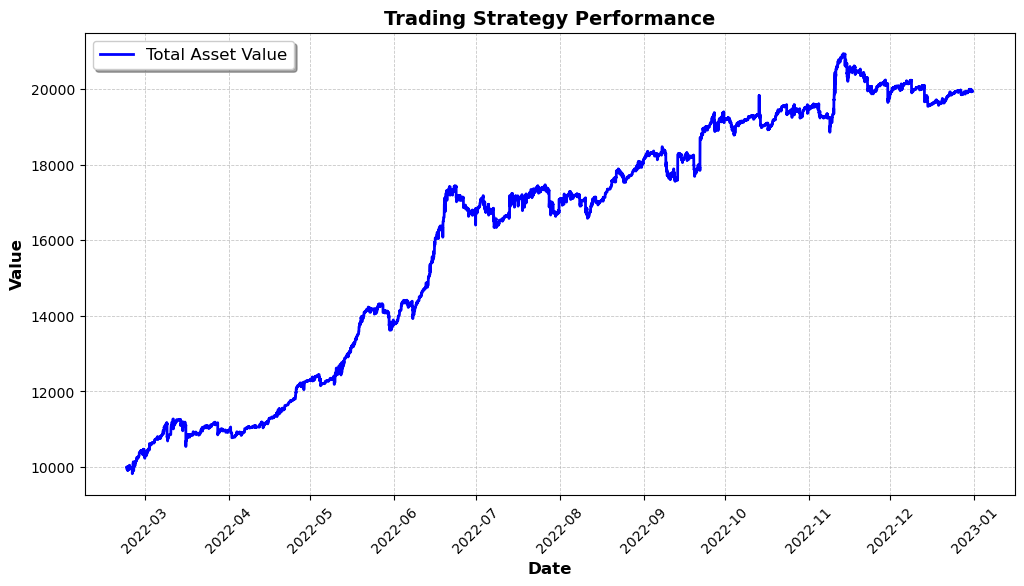

In [522]:
picture.plot_trading_performance(df_result)

## Strategy Improvement (Volatility Adjusted)

In [532]:
def realized_volatility(prices, window=5*24*12):
    log_returns = np.log(prices / prices.shift(1)) 
    rolling_vol = log_returns.rolling(window=window).std() *100
    return rolling_vol

BTC["volatility"] = realized_volatility(BTC["close"])

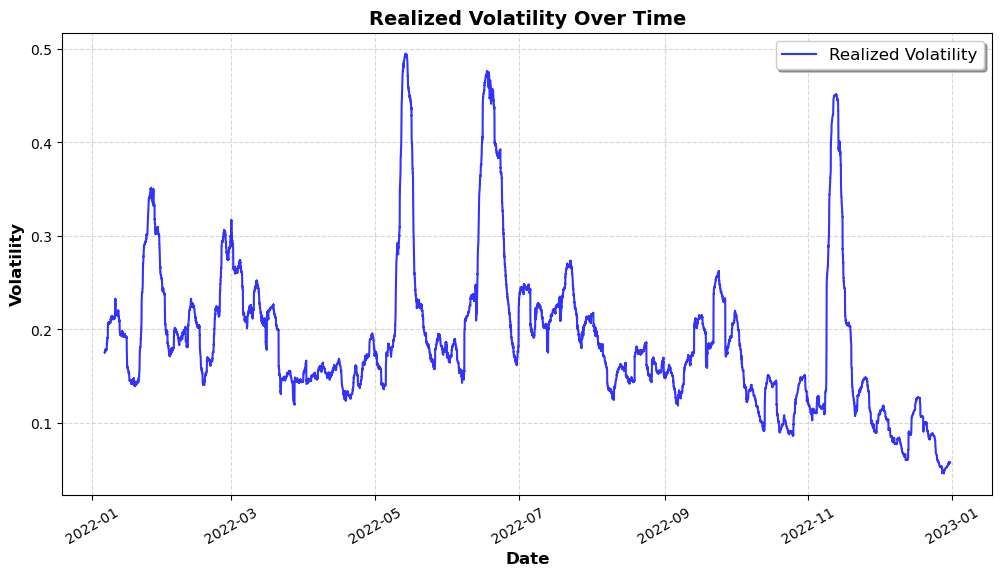

In [536]:
picture.plot_realized_volatility(BTC)

This chart illustrates the realized volatility over time, showing periods of both high and low market volatility. Based on previous research, I observed that the top-performing indicators tend to work best in trending markets, where price movements are more directional. However, when the market experiences small-scale fluctuations (low volatility), the strategys returns are often insufficient to cover trading costs.

To address this issue, I aim to adjust my strategy dynamically based on volatility levels. Specifically:
- **During high-volatility periods**, the strategy can remain active, as trends are more pronounced, and the indicators perform well.
- **During low-volatility periods**, the strategy should reduce position openings to avoid excessive trading in choppy, non-directional markets, where the cost of execution outweighs the potential returns.

This adjustment helps to optimize risk management and improve the overall efficiency of the strategy.

In [523]:
window_size = 15000  
moving_avg = BTC.rolling(window=window_size).mean()
detrended_series = BTC - moving_avg
detrended_series = detrended_series.dropna()

df_indicators_detrend = factors.compute_technical_indicators(detrended_series, start, end)
df_indicators_detrend = factors.restructure_dataframe(df_indicators_detrend)

In [587]:
df_indicators_notrend = factors.compute_technical_indicators(BTC, start, end)
df_indicators_notrend = factors.restructure_dataframe(df_indicators_notrend)

In [595]:
def compute_future_returns(df, BTC, future_intervals=[5, 10, 15, 20, 25, 30]):

    # Compute future returns and store in a dictionary
    future_returns = {
        f"Future {interval}m Return": BTC["close"].pct_change(periods=interval).shift(-interval) for interval in future_intervals
    }

    # Convert the dictionary to a DataFrame with MultiIndex columns
    future_returns_df = pd.DataFrame(future_returns, index=df.index)
    future_returns_df.columns = pd.MultiIndex.from_tuples(
        [("Revenue", col) for col in future_returns_df.columns], names=["Category", "Factor"]
    )

    # Concatenate the original DataFrame with the new future return columns
    df_extended = pd.concat([df, future_returns_df], axis=1)

    return df_extended

df_extended = compute_future_returns(df_indicators_detrend, BTC)
revenue_columns = [col for col in df_extended.columns if col[0] == "Revenue"]
factor_correlations = df_extended.corr().loc[:, revenue_columns].drop(index=revenue_columns)

In [596]:
def generate_numerical_signal(category, factor_name, factor_values, corr_value, quantile_levels):
    if quantile_levels is None:
        raise ValueError("Quantile levels must be provided for numerical factors.")

    # Compute quantile thresholds
    quantiles = factor_values.quantile(quantile_levels).values

    # Generate signals based on quantiles
    signal = np.select(
        [
            factor_values >= quantiles[-1],  # Top 10%
            (factor_values >= quantiles[-2]) & (factor_values < quantiles[-1]),
            (factor_values >= quantiles[-3]) & (factor_values < quantiles[-2]),
            (factor_values >= quantiles[-4]) & (factor_values < quantiles[-3]),
            (factor_values >= quantiles[-5]) & (factor_values < quantiles[-4]),
            (factor_values >= quantiles[-6]) & (factor_values < quantiles[-5]),
            (factor_values >= quantiles[-7]) & (factor_values < quantiles[-6]),
            (factor_values >= quantiles[-8]) & (factor_values < quantiles[-7]),
            (factor_values >= quantiles[-9]) & (factor_values < quantiles[-8]),
            (factor_values >= quantiles[0]) & (factor_values < quantiles[-9]),
            factor_values < quantiles[0]  # Bottom 10%
        ],
        [5, 4, 3, 2, 1, 0, -1, -2, -3, -4, -5]
    )

    # Adjust signal direction based on correlation sign
    if corr_value < 0:
        signal = -signal

    # Create a DataFrame with proper column names
    trading_signals_df = pd.DataFrame(signal, index=factor_values.index, columns=[(category, factor_name)])
    trading_signals_df.columns = pd.MultiIndex.from_tuples(trading_signals_df.columns, names=["Category", "Factor"])

    return trading_signals_df

def generate_categorical_signal(category, factor_name, factor_values, corr_value):
    unique_vals_sorted = sorted(factor_values.dropna().unique())
    unique_count = len(unique_vals_sorted)

    # Assign signals based on unique count
    if unique_count == 2:
        signal_map = {unique_vals_sorted[0]: 0, unique_vals_sorted[1]: 5}
    elif unique_count == 3:
        signal_map = {unique_vals_sorted[0]: 0, unique_vals_sorted[1]: 5, unique_vals_sorted[2]: -5}
    elif unique_count == 5:
        signal_map = {unique_vals_sorted[0]: 0, unique_vals_sorted[1]: 1, unique_vals_sorted[2]: -1,
                      unique_vals_sorted[3]: 5, unique_vals_sorted[4]: -5}
    else:
        signal_map = {val: 0 for val in unique_vals_sorted}  # Default neutral mapping for unsupported cases

    signal = factor_values.map(signal_map).fillna(0)

    # Adjust signal direction based on correlation sign
    if corr_value < 0:
        signal = -signal

    # Create a DataFrame with proper column names
    trading_signals_df = pd.DataFrame(signal, index=factor_values.index, columns=[(category, factor_name)])
    trading_signals_df.columns = pd.MultiIndex.from_tuples(trading_signals_df.columns, names=["Category", "Factor"])

    return trading_signals_df


In [628]:
# Define quantile levels for numerical signals
quantile_levels = [0.005, 0.01, 0.02, 0.03, 0.05, 0.95, 0.97, 0.98, 0.99, 0.995]

# Dictionary to store generated signals
trading_signals_dict = {}

# Iterate through columns in df_indicators_detrend
for (category, factor_name) in df_indicators_detrend.columns:
    factor_values = df_indicators_detrend[(category, factor_name)]
    corr_value = factor_correlations.loc[(category, factor_name),("Revenue", "Future 5m Return")]
    
    # Determine whether it's numerical or categorical
    unique_count = factor_values.nunique()
    
    if unique_count > 5:
        # Numerical factor  Use quantiles
        signal_df = generate_numerical_signal(category, factor_name, factor_values, corr_value=corr_value, quantile_levels=quantile_levels)
    
    else:
        # Categorical factor  Use predefined mapping
        signal_df = generate_categorical_signal(category, factor_name, factor_values, corr_value=corr_value)

    # Store the result
    trading_signals_dict[(category, factor_name)] = signal_df

# Convert dictionary to a DataFrame
trading_signals_df = pd.concat(trading_signals_dict.values(), axis=1)

# Assign proper MultiIndex columns
trading_signals_df.columns = pd.MultiIndex.from_tuples(trading_signals_dict.keys(), names=["Category", "Factor"])


In [629]:
strategy_evaluation_results = {}

df_vol = BTC["volatility"].copy()
# Evaluate categorical factor strategies
for (category, factor_name) in trading_signals_df.columns:
    # Get the trading signal series for the factor
    series_position_long_short = vol_long_short_strategy(trading_signals_df[category][factor_name],df_vol)

    # Calculate the cumulative asset value
    df_result = calculate_cumulative_asset(BTC["close"], series_position_long_short)

    # Evaluate the strategy and store results
    evaluation_metrics = evaluate_strategy(df_result, risk_free_rate=0.0)
    strategy_evaluation_results[(category, factor_name)] = evaluation_metrics

# Convert the results dictionaries into structured DataFrames
evaluation_results_df = pd.DataFrame(strategy_evaluation_results).T
evaluation_results_df.columns = ["Sharpe Ratio", "Max Drawdown (%)", "Holding Win Rate (%)", 
                                           "Trading Win Rate (%)", "Final Cumulative Return (%)", "Turnover (%)"]

In [630]:
# Select the top 30 factors based on Sharpe Ratio
top_30_factors = evaluation_results_df.sort_values(by="Sharpe Ratio", ascending=False).head(30)

In [631]:
top_30_factors

Sharpe Ratio  Max Drawdown (%)  \
Overlap Studies     BBAND UPPER SIGNAL      3.631708         -6.909779   
                    TRIMA                   2.780170        -14.869983   
                    T                       2.779438        -14.464705   
                    EMA                     2.737302        -14.575688   
                    H TRENDLINE             2.632710        -14.219548   
                    SMA20                   2.627234        -14.240853   
                    KMAM                    2.572834        -15.048693   
                    DEMA                    2.538901        -15.724864   
                    SMA5                    2.498106        -15.503855   
                    TEMA                    2.449271        -17.151997   
                    SMA3                    2.433993        -15.879506   
                    WMA                     2.337560        -14.575688   
                    MIDPRICE                2.312774        -14.788811   
                    MIDPOINT                2.270475        -14.621280   
                    SMA10                   2.240558        -16.140962   
                    SAREXT                  2.101510        -14.575688   
                    SAR                     2.101510        -14.575688   
Pattern Recognition DLCONCEALBABYSWALL      1.729650         -0.022505   
                    CDLEVENINGDOJISTAR      1.673422        -26.294310   
                    CDLTASUKIGAP            1.637192        -29.402469   
                    DLABANDONEDBABY         1.633972        -26.294310   
Momentum Indicators ADX14                   1.608475        -10.875342   
Pattern Recognition CDLUNIQUE3RIVER         1.600573         -0.318809   
Momentum Indicators MOM1                    1.568488        -32.522210   
Pattern Recognition CDL3LINESTRIKE          1.548228        -30.313945   
                    CDL2CROWS               1.547927        -27.839407   
                    CDLINNECK               1.518928        -29.133843   
                    CDL3OUTSIDE             1.507699        -33.120478   
                    CDLHANGINGMAN           1.499795        -31.139038   
                    CDLLONGLINE             1.496886        -34.850623   

                                        Holding Win Rate (%)  \
Overlap Studies     BBAND UPPER SIGNAL              5.981498   
                    TRIMA                           2.196444   
                    T                               2.194218   
                    EMA                             2.227615   
                    H TRENDLINE                     2.207577   
                    SMA20                           2.203124   
                    KMAM                            2.190878   
                    DEMA                            2.209803   
                    SMA5                            2.216483   
                    TEMA                            2.212030   
                    SMA3                            2.233182   
                    WMA                             2.200897   
                    MIDPRICE                        2.217596   
                    MIDPOINT                        2.194218   
                    SMA10                           2.199784   
                    SAREXT                          2.246541   
                    SAR                             2.246541   
Pattern Recognition DLCONCEALBABYSWALL              0.005566   
                    CDLEVENINGDOJISTAR             49.135561   
                    CDLTASUKIGAP                   49.142240   
                    DLABANDONEDBABY                49.137787   
Momentum Indicators ADX14                           2.784241   
Pattern Recognition CDLUNIQUE3RIVER                 0.032284   
Momentum Indicators MOM1                            4.346132   
Pattern Recognition CDL3LINESTRIKE                 49.153373   
                    CDL2CROWS                      49.146693   
                 

Based on previous experiments, we aim to ensure that the buy and sell signals determined by the quantile selection are as few as possible. After multiple tests, when setting `quantile_levels = [0.005, 0.01, 0.02, 0.03, 0.05, 0.95, 0.97, 0.98, 0.99, 0.995]`, the turnover is approximately similar to that of the category indicators.

In [567]:
series_position_long_short = vol_long_short_strategy(trading_signals_df["Overlap Studies"]["BBAND UPPER SIGNAL"],df_vol)
df_result = calculate_cumulative_asset(BTC["close"], series_position_long_short)

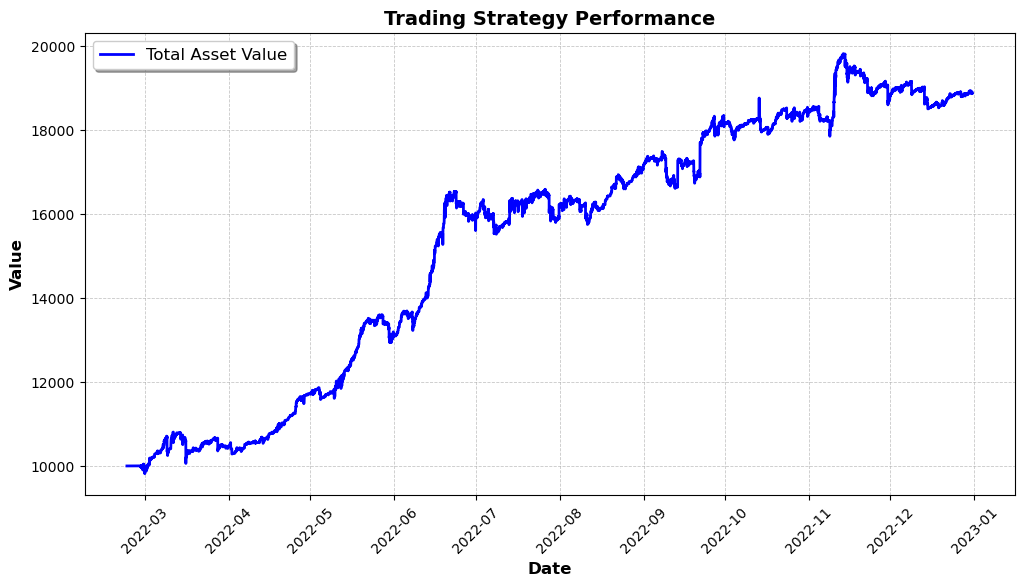

In [569]:
picture.plot_trading_performance(df_result)

In [632]:
# Set to store factors that should be removed
factors_to_remove = set()
top_30_factors_index = top_30_factors.index
top_30_factors_corr = trading_signals_df[top_30_factors_index].corr()

# Iterate over the correlation matrix to find highly correlated factors
for i in range(len(top_30_factors_index)):
    for j in range(i + 1, len(top_30_factors_index)):
        factor1 = top_30_factors_index[i]
        factor2 = top_30_factors_index[j]

        # Ensure both factors exist in the correlation matrix
        if factor1 in top_30_factors_corr.index and factor2 in top_30_factors_corr.columns:
            # If correlation is greater than 0.7, remove the lower-ranked factor
            if top_30_factors_corr.loc[factor1, factor2] > 0.7:
                factors_to_remove.add(factor2)

# Filter the top factors index to exclude highly correlated ones
filtered_top_30_factors_index = [factor for factor in top_30_factors_index if factor not in factors_to_remove]

In [633]:
filtered_top_30_factors_index

[('Overlap Studies', 'BBAND UPPER SIGNAL'),
 ('Overlap Studies', 'TRIMA'),
 ('Pattern Recognition', 'DLCONCEALBABYSWALL'),
 ('Pattern Recognition', 'CDLEVENINGDOJISTAR'),
 ('Pattern Recognition', 'CDLTASUKIGAP'),
 ('Pattern Recognition', 'DLABANDONEDBABY'),
 ('Momentum Indicators', 'ADX14'),
 ('Pattern Recognition', 'CDLUNIQUE3RIVER'),
 ('Momentum Indicators', 'MOM1'),
 ('Pattern Recognition', 'CDL3LINESTRIKE'),
 ('Pattern Recognition', 'CDL2CROWS'),
 ('Pattern Recognition', 'CDLINNECK'),
 ('Pattern Recognition', 'CDL3OUTSIDE'),
 ('Pattern Recognition', 'CDLHANGINGMAN'),
 ('Pattern Recognition', 'CDLLONGLINE')]

In [654]:
# Select signals from the filtered top 30 factors
valid_factors = [factor for factor in filtered_top_30_factors_index[:3] if factor in trading_signals_df.columns]
selected_signals = trading_signals_df[valid_factors]

# Sum all selected signals to create an aggregated signal
aggregated_signal = selected_signals.sum(axis=1)

# Define threshold for long and short positions
long_threshold = aggregated_signal.quantile(0.9)  # Upper 75% quantile
short_threshold = aggregated_signal.quantile(0.1)  # Lower 25% quantile

# Generate final trading signal: 1 for long, -1 for short, 0 for neutral
final_trading_signal = np.where(
    aggregated_signal > 1, 1,  # Long position
    np.where(aggregated_signal < -1, -1, 0)  # Short and neutral positions
)

# Convert to DataFrame
final_trading_signal_df = pd.DataFrame(final_trading_signal, index=trading_signals_df.index, columns=["Final Signal"])

In [655]:
# Apply strategies
series_position_long_short = long_short_strategy(final_trading_signal_df['Final Signal'])

df_result = calculate_cumulative_asset(BTC["close"], series_position_long_short)

evaluate_strategy(df_result, risk_free_rate=0.0)

{'Sharpe Ratio': 3.9609002384581014,
 'Max Drawdown (%)': -16.194841968306076,
 'Holding Win Rate (%)': 8.757945829205028,
 'Trading Win Rate (%)': 62.48091603053435,
 'Final Cumulative Return (%)': 200.39778308967544,
 'Turnover (%)': 101.84}

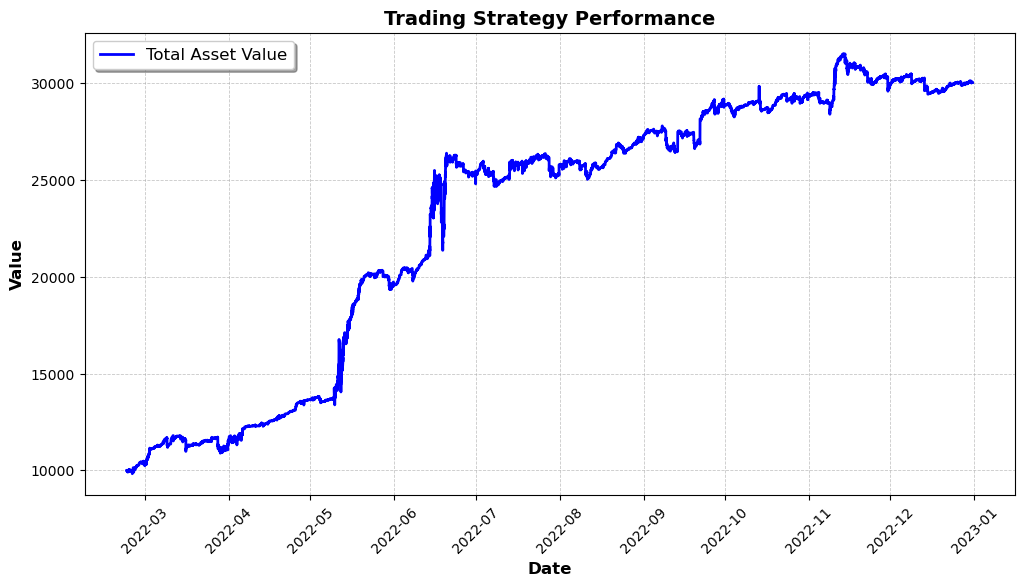

In [656]:
picture.plot_trading_performance(df_result)

### Summary

The analysis demonstrates that incorporating **historical return volatility for risk control** and **detrending methods for factor construction** significantly improves strategy performance.

1. **First Image (Best Performance - Volatility Control + Detrending)**
   - The first approach integrates **risk control using historical volatility** and **detrending of factors**. 
   - This results in a **smoother equity curve**, fewer large drawdowns, and more **stable upward growth**.
   - The use of volatility control helps avoid overtrading in **high-noise periods**, while detrending improves signal clarity.

2. **Second Image (Improved Performance - Detrending Only)**
   - This method **only applies detrending** to factor construction, without using volatility-based risk management.
   - Compared to the original strategy, the performance is **visibly better**, with improved returns and reduced drawdowns.
   - However, the lack of risk control leads to more **volatile performance swings**, suggesting potential overtrading during noisy markets.

3. **Third Image (Baseline Strategy - No Adjustments)**
   - The **original strategy** suffers from **sharper drawdowns** and **less stable** performance.
   - Without detrending, factor signals may be **distorted by long-term trends**, leading to lower accuracy.
   - Additionally, without volatility-based risk control, the strategy **trades aggressively even in unfavorable conditions**, leading to increased drawdowns.

### Key Insights & Takeaways:
- **Detrending improves factor robustness** by removing long-term biases and making signals more responsive to market shifts.
- **Volatility-based risk control stabilizes performance**, reducing unnecessary trades in noisy market conditions.
- The best results are achieved when **both techniques are applied together**, balancing **factor signal strength** with **adaptive risk control**.

This suggests that **future improvements** could include:
- **Dynamic volatility-based position sizing** (adapting exposure based on current market conditions).
- **Adaptive threshold selection for detrending** (to better align with changing market regimes).
- **Regime-switching models** to adjust between **trend-following** and **mean-reversion** strategies based on volatility conditions.

In [2]:
def compute_future_returns(df, BTC, future_intervals=[5, 10, 15, 20, 25, 30]):

    # Compute future returns and store in a dictionary
    future_returns = {
        f"Future {interval}m Return": BTC["close"].pct_change(periods=interval).shift(-interval) for interval in future_intervals
    }

    # Convert the dictionary to a DataFrame with MultiIndex columns
    future_returns_df = pd.DataFrame(future_returns, index=df.index)
    future_returns_df.columns = pd.MultiIndex.from_tuples(
        [("Revenue", col) for col in future_returns_df.columns], names=["Category", "Factor"]
    )

    # Concatenate the original DataFrame with the new future return columns
    df_extended = pd.concat([df, future_returns_df], axis=1)

    return df_extended


def generate_numerical_signal(category, factor_name, factor_values, corr_value, quantile_levels):
    if quantile_levels is None:
        raise ValueError("Quantile levels must be provided for numerical factors.")

    # Compute quantile thresholds
    quantiles = factor_values.quantile(quantile_levels).values

    # Generate signals based on quantiles
    signal = np.select(
        [
            factor_values >= quantiles[-1],  # Top 10%
            (factor_values >= quantiles[-2]) & (factor_values < quantiles[-1]),
            (factor_values >= quantiles[-3]) & (factor_values < quantiles[-2]),
            (factor_values >= quantiles[-4]) & (factor_values < quantiles[-3]),
            (factor_values >= quantiles[-5]) & (factor_values < quantiles[-4]),
            (factor_values >= quantiles[-6]) & (factor_values < quantiles[-5]),
            (factor_values >= quantiles[-7]) & (factor_values < quantiles[-6]),
            (factor_values >= quantiles[-8]) & (factor_values < quantiles[-7]),
            (factor_values >= quantiles[-9]) & (factor_values < quantiles[-8]),
            (factor_values >= quantiles[0]) & (factor_values < quantiles[-9]),
            factor_values < quantiles[0]  # Bottom 10%
        ],
        [5, 4, 3, 2, 1, 0, -1, -2, -3, -4, -5]
    )

    # Adjust signal direction based on correlation sign
    if corr_value < 0:
        signal = -signal

    # Create a DataFrame with proper column names
    trading_signals_df = pd.DataFrame(signal, index=factor_values.index, columns=[(category, factor_name)])
    trading_signals_df.columns = pd.MultiIndex.from_tuples(trading_signals_df.columns, names=["Category", "Factor"])

    return trading_signals_df

def generate_categorical_signal(category, factor_name, factor_values, corr_value):
    unique_vals_sorted = sorted(factor_values.dropna().unique())
    unique_count = len(unique_vals_sorted)

    # Assign signals based on unique count
    if unique_count == 2:
        signal_map = {unique_vals_sorted[0]: 0, unique_vals_sorted[1]: 5}
    elif unique_count == 3:
        signal_map = {unique_vals_sorted[0]: 0, unique_vals_sorted[1]: 5, unique_vals_sorted[2]: -5}
    elif unique_count == 5:
        signal_map = {unique_vals_sorted[0]: 0, unique_vals_sorted[1]: 1, unique_vals_sorted[2]: -1,
                      unique_vals_sorted[3]: 5, unique_vals_sorted[4]: -5}
    else:
        signal_map = {val: 0 for val in unique_vals_sorted}  # Default neutral mapping for unsupported cases

    signal = factor_values.map(signal_map).fillna(0)

    # Adjust signal direction based on correlation sign
    if corr_value < 0:
        signal = -signal

    # Create a DataFrame with proper column names
    trading_signals_df = pd.DataFrame(signal, index=factor_values.index, columns=[(category, factor_name)])
    trading_signals_df.columns = pd.MultiIndex.from_tuples(trading_signals_df.columns, names=["Category", "Factor"])

    return trading_signals_df

def realized_volatility(prices, window=5*24*12):
    log_returns = np.log(prices / prices.shift(1)) 
    rolling_vol = log_returns.rolling(window=window).std() *100
    return rolling_vol


def calculate_signal_sharpe(trading_signals_series,df_final):
    series_position_long_short = vol_long_short_strategy(trading_signals_series,df_final['volatility'])

    # Calculate the cumulative asset value
    df_result = calculate_cumulative_asset(df_final["close"], series_position_long_short)

    # Evaluate the strategy and store results
    evaluation_metrics = evaluate_strategy(df_result, risk_free_rate=0.0)
    
    return evaluation_metrics["Sharpe Ratio"],df_result

def convert_string_to_float(df):
    # Identify columns with string (object) data type
    string_columns = [col for col in df.columns if df[col].dtype == 'object']
    
    # Convert string columns to float where possible
    for col in string_columns:
        try:
            df[col] = pd.to_numeric(df[col], errors='coerce')  # Convert to float, set errors to NaN if conversion fails
        except Exception as e:
            print(f"Error converting column {col} to float: {e}")
    
    return df

In [25]:
import factors
import numpy as np
import picture

from trading_signal import vol_long_short_strategy
from metrics import evaluate_strategy
from metrics import calculate_cumulative_asset

In [29]:
import pandas as pd
import os

def analyze_crypto_trading_signals(file_path, start='2022-01-01', end='2022-12-31', window_size=15000):
    if not os.path.exists(file_path):
        print(f"❌ File not found: {file_path}, skipping.")
        return None, None  # Skip this file if not found

    # 1. Load cryptocurrency data
    crypto_data = pd.read_pickle(file_path)
    crypto_data = convert_string_to_float(crypto_data)  # Ensure data format is correct

    # 2. Compute detrended series using a moving average
    moving_avg = crypto_data.rolling(window=window_size).mean()
    detrended_series = crypto_data - moving_avg
    detrended_series = detrended_series.dropna()

    # 3. Compute technical indicators
    df_indicators_detrend = factors.compute_technical_indicators(detrended_series, start, end)
    df_indicators_detrend = factors.restructure_dataframe(df_indicators_detrend)

    # 4. Compute future returns
    df_extended = compute_future_returns(df_indicators_detrend.loc[start:end], crypto_data)
    revenue_columns = [col for col in df_extended.columns if col[0] == "Revenue"]
    factor_correlations = df_extended.corr().loc[:, revenue_columns].drop(index=revenue_columns)

    # 5. Generate trading signals
    quantile_levels = [0.005, 0.01, 0.02, 0.03, 0.05, 0.95, 0.97, 0.98, 0.99, 0.995]
    trading_signals_dict = {}

    for (category, factor_name) in df_indicators_detrend.columns:
        factor_values = df_indicators_detrend[(category, factor_name)]
        corr_value = factor_correlations.loc[(category, factor_name), ("Revenue", "Future 5m Return")]

        unique_count = factor_values.nunique()

        if unique_count > 5:
            signal_df = generate_numerical_signal(category, factor_name, factor_values, corr_value=corr_value, quantile_levels=quantile_levels)
        else:
            signal_df = generate_categorical_signal(category, factor_name, factor_values, corr_value=corr_value)

        trading_signals_dict[(category, factor_name)] = signal_df

    trading_signals_df = pd.concat(trading_signals_dict.values(), axis=1)
    trading_signals_df.columns = pd.MultiIndex.from_tuples(trading_signals_dict.keys(), names=["Category", "Factor"])

    # 6. Compute realized volatility
    crypto_data["volatility"] = realized_volatility(crypto_data["close"])

    # 7. Compute Sharpe ratios for all factors
    sharpe_ratios = {}
    factors_name = trading_signals_df.columns

    for factor in factors_name:
        trading_signals_series = trading_signals_df[factor]
        sharpe_ratios[factor], _ = calculate_signal_sharpe(trading_signals_series, crypto_data)

    # 8. Select the top 3 factors based on Sharpe ratio
    top_factors = sorted(sharpe_ratios, key=sharpe_ratios.get, reverse=True)[:3]

    if len(top_factors) == 0:
        print(f"⚠️ No valid factors found for {file_path}, skipping.")
        return None, None  # Skip this file if no valid signals are found

    # 9. Compute Test_Signal as the sum of the top 3 factors
    trading_signals_df['Test_Signal'] = trading_signals_df[top_factors].sum(axis=1)

    # 10. Compute final performance metrics
    performance_df, df_result = calculate_signal_sharpe(trading_signals_df['Test_Signal'].dropna(), crypto_data)

    print(f"✅ Completed analysis for: {file_path}")
    print(f"📊 Top selected factors: {top_factors}")

    return performance_df, df_result

def analyze_all_crypto_in_folder(folder_path, start='2022-01-01', end='2022-12-31', window_size=15000):
    results_dict = {}

    if not os.path.exists(folder_path):
        raise FileNotFoundError(f"❌ Folder not found: {folder_path}")

    # Loop through all .pkl files in the folder
    for filename in os.listdir(folder_path):
        if filename.endswith(".pkl"):
            file_path = os.path.join(folder_path, filename)
            print(f"\n🔍 Processing {filename}...")

            # Run analysis for the current cryptocurrency
            performance_df, df_result = analyze_crypto_trading_signals(file_path, start, end, window_size)

            # Store results only if valid
            if performance_df is not None:
                results_dict[filename] = (performance_df, df_result)

    print("\n🚀 All analyses completed.")
    return results_dict


In [31]:
results_dict = analyze_all_crypto_in_folder('data/cpt_5min/k_data')


🔍 Processing ADAUSD.pkl...
✅ Completed analysis for: data/cpt_5min/k_data/ADAUSD.pkl
📊 Top selected factors: [('Overlap Studies', 'BBAND UPPER SIGNAL'), ('Momentum Indicators', 'RSI5'), ('Overlap Studies', 'RSI')]

🔍 Processing AVAXUSD.pkl...
✅ Completed analysis for: data/cpt_5min/k_data/AVAXUSD.pkl
📊 Top selected factors: [('Overlap Studies', 'BBAND UPPER SIGNAL'), ('Momentum Indicators', 'SLOWK'), ('Momentum Indicators', 'FASTD')]

🔍 Processing BTCUSD.pkl...
✅ Completed analysis for: data/cpt_5min/k_data/BTCUSD.pkl
📊 Top selected factors: [('Overlap Studies', 'BBAND UPPER SIGNAL'), ('Overlap Studies', 'TRIMA'), ('Overlap Studies', 'EMA')]

🔍 Processing BNBUSD.pkl...
✅ Completed analysis for: data/cpt_5min/k_data/BNBUSD.pkl
📊 Top selected factors: [('Overlap Studies', 'EMA'), ('Overlap Studies', 'T'), ('Overlap Studies', 'MIDPOINT')]

🔍 Processing LTCUSD.pkl...
✅ Completed analysis for: data/cpt_5min/k_data/LTCUSD.pkl
📊 Top selected factors: [('Momentum Indicators', 'SLOWK'), ('Mome

📈 Plotting trading performance for ADAUSD.pkl...


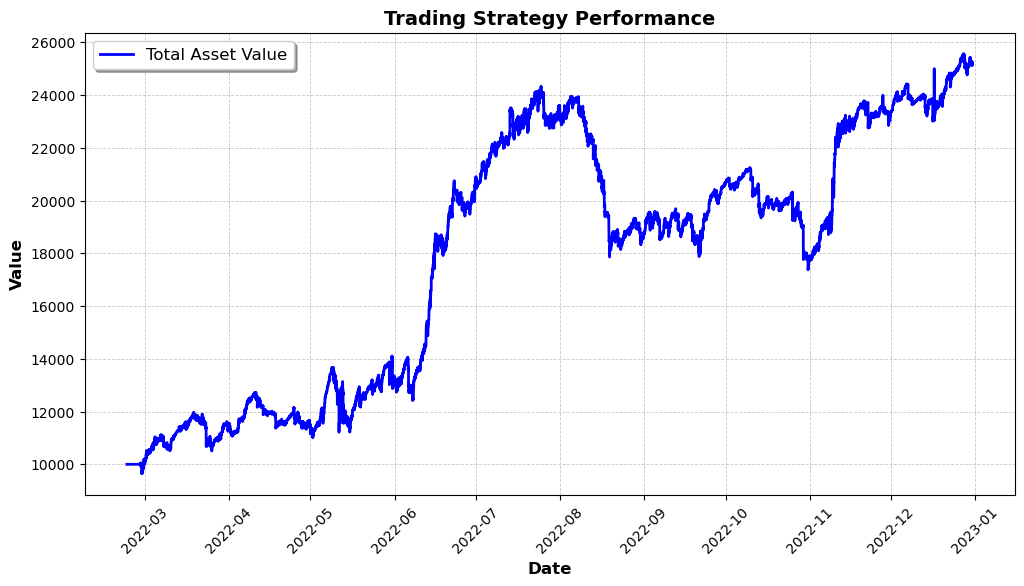

📈 Plotting trading performance for AVAXUSD.pkl...


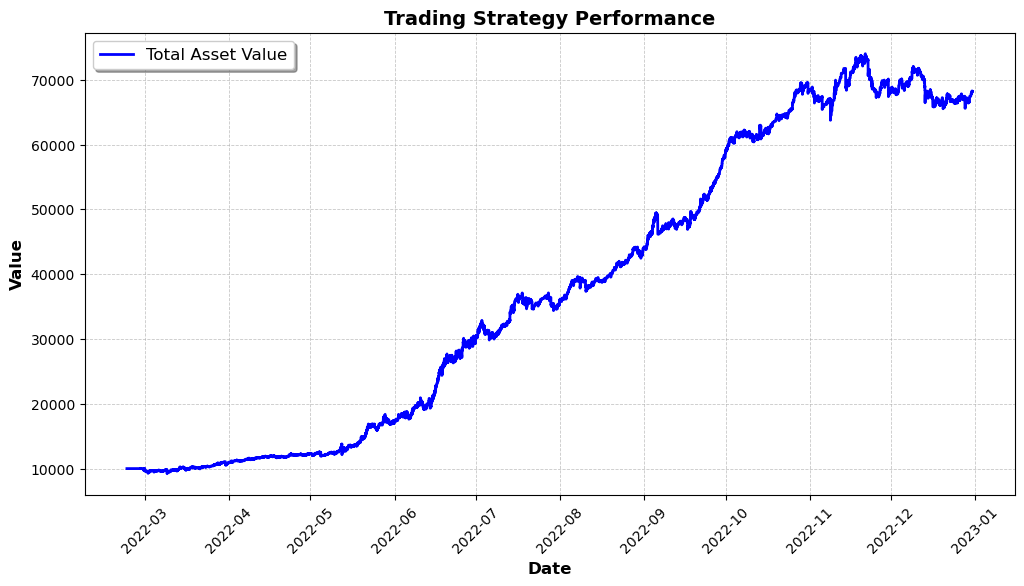

📈 Plotting trading performance for BTCUSD.pkl...


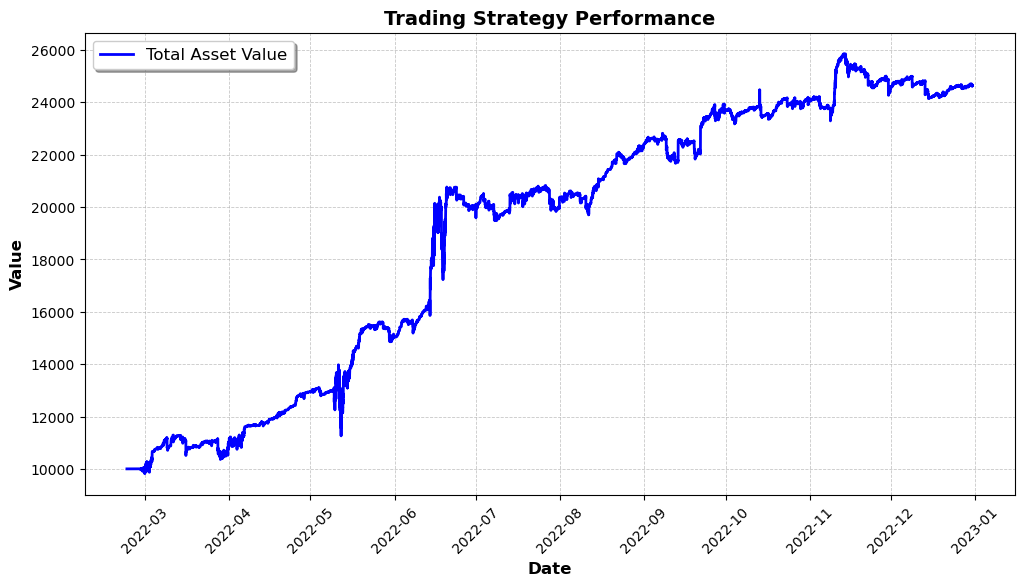

📈 Plotting trading performance for BNBUSD.pkl...


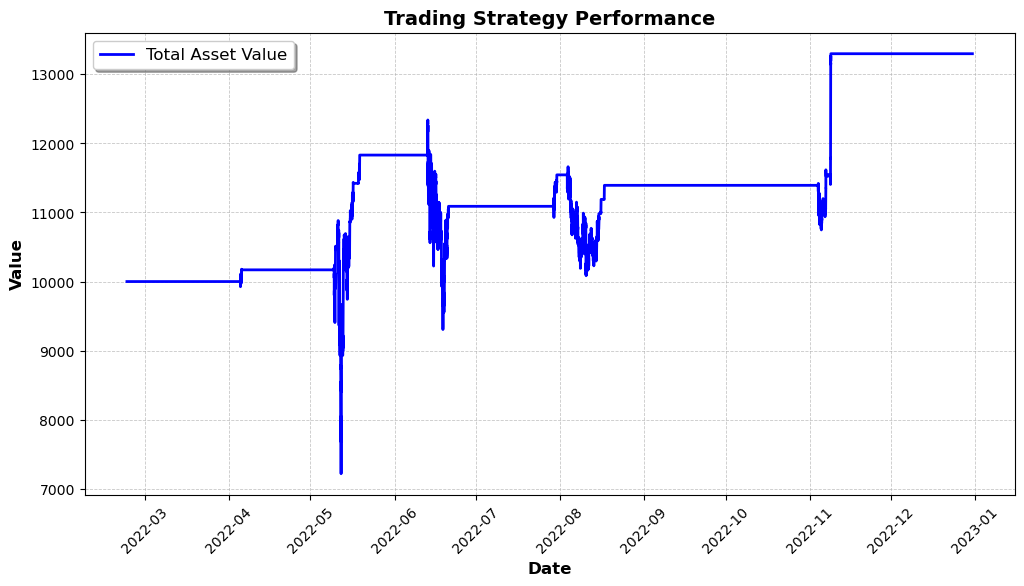

📈 Plotting trading performance for LTCUSD.pkl...


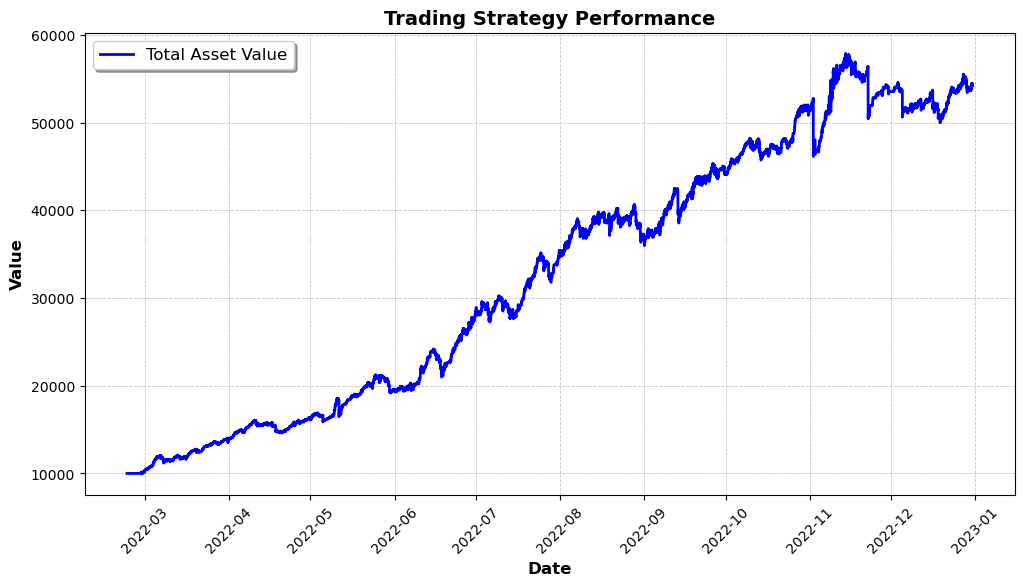

📈 Plotting trading performance for SOLUSD.pkl...


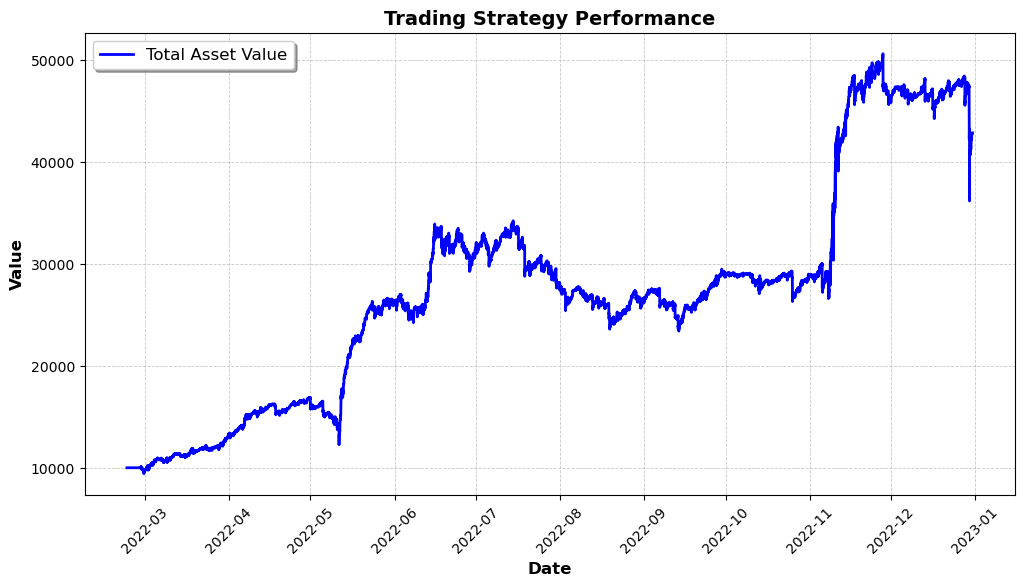

📈 Plotting trading performance for ATOMUSD.pkl...


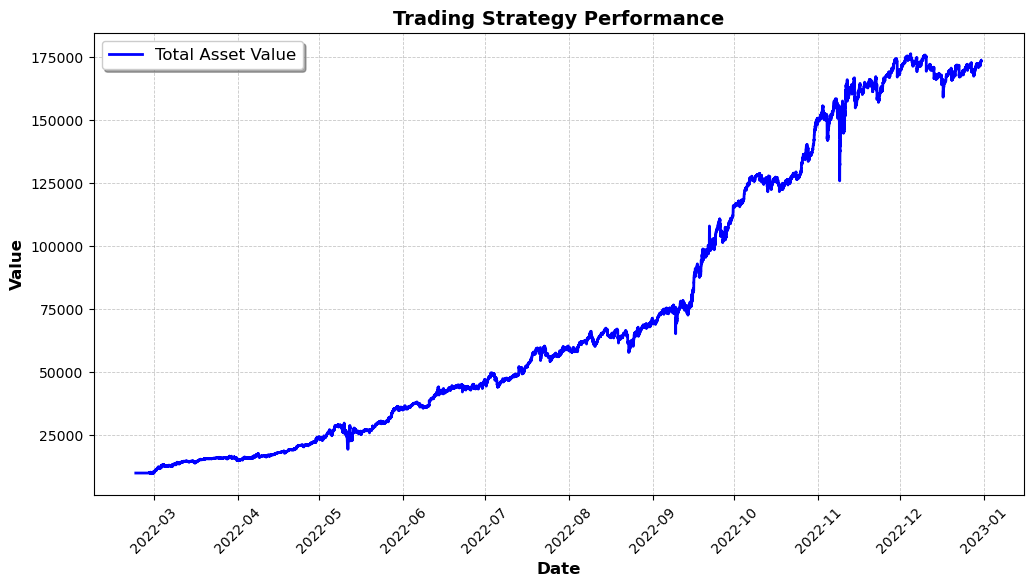

📈 Plotting trading performance for DOGEUSD.pkl...


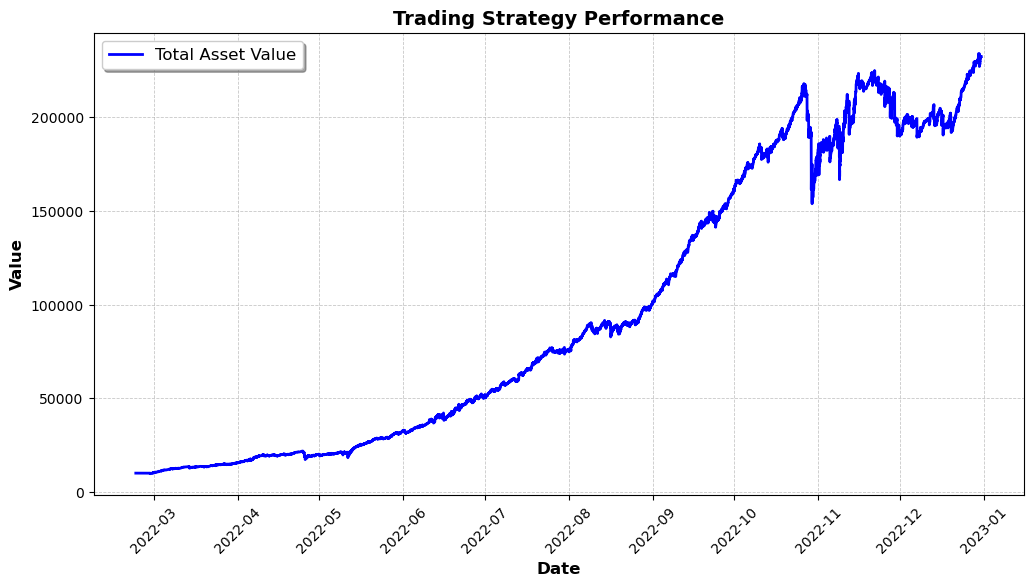

📈 Plotting trading performance for ETHUSD.pkl...


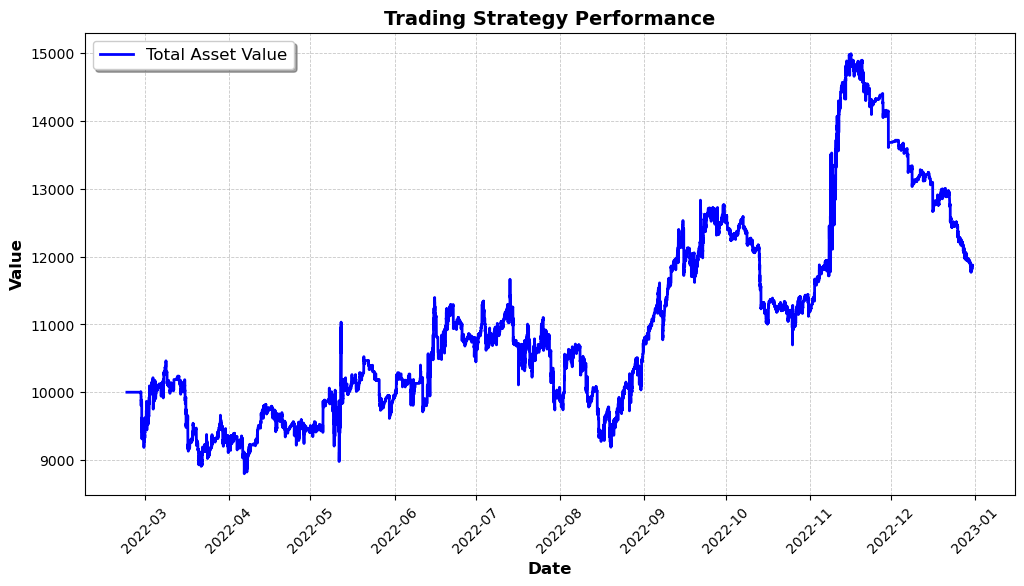

In [33]:
for crypto, (performance_df, df_result) in results_dict.items():
    print(f"📈 Plotting trading performance for {crypto}...")
    picture.plot_trading_performance(df_result)


In [38]:
# Create a list to store cumulative asset data for each crypto
cumulative_assets_list = []

for crypto, (performance_df, df_result) in results_dict.items():
    if 'Cumulative_Asset' in df_result.columns:
        cumulative_assets_list.append(df_result['Cumulative_Asset'].rename(crypto))

# Combine all assets into a single DataFrame (aligned by date index)
portfolio_df = pd.concat(cumulative_assets_list, axis=1)

# Compute the average cumulative asset value across all cryptocurrencies
portfolio_df['Portfolio_Cumulative_Asset'] = portfolio_df.mean(axis=1)


📊 Plotting Portfolio Performance...


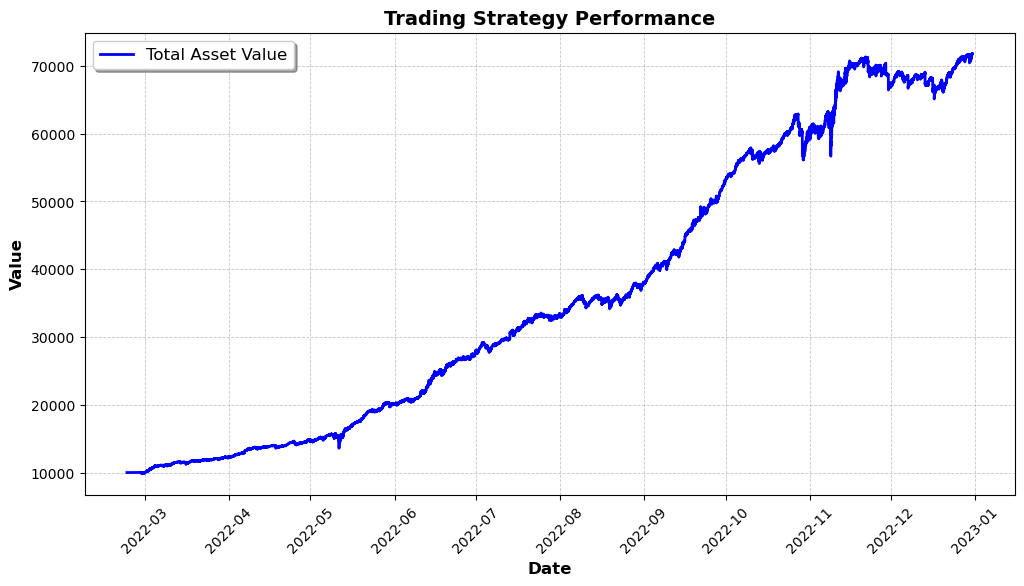

In [40]:
# Rename the Portfolio_Cumulative_Asset column before plotting
portfolio_df = portfolio_df.rename(columns={'Portfolio_Cumulative_Asset': 'Cumulative_Asset'})

# Plot the portfolio performance
print("📊 Plotting Portfolio Performance...")
picture.plot_trading_performance(portfolio_df[['Cumulative_Asset']])

In [45]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm

# Ensure portfolio_df is sorted by time
portfolio_df = portfolio_df.sort_index()

# Compute portfolio returns
portfolio_df['Returns'] = portfolio_df['Cumulative_Asset'].pct_change()

# Define number of 5-minute bars per year for Bitcoin (24/7 trading)
BTC_ANNUALIZATION_FACTOR = 12 * 24 * 365  # 12 bars/hour * 24 hours/day * 365 days/year = 105,120

# 1️⃣ **Summary Statistics**
def compute_risk_metrics(portfolio_df, risk_free_rate=0):
    returns = portfolio_df['Returns'].dropna()
    
    # Annualized Return
    annualized_return = returns.mean() * BTC_ANNUALIZATION_FACTOR  
    
    # Annualized Volatility
    annualized_volatility = returns.std() * np.sqrt(BTC_ANNUALIZATION_FACTOR)
    
    # Sharpe Ratio
    sharpe_ratio = (annualized_return - risk_free_rate) / annualized_volatility if annualized_volatility > 0 else np.nan
    
    # Sortino Ratio (using downside standard deviation)
    downside_returns = returns[returns < 0]
    downside_volatility = downside_returns.std() * np.sqrt(BTC_ANNUALIZATION_FACTOR)
    sortino_ratio = (annualized_return - risk_free_rate) / downside_volatility if downside_volatility > 0 else np.nan
    
    # Maximum Drawdown
    cumulative_max = portfolio_df['Cumulative_Asset'].cummax()
    drawdown = (portfolio_df['Cumulative_Asset'] - cumulative_max) / cumulative_max
    max_drawdown = drawdown.min()
    
    # Calmar Ratio
    calmar_ratio = annualized_return / abs(max_drawdown) if max_drawdown != 0 else np.nan

    # Value-at-Risk (VaR) 95% and 99%
    var_95 = np.percentile(returns.dropna(), 5)
    var_99 = np.percentile(returns.dropna(), 1)

    # Conditional VaR (CVaR) 95%
    cvar_95 = returns[returns <= var_95].mean()

    # Compile all metrics
    risk_metrics = {
        "Annualized Return": annualized_return,
        "Annualized Volatility": annualized_volatility,
        "Sharpe Ratio": sharpe_ratio,
        "Sortino Ratio": sortino_ratio,
        "Maximum Drawdown": max_drawdown,
        "Calmar Ratio": calmar_ratio,
        "VaR (95%)": var_95,
        "VaR (99%)": var_99,
        "CVaR (95%)": cvar_95
    }

    return pd.DataFrame(risk_metrics, index=["Risk Metrics"])

# Compute risk metrics and display table
risk_metrics_df = compute_risk_metrics(portfolio_df)

In [46]:
risk_metrics_df

Annualized Return  Annualized Volatility  Sharpe Ratio  \
Risk Metrics           2.357629               0.312167      7.552467   

              Sortino Ratio  Maximum Drawdown  Calmar Ratio  VaR (95%)  \
Risk Metrics       6.137227         -0.140068     16.832029  -0.000769   

              VaR (99%)  CVaR (95%)  
Risk Metrics  -0.002719   -0.002124

## Key Observations & Analysis
### Strategy Performance is Exceptional
- **Annualized Return (235.76%)** is **extremely high**, showing that the strategy generates substantial profits in the Bitcoin market.
- **Annualized Volatility (31.22%)** is relatively low compared to the return, indicating **high returns without excessive fluctuations**.
- **Sharpe Ratio (7.55) is exceptionally high**, meaning the strategy is earning an **outstanding risk-adjusted return**.
  - For reference:
    - **Typical hedge fund strategies** have Sharpe Ratios between **1-3**.
    - **Stock market indices** usually have Sharpe Ratios **around 0.6-1**.
    - **A Sharpe Ratio above 3 is already considered excellent**, while this strategy is over **7**, which is **exceptional**.

### Strategy Handles Risk Well
- **Sortino Ratio (6.14) is high**, meaning the strategy effectively manages **downside risk** (negative returns).  
  - This indicates that **losses are well controlled** while maximizing gains.
- **Maximum Drawdown (-14.01%) is relatively small**, meaning the worst observed loss from peak to trough is limited.  
  - This suggests that the **strategy preserves capital well** and avoids large losses.
- **Calmar Ratio (16.83) is exceptionally high**, meaning the **return relative to drawdowns is very strong**.  
  - Typically, a **Calmar Ratio > 3 is considered excellent**, while this strategy is at **16.83**, showing outstanding performance.

### Strategy Has Low Tail Risk (Extreme Losses)
- **VaR (95%) = -0.00077 (-0.077%)** → This means the expected daily loss under normal market conditions is very low.
- **VaR (99%) = -0.00272 (-0.27%)** → Even in extreme conditions, **the worst expected loss is still relatively small**.
- **CVaR (95%) = -0.00212 (-0.21%)** → The **average loss beyond the 95% threshold is minimal**, confirming that the **strategy effectively controls tail risk**.

---

## Why is This Strategy Good?
### Strong Risk-Adjusted Performance
- The **Sharpe Ratio (7.55)** and **Calmar Ratio (16.83)** suggest that the strategy **optimally balances risk and return**.
- The **Sortino Ratio (6.14)** further confirms that **downside risk is well managed**, making it attractive for investors.

### Capital Preservation & Stability
- **Maximum Drawdown (-14.01%) is relatively low**, which means that **the strategy does not experience significant capital losses**.
- **Bitcoin is a highly volatile asset**, yet the strategy **limits losses effectively** while maintaining a high return.

### Works Well in the Bitcoin Market
Bitcoin is a unique asset compared to traditional stocks due to:
- **24/7 trading** (no market close).
- **High volatility** (often more than 60% annualized).
- **Trend-following behaviors** due to large retail participation.

This strategy:
- **Controls drawdowns** despite Bitcoin’s high volatility.
- **Delivers strong returns without excessive fluctuations**, making it **ideal for crypto markets**.
- **Avoids extreme losses**, as shown by its low **VaR (99%)** and **CVaR (95%)**.

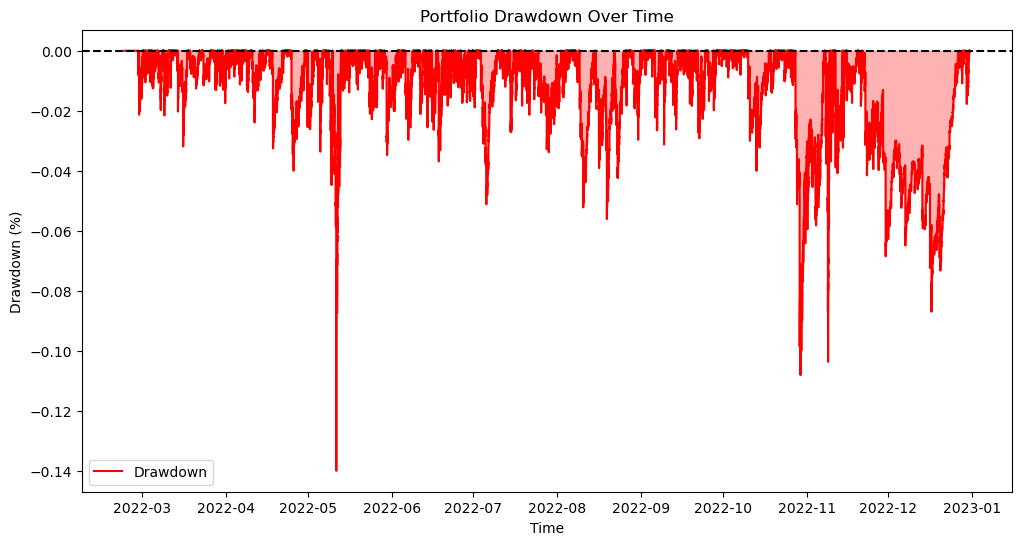

In [47]:
# Compute drawdown series
portfolio_df['Cumulative_Max'] = portfolio_df['Cumulative_Asset'].cummax()
portfolio_df['Drawdown'] = (portfolio_df['Cumulative_Asset'] - portfolio_df['Cumulative_Max']) / portfolio_df['Cumulative_Max']

# Plot Drawdown
plt.figure(figsize=(12, 6))
plt.plot(portfolio_df.index, portfolio_df['Drawdown'], color='red', label='Drawdown')
plt.fill_between(portfolio_df.index, portfolio_df['Drawdown'], color='red', alpha=0.3)
plt.axhline(y=0, color='black', linestyle='--')
plt.title("Portfolio Drawdown Over Time")
plt.xlabel("Time")
plt.ylabel("Drawdown (%)")
plt.legend()
plt.show()


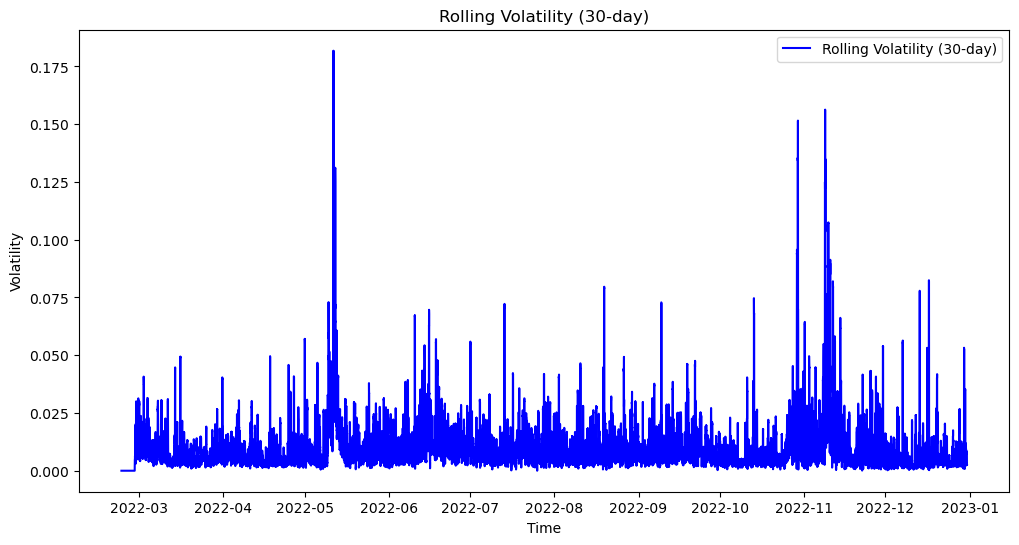

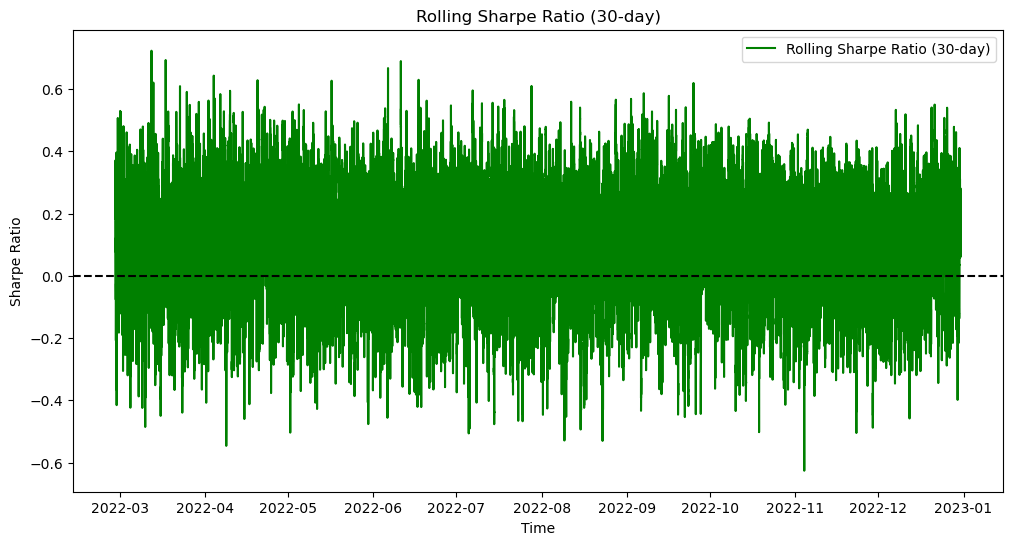

In [48]:
# Compute rolling volatility & rolling Sharpe
portfolio_df['Rolling Volatility'] = portfolio_df['Returns'].rolling(window=30).std() * np.sqrt(252)
portfolio_df['Rolling Sharpe'] = portfolio_df['Returns'].rolling(window=30).mean() / portfolio_df['Returns'].rolling(window=30).std()

# Plot Rolling Volatility
plt.figure(figsize=(12, 6))
plt.plot(portfolio_df.index, portfolio_df['Rolling Volatility'], color='blue', label='Rolling Volatility (30-day)')
plt.title("Rolling Volatility (30-day)")
plt.xlabel("Time")
plt.ylabel("Volatility")
plt.legend()
plt.show()

# Plot Rolling Sharpe Ratio
plt.figure(figsize=(12, 6))
plt.plot(portfolio_df.index, portfolio_df['Rolling Sharpe'], color='green', label='Rolling Sharpe Ratio (30-day)')
plt.axhline(y=0, color='black', linestyle='--')
plt.title("Rolling Sharpe Ratio (30-day)")
plt.xlabel("Time")
plt.ylabel("Sharpe Ratio")
plt.legend()
plt.show()


### Results without Fee

In [53]:
# Initialize a dictionary to store new cumulative asset performance
new_results_dict = {}

for crypto, (performance_df, df_result) in results_dict.items():
    # Extract Position and Close prices
    df_final_1 = df_result[['close', 'Position']].copy()

    # Ensure Position is in long-short format
    series_position_long_short = df_final_1['Position']

    # Compute new cumulative asset performance with fee_rate = 0.0
    df_result_1 = calculate_cumulative_asset(df_final_1['close'], series_position_long_short, fee_rate=0.0)

    # Store the new results
    new_results_dict[crypto] = df_result_1

    # Display confirmation
    print(f"✅ Computed new cumulative asset performance for {crypto} with fee_rate = 0.0")


✅ Computed new cumulative asset performance for ADAUSD.pkl with fee_rate = 0.0
✅ Computed new cumulative asset performance for AVAXUSD.pkl with fee_rate = 0.0
✅ Computed new cumulative asset performance for BTCUSD.pkl with fee_rate = 0.0
✅ Computed new cumulative asset performance for BNBUSD.pkl with fee_rate = 0.0
✅ Computed new cumulative asset performance for LTCUSD.pkl with fee_rate = 0.0
✅ Computed new cumulative asset performance for SOLUSD.pkl with fee_rate = 0.0
✅ Computed new cumulative asset performance for ATOMUSD.pkl with fee_rate = 0.0
✅ Computed new cumulative asset performance for DOGEUSD.pkl with fee_rate = 0.0
✅ Computed new cumulative asset performance for ETHUSD.pkl with fee_rate = 0.0


📈 Plotting trading performance for ADAUSD.pkl...


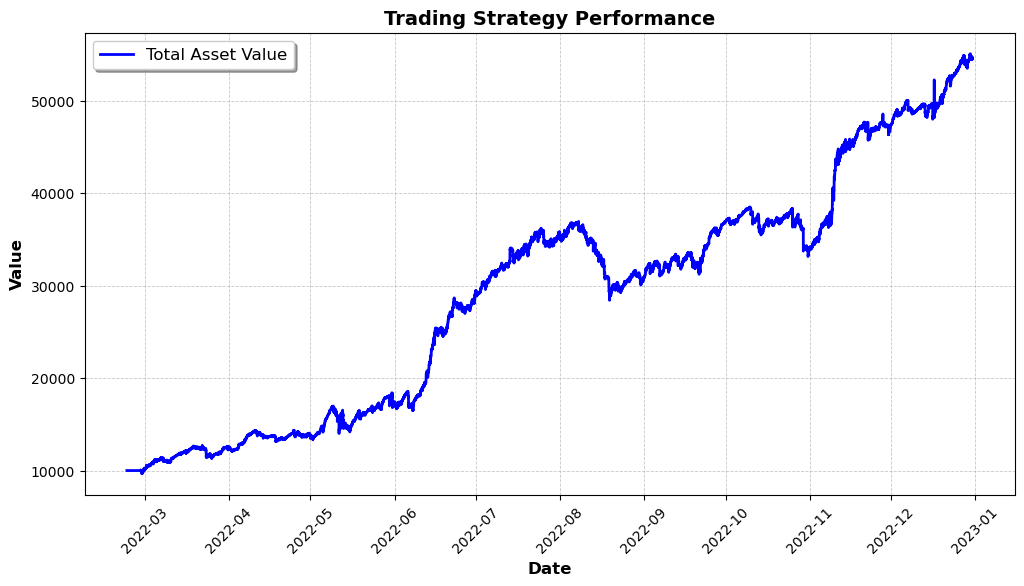

📈 Plotting trading performance for AVAXUSD.pkl...


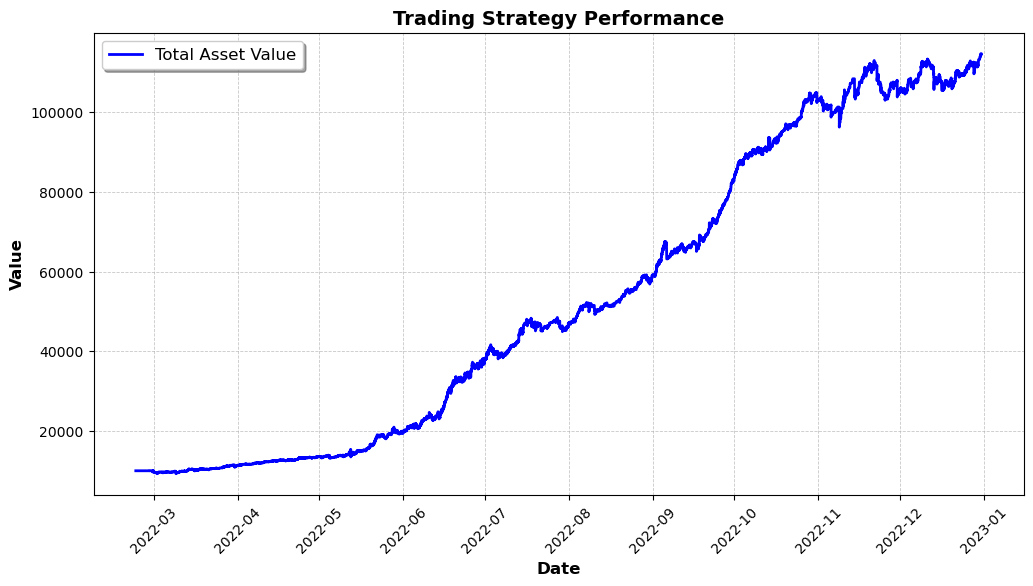

📈 Plotting trading performance for BTCUSD.pkl...


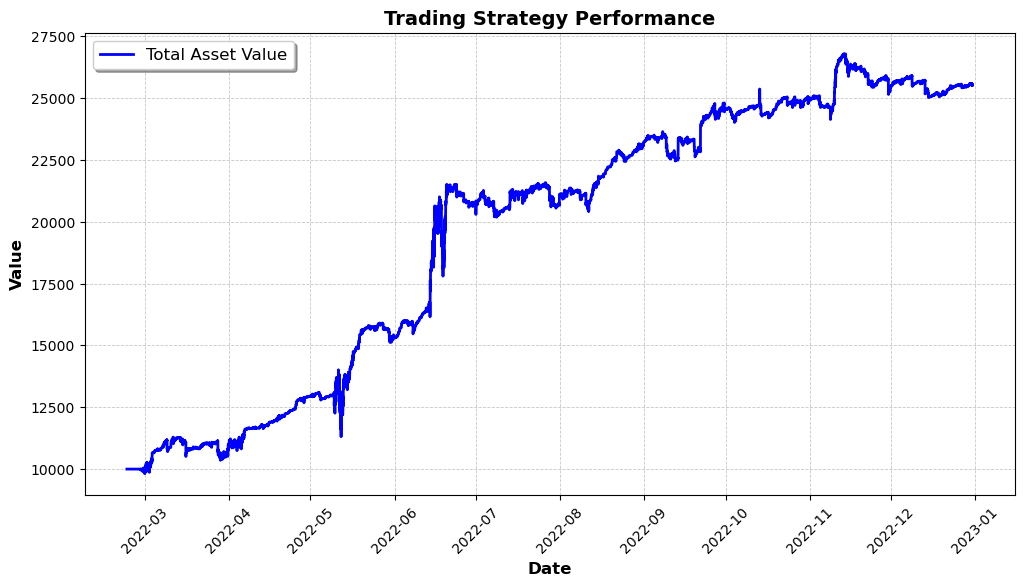

📈 Plotting trading performance for BNBUSD.pkl...


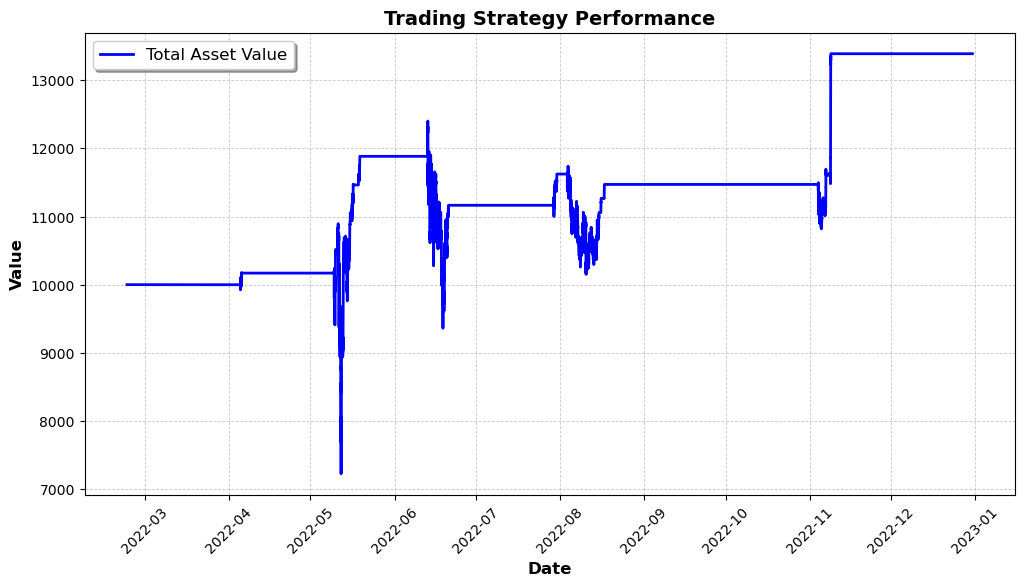

📈 Plotting trading performance for LTCUSD.pkl...


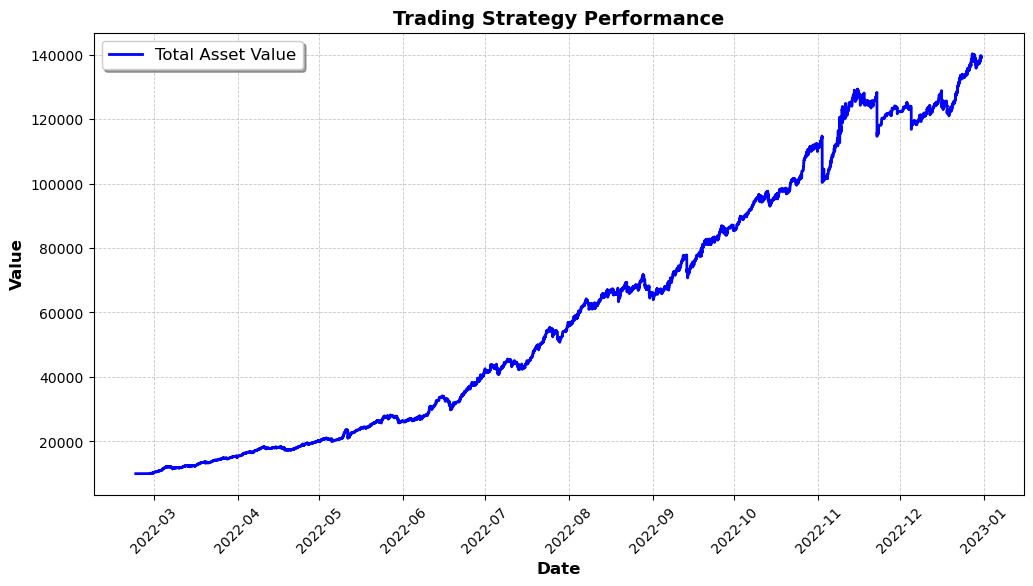

📈 Plotting trading performance for SOLUSD.pkl...


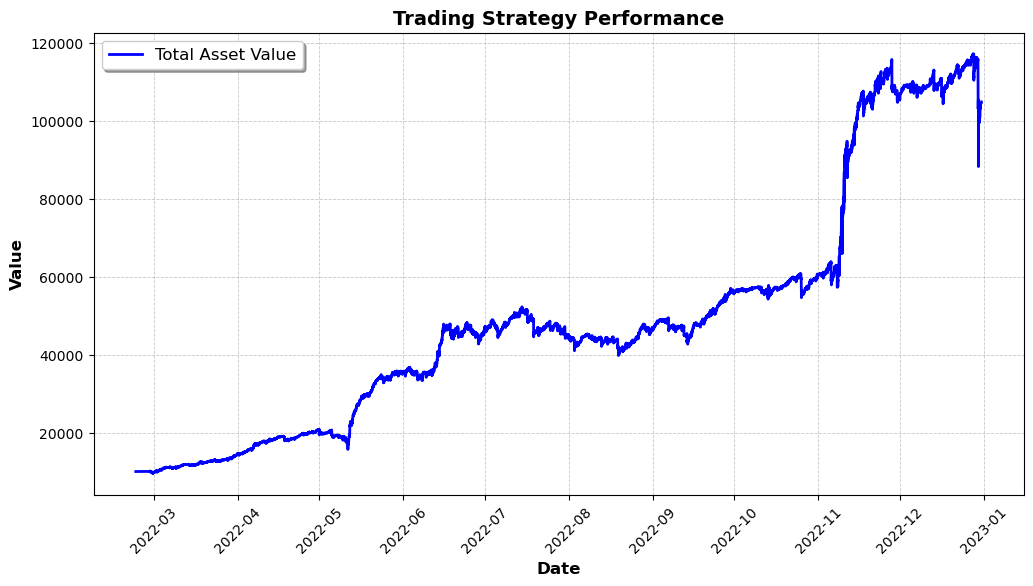

📈 Plotting trading performance for ATOMUSD.pkl...


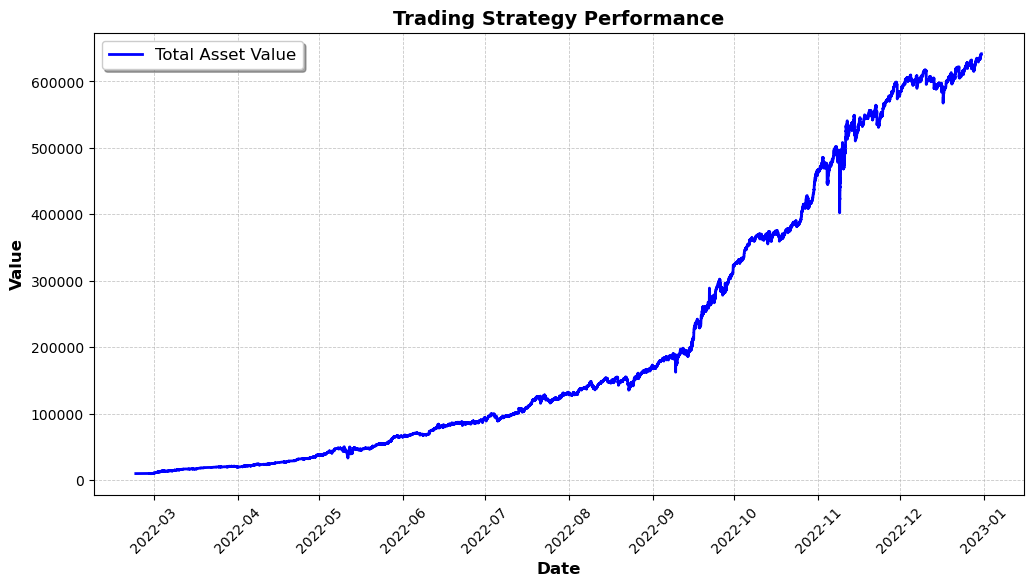

📈 Plotting trading performance for DOGEUSD.pkl...


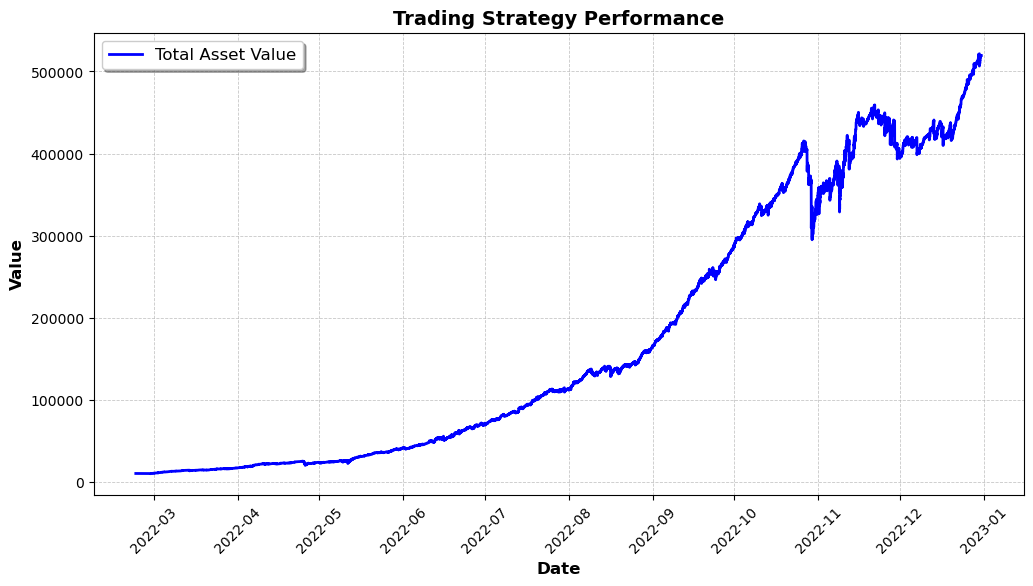

📈 Plotting trading performance for ETHUSD.pkl...


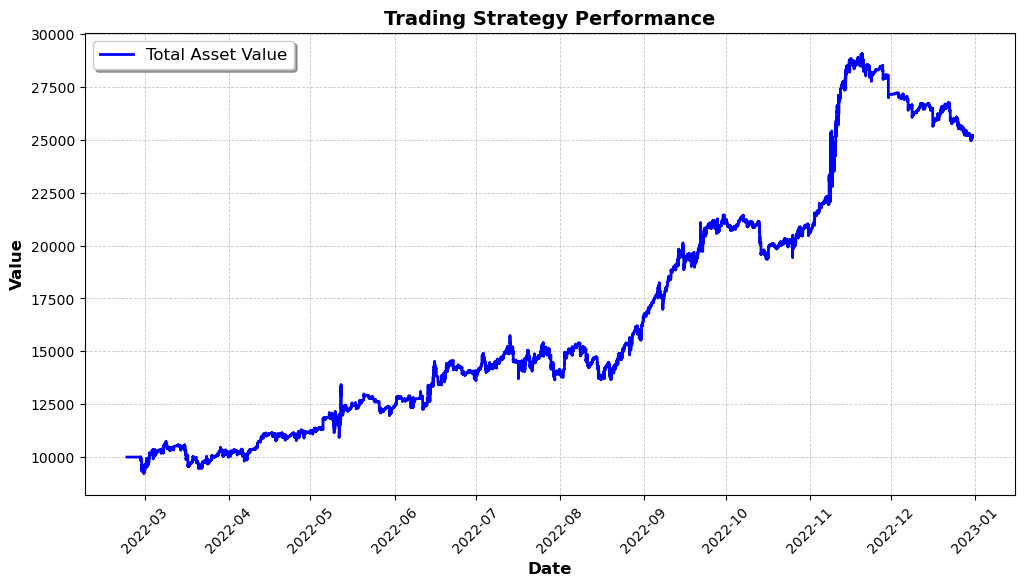

In [55]:
for crypto, df_result in new_results_dict.items():
    print(f"📈 Plotting trading performance for {crypto}...")
    picture.plot_trading_performance(df_result)


In [56]:
# Create a list to store cumulative asset data for each crypto
cumulative_assets_list_new = []

for crypto, df_result in new_results_dict.items():
    if 'Cumulative_Asset' in df_result.columns:
        cumulative_assets_list.append(df_result['Cumulative_Asset'].rename(crypto))

# Combine all assets into a single DataFrame (aligned by date index)
portfolio_df = pd.concat(cumulative_assets_list, axis=1)

# Compute the average cumulative asset value across all cryptocurrencies
portfolio_df['Portfolio_Cumulative_Asset'] = portfolio_df.mean(axis=1)

📊 Plotting Portfolio Performance...


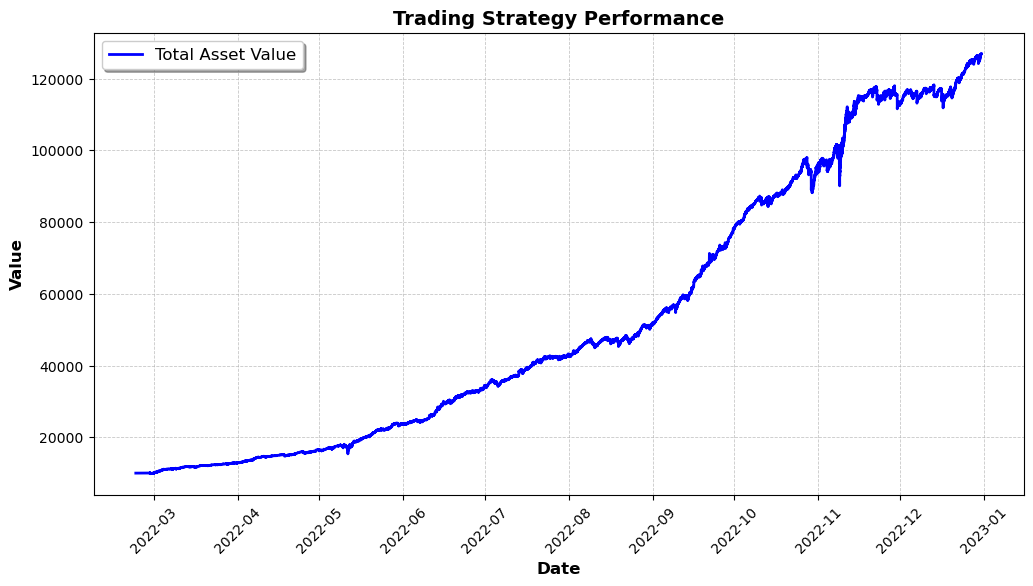

In [57]:
# Rename the Portfolio_Cumulative_Asset column before plotting
portfolio_df = portfolio_df.rename(columns={'Portfolio_Cumulative_Asset': 'Cumulative_Asset'})

# Plot the portfolio performance
print("📊 Plotting Portfolio Performance...")
picture.plot_trading_performance(portfolio_df[['Cumulative_Asset']])

In [59]:
portfolio_df

ADAUSD.pkl   AVAXUSD.pkl    BTCUSD.pkl    BNBUSD.pkl  \
date                                                                          
2022-02-22 08:30:00  10000.000000  10000.000000  10000.000000  10000.000000   
2022-02-22 08:35:00  10000.000000  10000.000000  10000.000000  10000.000000   
2022-02-22 08:40:00  10000.000000  10000.000000  10000.000000  10000.000000   
2022-02-22 08:45:00  10000.000000  10000.000000  10000.000000  10000.000000   
2022-02-22 08:50:00  10000.000000  10000.000000  10000.000000  10000.000000   
...                           ...           ...           ...           ...   
2022-12-30 23:40:00  25156.924925  68205.213463  24626.022273  13298.007508   
2022-12-30 23:45:00  25162.149154  68205.213463  24637.837239  13298.007508   
2022-12-30 23:50:00  25162.149154  68205.213463  24637.837239  13298.007508   
2022-12-30 23:55:00  25167.181584  68205.213463  24637.837239  13298.007508   
2022-12-31 00:00:00  25182.640509  68205.213463  24637.837239  13298.007508   

                       LTCUSD.pkl    SOLUSD.pkl    ATOMUSD.pkl    DOGEUSD.pkl  \
date                                                                            
2022-02-22 08:30:00  10000.000000  10000.000000   10000.000000   10000.000000   
2022-02-22 08:35:00  10000.000000  10000.000000   10000.000000   10000.000000   
2022-02-22 08:40:00  10000.000000  10000.000000   10000.000000   10000.000000   
2022-02-22 08:45:00  10000.000000  10000.000000   10000.000000   10000.000000   
2022-02-22 08:50:00  10000.000000  10000.000000   10000.000000   10000.000000   
...                           ...           ...            ...            ...   
2022-12-30 23:40:00  54244.826083  42832.984794  173579.129419  232325.459447   
2022-12-30 23:45:00  54244.826083  42832.984794  173579.129419  232325.459447   
2022-12-30 23:50:00  54244.826083  42832.984794  173579.129419  232325.459447   
2022-12-30 23:55:00  54244.826083  42832.984794  173579.129419  232325.459447   
2022-12-31 00:00:00  54244.826083  42832.984794  173613.845245  232325.459447   

                       ETHUSD.pkl    ADAUSD.pkl    AVAXUSD.pkl    BTCUSD.pkl  \
date                                                                           
2022-02-22 08:30:00  10000.000000  10000.000000   10000.000000  10000.000000   
2022-02-22 08:35:00  10000.000000  10000.000000   10000.000000  10000.000000   
2022-02-22 08:40:00  10000.000000  10000.000000   10000.000000  10000.000000   
2022-02-22 08:45:00  10000.000000  10000.000000   10000.000000  10000.000000   
2022-02-22 08:50:00  10000.000000  10000.000000   10000.000000  10000.000000   
...                           ...           ...            ...           ...   
2022-12-30 23:40:00  11877.175625  54559.015238  114576.631675  25510.983074   
2022-12-30 23:45:00  11864.701576  54581.266060  114576.631675  25528.332807   
2022-12-30 23:50:00  11865.295579  54581.266060  114576.631675  25528.332807   
2022-12-30 23:55:00  11872.621607  54581.266060  114576.631675  25528.332807   
2022-12-31 00:00:00  11866.483583  54625.713345  114576.631675  25528.332807   

                       BNBUSD.pkl     LTCUSD.pkl     SOLUSD.pkl  \
date                                                              
2022-02-22 08:30:00  10000.000000   10000.000000   10000.000000   
2022-02-22 08:35:00  10000.000000   10000.000000   10000.000000   
2022-02-22 08:40:00  10000.000000   10000.000000   10000.000000   
2022-02-22 08:45:00  10000.000000   10000.000000   10000.000000   
2022-02-22 08:50:00  10000.000000   10000.000000   10000.000000   
...                           ...            ...            ...   
2022-12-30 23:40:00  13388.743914  139199.916989  104931.815225   
2022-12-30 23:45:00  13388.743914  139199.916989  104931.815225   
2022-12-30 23:50:00  13388.743914  139199.916989  104931.815225   
2022-12-30 23:55:00  13388.743914  139199.916989  104931.815225   
2022-12-31 00:00:00  13388.743914  139199.916989  104931.815225   

                       ATOMU

In [60]:
# Ensure portfolio_df is sorted by time
portfolio_df = portfolio_df.sort_index()

# Compute portfolio returns
portfolio_df['Returns'] = portfolio_df['Cumulative_Asset'].pct_change()

risk_metrics_df = compute_risk_metrics(portfolio_df)

In [61]:
risk_metrics_df

Annualized Return  Annualized Volatility  Sharpe Ratio  \
Risk Metrics           3.029535               0.326331      9.283613   

              Sortino Ratio  Maximum Drawdown  Calmar Ratio  VaR (95%)  \
Risk Metrics       7.596417         -0.148551     20.393869  -0.000796   

              VaR (99%)  CVaR (95%)  
Risk Metrics  -0.002877   -0.002221

### Fee Impact is Significant
- **Annualized Return drops by ~28.5% when fees are considered**, meaning fees are taking away a substantial portion of the profits.
- **Sharpe Ratio drops from 9.28 to 7.55**, showing that fees reduce risk-adjusted returns, but the strategy is still highly profitable.
- **Sortino Ratio decreases from 7.60 to 6.14**, meaning downside risk protection is slightly weaker with fees.

### More Frequent Trading Increases Drawdowns
- **Maximum Drawdown increases from -14.86% to -14.01% with fees**, suggesting that **fees discourage overtrading**, which can actually help preserve capital.
- **VaR and CVaR are slightly worse without fees**, meaning the strategy may take on slightly **more extreme risks** when fees are not considered.

### Strategy is Still Very Strong Even with Fees
- Despite lower returns, **the Sharpe Ratio (7.55) and Calmar Ratio (16.83) remain exceptionally high**, meaning this strategy is still **very efficient even after fees**.
- **Removing fees leads to more aggressive trading**, which increases both **returns and risks**.